[Table of Contents   目录表](./table_of_contents.ipynb)

# Designing Kalman Filters   卡尔曼滤波器的设计

In [1]:
%matplotlib inline

In [2]:
#format the book   #格式化书
import book_format   进口book_format
book_format.set_style()   book_format.set_style()  # 该行代码用于设置书籍格式的样式。

## Introduction   介绍

In the last chapter we worked with 'textbook' problems. These are problems that are easy to state, program in a few lines of code, and teach. Real world problems are rarely this simple. In this chapter we will work with more realistic examples, and learn how to evaluate filter performance.在上一章中，我们处理的是“教科书式”的问题。这些问题易于表述，用几行代码就能编写程序，也便于教学。但现实世界中的问题很少如此简单。在本章中，我们将处理更贴近实际的例子，并学习如何评估滤波器的性能。

We will begin by tracking a robot in a 2D space, such as a field or warehouse. We will start with a simple noisy sensor that outputs noisy $(x,y)$ coordinates which we will need to filter to generate a 2D track. Once we have mastered this concept, we will extend the problem significantly with more sensors and then adding control inputs. 我们将从在一个二维空间（比如一块场地或仓库）中追踪一个机器人开始。我们将从一个简单的有噪声的传感器入手，该传感器输出有噪声的（x，y）坐标，我们需要对其进行滤波以生成二维轨迹。一旦掌握了这个概念，我们将大幅扩展问题，增加更多的传感器，然后加入控制输入。

We will then move to a nonlinear problem. The world is nonlinear, but the Kalman filter is linear. Sometimes you can get away with using it for mildly nonlinear problems, sometimes you can't. I'll show you examples of both. This will set the stage for the remainder of the book, where we learn techniques for nonlinear problems. 接下来我们将转向一个非线性问题。世界是非线性的，但卡尔曼滤波器是线性的。有时对于轻度非线性问题，使用它还能勉强应付，有时则不行。我会给你们展示这两种情况的例子。这将为本书的其余部分奠定基础，在那里我们将学习解决非线性问题的技术。

## Tracking a Robot   跟踪机器人

This first attempt at tracking a robot will closely resemble the 1D dog tracking problem of previous chapters. Instead of a sensor that outputs position in a hallway, we now have a sensor that supplies a noisy measurement of position in a 2D space. At each time $t$ it will provide an $(x,y)$ coordinate pair of the noisy measurement of the sensor's position in the field.这次首次尝试追踪机器人的问题将与前几章中的一维狗追踪问题非常相似。只不过现在不是输出走廊中位置的传感器，而是提供二维空间中传感器位置的有噪声测量值的传感器。在每个时刻 $t$，它都会给出传感器在该区域中的有噪声测量值的 $(x,y)$ 坐标对。

Implementation of code to interact with real sensors is beyond the scope of this book, so as before we will program simple simulations of the sensors. We will develop several of these sensors as we go, each with more complications, so as I program them I will just append a number to the function name. 与真实传感器进行交互的代码实现超出了本书的范围，因此和之前一样，我们将编写传感器的简单模拟程序。随着学习的深入，我们将开发几个这样的传感器，每个传感器的复杂程度都会增加，所以在编写代码时，我会在函数名后面加上一个数字。

So let's start with a very simple sensor, one that simulates tracking an object traveling in a straight line. It is initialized with the initial position, velocity, and noise standard deviation. Each call to `read()` updates the position by one time step and returns the new measurement.那么让我们从一个非常简单的传感器开始，它模拟追踪一个沿直线运动的物体。该传感器通过初始位置、速度和噪声标准差进行初始化。每次调用 `read()` 方法都会将位置更新一个时间步长，并返回新的测量值。

In [3]:
from numpy.random import randnfrom numpy.random   随机 导入 randn

class PosSensor(object):   类 PosSensor（对象）：
    def __init__(self, pos=(0, 0), vel=(0, 0), noise_std=1.):def __init__(self, pos=(0, 0), vel=(0, 0), noise_std=1.)： 初始化函数，参数包括位置 pos（默认值为 (0, 0)）、速度 vel（默认值为 (0, 0)）和噪声标准差 noise
        self.vel = vel   自我。水平=水平
        self.noise_std = noise_std   self.noise_std = 噪声标准差
        self.pos = [pos[0], pos[1]]
        
    def read(self):   def读(自我):
        self.pos[0] += self.vel[0]
        self.pos[1] += self.vel[1]
        
        return [self.pos[0] + randn() * self.noise_std,
                self.pos[1] + randn() * self.noise_std]

A quick test to verify that it works as we expect.一个快速测试，以验证其是否如我们所预期的那样运行。

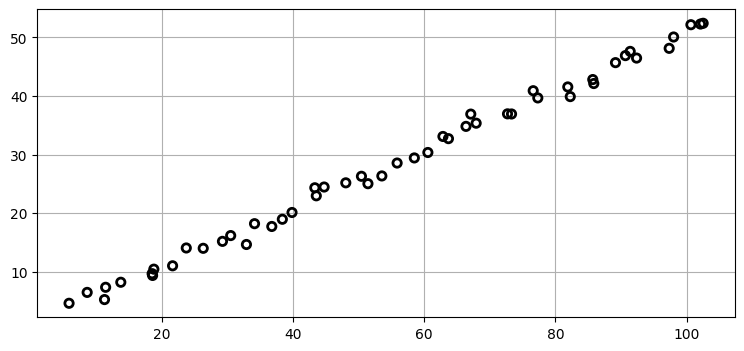

In [4]:
import matplotlib.pyplot as plt导入 matplotlib 库中的 pyplot 模块作为 plt 。
import numpy as np   导入numpy为np
from kf_book.book_plots import plot_measurements

pos, vel = (4, 3), (2, 1)   pos, vel = (4,3)， (2,1)
sensor = PosSensor(pos, vel, noise_std=1)
ps = np.array([sensor.read() for _ in range(50)])
plot_measurements(ps[:, 0], ps[:, 1]);

That looks correct. The slope is 1/2, as we would expect with a velocity of (2, 1), and the data seems to start at near (6, 4). It doesn't look realistic. This is still a 'textbook' representation. As we continue we will add complications that adds real world behavior. 这看起来没错。斜率为 1/2，正如我们预期的那样，速度为（2，1），数据似乎从接近（6，4）处开始。这看起来不太真实。这仍然是一个“教科书式”的表示。随着我们继续下去，我们将添加一些复杂情况，以体现现实世界中的行为。

### Choose the State Variables选择状态变量

As always, the first step is to choose our state variables. We are tracking in two dimensions and have a sensor that gives us a reading in each of those two dimensions, so we  know that we have the two *observed variables* $x$ and $y$. If we created our Kalman filter using only those two variables the performance would not be very good because we would be ignoring the information velocity can provide to us. We will want to incorporate velocity into our equations as well. I will represent this as一如既往，第一步是选择我们的状态变量。我们在二维空间中进行追踪，并且有一个传感器能为我们提供这两个维度的读数，所以我们知道有两个“观测变量”$x$和$y$。如果我们仅使用这两个变量来创建卡尔曼滤波器，其性能不会太好，因为我们忽略了速度能为我们提供的信息。我们还希望将速度纳入我们的方程中。我将用以下方式表示：

$$\mathbf x = 
\begin{bmatrix}x & \dot x & y & \dot y\end{bmatrix}^\mathsf T$$\begin{bmatrix}x & \dot x & y & \dot y\end{bmatrix}^\mathsf T

翻译成中文为：\(\begin{bmatrix}x & \dot{x} & y & \dot{y}\end{bmatrix}^\mathsf T\)\(\begin{bmatrix}x & \dot{x} & y & \dot{y}\end{bmatrix}^\mathsf T\) translates to: \(\begin{bmatrix}x & \dot{x} & y & \dot{y}\end{bmatrix}^\textsf{T}\) in English. However, if you are looking for a more natural way to express

There is nothing special about this organization. I could have used $\begin{bmatrix}x & y & \dot x &  \dot y\end{bmatrix}^\mathsf T$ or something less logical. I just need to be consistent in the rest of the matrices. I like keeping positions and velocities next to each other because it keeps the covariances between positions and velocities in the same sub block of the covariance matrix. In my formulation `P[1,0]` contains the covariance of $x$ and $\dot x$. In the alternative formulation that covariance is at `P[2, 0]`. This gets worse as the number of dimension increases.这个组织没有什么特别之处。我本可以使用 $\begin   \开始{bmatrix}x & y & \dot   \点 x & \dot   \点 y\end   \结束{bmatrix}^\mathsf T$ 或者其他不太合乎逻辑的表示方式。我只是需要在其余的矩阵中保持一致性。我喜欢将位置和速度放在一起，因为这样可以将位置和速度之间的协方差保留在协方差矩阵的同一子块中。在我的公式中，`P[1,0]   P (1,0)` 包含 $x$ 和 $\dot   \点 x$ 的协方差。而在另一种公式中，该协方差位于 `P[2, 0]   P (2,0)`。随着维度的增加，这种情况会变得更糟。

Let's pause and address how you identify the hidden variables. This example is somewhat obvious because we've already worked through the 1D case, but other problems won't be obvious There is no easy answer to this question. The first thing to ask yourself is what is the interpretation of the first and second derivatives of the data from the sensors. We do that because obtaining the first and second derivatives is mathematically trivial if you are reading from the sensors using a fixed time step. The first derivative is just the difference between two successive readings. In our tracking case the first derivative has an obvious physical interpretation: the difference between two successive positions is velocity. 

Beyond this you can start looking at how you might combine the data from two or more different sensors to produce more information. This opens up the field of *sensor fusion*, and we will be covering examples of this in later sections. For now, recognize that choosing the appropriate state variables is paramount to getting the best possible performance from your filter. Once you have chosen hidden variables, you must run many tests to ensure that you are generating real results for them. The Kalman filter runs whatever model you give it; if your model cannot generate good information for the hidden variables the Kalman filter output will be nonsensical.

### Design State Transition Function设计状态转换函数

Our next step is to design the state transition function. Recall that the state transition function is implemented as a matrix $\mathbf F$ that we multiply with the previous state of our system to get the next state, like so. 我们的下一步是设计状态转移函数。回想一下，状态转移函数是通过一个矩阵 $\mathbf   \ mathbf。 F$ 来实现的，我们将该矩阵与系统的前一状态相乘，从而得到下一状态，具体如下。

$$\mathbf{\bar x} = \mathbf{Fx}$$

I will not belabor this as it is very similar to the 1-D case we did in the previous chapter. The state transition equations are我不会在此过多赘述，因为它与我们在上一章中处理的一维情况非常相似。状态转移方程为

$$
\begin{aligned}   \贝京{aligned。
x &= 1x + \Delta t \dot x + 0y + 0 \dot y \\x 与 1x 相等  Δt 乘以 x 的导数  0  y  0  y 的导数
v_x &= 0x + 1\dot x + 0y + 0 \dot y \\v_x = 0x1x0y0y
y &= 0x + 0\dot x + 1y + \Delta t \dot y \\y 与 0x 0·x 1y Δt·y 相等
v_y &= 0x + 0\dot x + 0y + 1 \dot yv_y = 0x0\dot   \点 x0y1\dot   \点 y
\end{aligned}   \ end办法{}
$$

Laying it out that way shows us both the values and row-column organization required for $\small\mathbf F$. We convert this to matrix-vector form:这样排列能让我们同时看到 $\small\mathbf   小喝mathbf F$ 所需的值以及行列组织方式。我们将其转换为矩阵向量形式：

$$
\begin{bmatrix}x \\ \dot x \\ y \\ \dot y\end{bmatrix} = \begin{bmatrix}1& \Delta t& 0& 0\\0& 1& 0& 0\\0& 0& 1& \Delta t\\ 0& 0& 0& 1\end{bmatrix}\begin{bmatrix}x \\ \dot x \\ y \\ \dot y\end{bmatrix}$$\[\begin{bmatrix}x \\ \dot x \\ y \\ \dot y\end{bmatrix} = \begin{bmatrix}1& \Delta t& 0& 0\\0& 1& 0& 0\\0& 0& 1& \Delta t\\ 0& 0& 0& 1\end{bmatrix}\begin{bmatrix}x \\ \dot x \\ y \\ \dot y\end{bmatrix}\] 

翻译为：

\[\begin{bmatrix}x \\ \dot x \\ y \\ \dot y\end{bmatrix} = \begin{bmatrix}1& \Delta t& 0& 0\\0& 1& 0& 0\\0& 0& 1& \Delta t\\ 0& 0& 0& 1\end{bmatrix} \begin{bmatrix}x \\ \dot x \\ y \\ \dot y\end{bmatrix}\] \[\begin{bmatrix}x \\ \dot x \\ y \\ \dot y\end{bmatrix} = \begin{bmatrix}1& \Delta t& 0& 0\\0& 1& 0& 0\\0& 0& 1& \Delta t\\ 0& 0& 0& 1\end{bmatrix} \begin{bmatrix}x \\ \dot x \\ y \\ \dot y\end{bmatrix}\]

\[ \begin{bmatrix} x \\ \dot{x} \\ y \\ \dot{y} \end{bmatrix} = \begin{bmatrix} 1 & \Delta t & 0 & 0 \\ 0 & 1 & 0 & 0 \\ 0 & 0 & 1 & \Delta t \\ 0 & 0 & 0 & 1 \end{bmatrix} \begin{bmatrix} x \\ \dot{x} \\ y \\ \dot{y} \end{bmatrix} \]

其中，

So, let's do this in Python. It is very simple; the only thing new here is setting `dim_z` to 2. We will see why it is set to 2 in step 4.

In [5]:
from filterpy.kalman import KalmanFilter

tracker = KalmanFilter(dim_x=4, dim_z=2)
dt = 1.   # time step 1 second

tracker.F = np.array([[1, dt, 0,  0],
                      [0,  1, 0,  0],
                      [0,  0, 1, dt],
                      [0,  0, 0,  1]])

### Design the Process Noise Matrix设计过程噪声矩阵

FilterPy can compute the $\mathbf Q$ matrix for us. For simplicity I will assume the noise is a discrete time Wiener process - that it is constant for each time period. This assumption allows me to use a variance to specify how much I think the model changes between steps. Revisit the Kalman Filter Math chapter if this is not clear.FilterPy 可以为我们计算 $\mathbf   \ mathbf。 Q   问$ 矩阵。为简单起见，我将假设噪声是一个离散时间维纳过程——即在每个时间段内都是恒定的。这一假设使我能够使用方差来指定我认为模型在各步之间的变化程度。如果这一点不清楚，请回顾卡尔曼滤波数学章节。

In [6]:
from scipy.linalg import block_diag
from filterpy.common import Q_discrete_white_noise

q = Q_discrete_white_noise(dim=2, dt=dt, var=0.001)
tracker.Q = block_diag(q, q)
print(tracker.Q)

[[0.    0.001 0.    0.   ]
 [0.001 0.001 0.    0.   ]
 [0.    0.    0.    0.001]
 [0.    0.    0.001 0.001]]


Here I assume the noise in x and y are independent, so the covariances between any x and y variable should be zero. This allows me to compute $\mathbf Q$ for one dimension, and then use `block_diag` to copy it for the x and y axis.在此我假定 x 和 y 中的噪声是相互独立的，因此任何 x 变量和 y 变量之间的协方差都应为零。这使我能够为一维计算 $\mathbf   \ mathbf。 Q   问$，然后使用 `block_diag` 将其复制到 x 轴和 y 轴。

### Design the Control Function设计控制功能

We haven't yet added controls to our robot, so there is nothing to be done for this step. The `KalmanFilter` class initializes `B` to zero under the assumption that there is no control input,我们尚未给机器人添加控制装置，所以这一步无需操作。`KalmanFilter` 类在假设没有控制输入的情况下将 `B` 初始化为零。
so there is no code to write. If you like, you can be explicit and set `tracker.B` to 0, but as you can see it already has that value.所以无需编写代码。如果您愿意，可以明确地将 `tracker.B   跟踪器。B` 设为 0，但如您所见，它已经具有该值了。

In [7]:
tracker.B   跟踪器。B

### Design the Measurement Function设计测量函数

The measurement function $\mathbf H$ defines how we go from the state variables to the measurements using the equation $\mathbf z = \mathbf{Hx}$. In this case we have measurements for (x,y), so we will design $\mathbf z$ as $\begin{bmatrix}x & y\end{bmatrix}^\mathsf T$ which is dimension 2x1. Our state variable is size 4x1. We can deduce the required size for $\textbf{H}$ by recalling that multiplying a matrix of size MxN by NxP yields a matrix of size MxP. Thus,测量函数 $\mathbf   \ mathbf。 H$ 定义了我们如何通过方程 $\mathbf   \ mathbf。 z = \mathbf   \ mathbf。{Hx}$ 从状态变量转换到测量值。在这种情况下，我们有 (x, y) 的测量值，因此我们将 $\mathbf   \ mathbf。 z$ 设计为 $\begin   \开始{bmatrix}x & y\end   \结束{bmatrix}^\mathsf T$，其维度为 2x1。我们的状态变量大小为 4x1。通过回忆矩阵乘法的规则，即一个 MxN 的矩阵乘以一个 NxP 的矩阵会得到一个 MxP 的矩阵，我们可以推断出 $\textbf   \ textbf。{H}$ 所需的大小。因此，

$$(2\times 1) = (a\times b)(4 \times 1) = (2\times 4)(4\times 1)$$$$(2×1)=(a   一个×b)(4×1)=(2×4)(4×1)$$

So, $\textbf{H}$ is 2x4.   所以，$\textbf   \ textbf。{H}$ 是 2 行 4 列的。

Filling in the values for $\textbf{H}$ is easy because the measurement is the position of the robot, which is the $x$ and $y$ variables of the state $\textbf{x}$. Let's make this slightly more interesting by deciding we want to change units. The measurements are returned in feet, and that we desire to work in meters. $\textbf{H}$ changes from state to measurement, so the conversion is $\mathsf{feet} = \mathsf{meters} / 0.3048$. This yields由于测量的是机器人的位置，也就是状态向量 $\textbf   \ textbf。{x}$ 中的 $x$ 和 $y$ 变量，所以填写 $\textbf   \ textbf。{H}$ 的值很容易。让我们把问题稍微复杂一点，假设我们决定要改变单位。测量值是以英尺为单位返回的，而我们希望以米为单位进行计算。$\textbf   \ textbf。{H}$ 是从状态到测量的转换，所以转换关系为 $\mathsf{英尺} = \mathsf{米} / 0.3048$。这将得到

$$\mathbf H =
\begin{bmatrix} 
\frac{1}{0.3048} & 0 & 0 & 0 \\
0 & 0 & \frac{1}{0.3048} & 0
\end{bmatrix}
$$

which corresponds to these linear equations

$$
\begin{aligned}
z_x &= (\frac{x}{0.3048}) + (0* v_x) + (0*y) + (0 * v_y) = \frac{x}{0.3048}\\
z_y &= (0*x) + (0* v_x) + (\frac{y}{0.3048}) + (0 * v_y) = \frac{y}{0.3048}
\end{aligned}
$$

This is a simple problem, and we could have found the equations directly without going through the dimensional analysis that I did above. But it is useful to remember that the equations of the Kalman filter imply a specific dimensionality for all of the matrices, and when I start to get lost as to how to design something it is useful to look at the matrix dimensions.

Here is my implementation:

In [8]:
tracker.H = np.array([[1/0.3048, 0, 0,        0],
                      [0,        0, 1/0.3048, 0]])

### Design the Measurement Noise Matrix设计测量噪声矩阵

We assume that the $x$ and $y$ variables are independent white Gaussian processes. That is, the noise in x is not in any way dependent on the noise in y, and the noise is normally distributed about the mean 0. For now let's set the variance for $x$ and $y$ to be 5 meters$^2$. They are independent, so there is no covariance, and our off diagonals will be 0. This gives us:我们假设 $x$ 和 $y$ 变量是相互独立的白高斯过程。也就是说，$x$ 中的噪声与 $y$ 中的噪声毫无关联，并且噪声均值为 0 且呈正态分布。现在，我们将 $x$ 和 $y$ 的方差设为 5 平方米。由于它们相互独立，所以不存在协方差，我们的非对角线元素将为 0。这得到的结果是：

$$\mathbf R = \begin{bmatrix}\sigma_x^2 & \sigma_y\sigma_x \\ \sigma_x\sigma_y & \sigma_{y}^2\end{bmatrix} \(\mathbf   \ mathbf。 R\) 等于 \(\begin   \开始{bmatrix}\sigma_x^2 & \sigma_y\sigma_x \\ \sigma_x\sigma_y & \sigma_{y}^2\end   \结束{bmatrix}\) 。
= \begin{bmatrix}5&0\\0&5\end{bmatrix}$$

It is a $2{\times}2$ matrix because we have 2 sensor inputs, and covariance matrices are always of size $n{\times}n$ for $n$ variables. In Python we write:这是一个 2×2 的矩阵，因为我们有 2 个传感器输入，而协方差矩阵对于 n 个变量来说总是 n×n 的大小。在 Python 中我们这样写：

In [9]:
tracker.R = np.array([[5., 0],
                      [0, 5]])
tracker.R

array([[5., 0.],
       [0., 5.]])

### Initial Conditions   初始条件

For our simple problem we will set the initial position at (0,0) with a velocity of (0,0). Since that is a pure guess, we will set the covariance matrix $\small\mathbf P$ to a large value.对于我们的简单问题，我们将初始位置设为（0，0），速度设为（0，0）。由于这只是纯粹的猜测，我们将协方差矩阵 $\small\mathbf   小喝mathbf P$ 设为一个较大的值。

$$ \mathbf x = \begin{bmatrix}0\\0\\0\\0\end{bmatrix}, \,
\mathbf P = \begin{bmatrix}500&0&0&0\\0&500&0&0\\0&0&500&0\\0&0&0&500\end{bmatrix}$$

The Python implementation isPython 的实现是

In [10]:
tracker.x = np.array([[0, 0, 0, 0]]).T
tracker.P = np.eye(4) * 500.

### Implement the Filter   实现过滤器

Design is complete, now we just have to write the code to run the filter and output the data in the format of our choice. We will run the code for 30 iterations.设计已完成，现在我们只需编写代码来运行过滤器，并以我们选择的格式输出数据。我们将运行代码 30 次迭代。

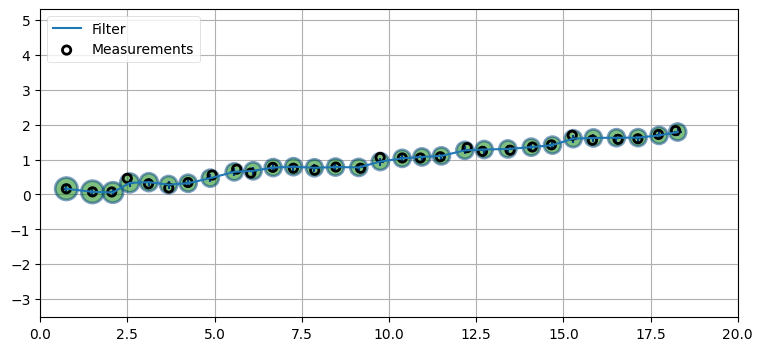

In [11]:
from   从 filterpy.stats import   进口 plot_covariance_ellipse
from kf_book.book_plots import plot_filter

R_std = 0.35
Q_std = 0.04

def tracker1():
    tracker = KalmanFilter(dim_x=4, dim_z=2)
    dt = 1.0   # time step

    tracker.F = np.array([[1, dt, 0,  0],
                          [0,  1, 0,  0],
                          [0,  0, 1, dt],
                          [0,  0, 0,  1]])
    tracker.u = 0.
    tracker.H = np.array([[1/0.3048, 0, 0, 0],
                          [0, 0, 1/0.3048, 0]])

    tracker.R = np.eye(2) * R_std**2
    q = Q_discrete_white_noise(dim=2, dt=dt, var=Q_std**2)
    tracker.Q = block_diag(q, q)
    tracker.x = np.array([[0, 0, 0, 0]]).T
    tracker.P = np.eye(4) * 500.
    return tracker

# simulate robot movement
N = 30
sensor = PosSensor((0, 0), (2, .2), noise_std=R_std)

zs = np.array([sensor.read() for _ in range(N)])

# run filter
robot_tracker = tracker1()
mu, cov, _, _ = robot_tracker.batch_filter(zs)

for x, P in zip(mu, cov):
    # covariance of x and y
    cov = np.array([[P[0, 0], P[2, 0]], 
                    [P[0, 2], P[2, 2]]])
    mean = (x[0, 0], x[2, 0])
    plot_covariance_ellipse(mean, cov=cov, fc='g', std=3, alpha=0.5)
    
#plot results
zs *= .3048 # convert to meters
plot_filter(mu[:, 0], mu[:, 2])
plot_measurements(zs[:, 0], zs[:, 1])
plt.legend(loc=2)
plt.xlim(0, 20);

I encourage you to play with this, setting $\mathbf Q$ and $\mathbf R$ to various values.  However, we did a fair amount of that sort of thing in the last chapters, and we have a lot of material to cover, so I will move on to more complicated cases where we will also have a chance to experience changing these values.我鼓励你们自己动手尝试一下，将 $\mathbf   \ mathbf。 Q   问$ 和 $\mathbf   \ mathbf。 R$ 设为不同的值。不过，我们在上几章已经做了不少这样的练习，而且我们还有很多内容要讲，所以接下来我会转向更复杂的情况，在那里我们也有机会体验改变这些值的过程。

I plotted the $3\sigma$ the covariance ellipse for $x$ and $y$ in green. Can you explain their shape? Perhaps you were expecting a tilted ellipse, as in the last chapters. If so, recall that in those chapters we were not plotting $x$ against $y$, but $x$ against $\dot x$. $x$ is correlated to $\dot x$, but $x$ is not correlated or dependent on $y$. Therefore our ellipses are not tilted. Furthermore, the noise for both $x$ and $y$ are modeled to have the same noise standard deviation. If we were to set R to, for example,我用绿色绘制了 $x$ 和 $y$ 的 $3\sigma   \σ$ 协方差椭圆。你能解释一下它们的形状吗？也许你期待的是一个倾斜的椭圆，就像在前几章中那样。如果是这样，请回想一下，在那些章节中我们绘制的是 $x$ 对 $\dot   \点 x$ 的图，而不是 $x$ 对 $y$ 的图。$x$ 与 $\dot   \点 x$ 相关，但 $x$ 与 $y$ 无关或不依赖。因此我们的椭圆没有倾斜。此外，$x$ 和 $y$ 的噪声都被建模为具有相同的噪声标准差。如果我们把 R 设为，例如，

$$\mathbf R = \begin{bmatrix}1&0\\0&.5\end{bmatrix}$$

we would be telling the Kalman filter that there is more noise in $x$ than $y$, and our ellipses would be longer than they are tall.我们会告知卡尔曼滤波器，$x$ 中的噪声比 $y$ 中的多，这样我们的椭圆就会比其高度更长。

The final value for $\mathbf P$ tells us everything we need to know about the correlation between the state variables. If we look at the diagonal alone we see the variance for each variable. In other words $\mathbf P_{0,0}$ is the variance for x, $\mathbf P_{1,1}$ is the variance for $\dot x$, $\mathbf P_{2,2}$ is the variance for y, and $\mathbf P_{3,3}$ is the variance for $\dot y$. We can extract the diagonal of a matrix using `numpy.diag()`.

In [12]:
print(np.diag(robot_tracker.P))

[0.007 0.003 0.007 0.003]


The covariance matrix contains four $2{\times}2$ matrices that you should be able to easily pick out. This is due to the correlation of $x$ to $\dot x$, and of $y$ to $\dot y$. The upper left hand side shows the covariance of $x$ to $\dot x$.协方差矩阵包含四个 $2{\times   \ *}2$ 矩阵，您应该能够轻松地将其挑出。这是由于 $x$ 与 $\dot   \点 x$ 以及 $y$ 与 $\dot   \点 y$ 之间的相关性所致。左上角显示的是 $x$ 与 $\dot   \点 x$ 的协方差。

[[0.007 0.003]
 [0.003 0.003]]


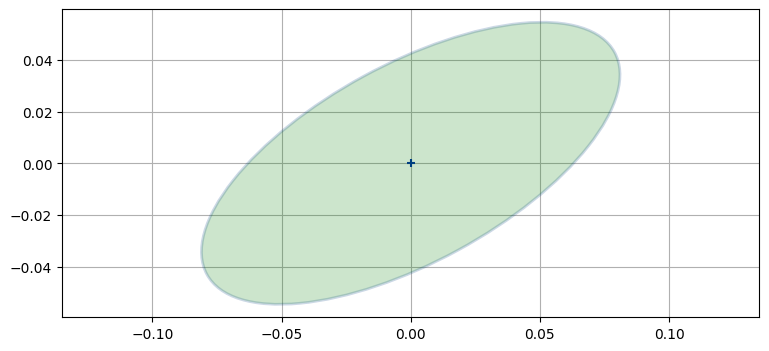

In [13]:
c = robot_tracker.P[0:2, 0:2]
print(c)
plot_covariance_ellipse((0, 0), cov=c, fc='g', alpha=0.2)

The covariance contains the data for $x$ and $\dot x$ in the upper left because of how it is organized. Recall that entries $\mathbf P_{i,j}$ and $\mathbf P_{j,i}$ contain $\sigma_i\sigma_j$.由于协方差矩阵的组织方式，$x$ 和 $\dot   \点 x$ 的数据位于左上角。请记住，$\mathbf   \ mathbf。 P_{i   我,j}$ 和 $\mathbf   \ mathbf。 P_{j,i   我}$ 的条目包含 $\sigma_i   我\sigma_j$。

Finally, let's look at the lower left side of $\mathbf P$, which is all 0s. Why 0s? Consider $\mathbf P_{3,0}$. That stores the term $\sigma_3\sigma_0$, which is the covariance between $\dot y$ and $x$. These are independent, so the term will be 0. The rest of the terms are for similarly independent variables.最后，让我们来看矩阵 $\mathbf   \ mathbf。 P$ 的左下角，那里全是 0。为什么是 0 呢？考虑 $\mathbf   \ mathbf。 P_{3,0}$。它存储的是项 $\sigma_3\sigma_0$，即 $\dot   \点 y$ 和 $x$ 之间的协方差。由于它们是相互独立的，所以该项为 0。其余各项也是类似独立变量的情况。

In [14]:
robot_tracker.P[2:4, 0:2]

array([[0., 0.],
       [0., 0.]])

## Filter Order   过滤器订单

We have only studied tracking position and velocity. It has worked well, but only because I have been selecting problems for which this is an appropriate choice. You now have enough experience with the Kalman filter to consider this in more general terms.我们仅研究了位置和速度的跟踪。效果不错，但这只是因为我一直在挑选适合这种选择的问题。现在你已经对卡尔曼滤波器有了足够的了解，可以更广泛地考虑这个问题了。

What do I mean by order? In the context of these system models it is the number of derivatives required to accurately model a system. Consider a system that does not change, such as the height of a building. There is no change, so there is no need for a derivative, and the order of the system is zero. We could express this in an equation as $x = 312.5$.我所说的“阶数”是什么意思？在这些系统模型的语境中，它指的是准确建模一个系统所需的导数数量。考虑一个不变的系统，比如一栋建筑物的高度。由于没有变化，所以不需要导数，该系统的阶数为零。我们可以通过方程 $x = 312.5$ 来表示这一点。

A first order system has a first derivative. For example, change of position is velocity, and we can write this as一阶系统具有一阶导数。例如，位置的变化是速度，我们可以将其写为

$$ v = \frac{dx}{dt}$$

which we integrate into the Newtonian equation我们将其整合进牛顿方程中

$$ x = vt + x_0.$$   $$ x = vt   x_0.$$

This is also called a *constant velocity* model, because of the assumption of a constant velocity.这也被称为“恒定速度”模型，因为其假设速度恒定不变。

A second order system has a second derivative. The second derivative of position is acceleration, with the equation

$$a = \frac{d^2x}{dt^2}$$

which we integrate into 

$$ x = \frac{1}{2}at^2 +v_0t + x_0.$$

This is also known as a *constant acceleration* model.

Another, equivalent way of looking at this is to consider the order of the polynomial. The constant acceleration model has a second derivative, so it is second order. Likewise, the polynomial $x = \frac{1}{2}at^2 +v_0t + x_0$ is second order.另一种等效的看待方式是考虑多项式的阶数。常加速度模型具有二阶导数，所以它是二阶的。同样地，多项式 $x = \frac   \裂缝分析{1}{2}at   在^2 + v_0t + x_0$ 也是二阶的。

When we design the state variables and process model we must choose the order of the system we want to model. Let's say we are tracking something with a constant velocity. No real world process is perfect, and so there will be slight variations in the velocity over short time period. You might reason that the best approach is to use a second order filter, allowing the acceleration term to deal with the slight variations in velocity. 在设计状态变量和过程模型时，我们必须选择想要建模的系统的阶数。假设我们要跟踪一个具有恒定速度的物体。现实世界中的任何过程都不可能是完美的，因此在短时间内速度会有一些微小的变化。您可能会认为，最好的方法是使用二阶滤波器，让加速度项来处理速度的微小变化。

In practice that doesn't work well. To thoroughly understand this issue let's see the effects of using a  process model that does not match the order of the system being filtered. 实际上，那样效果不佳。为了彻底理解这个问题，让我们来看看使用与被滤波系统顺序不匹配的过程模型所产生的影响。

First we need a system to filter. I'll write a class to simulate an object with constant velocity. Essentially no physical system has a truly constant velocity, so on each update we alter the velocity by a small amount. I also write a sensor to simulate Gaussian noise in a sensor. The code is below, and I plot an example run to verify that it is working correctly. 首先我们需要一个过滤系统。我会编写一个类来模拟具有恒定速度的对象。实际上，没有任何物理系统具有真正的恒定速度，所以在每次更新时，我们都会对速度进行微小的改变。我还编写了一个传感器来模拟传感器中的高斯噪声。代码如下，我绘制了一个示例运行来验证其是否正常工作。

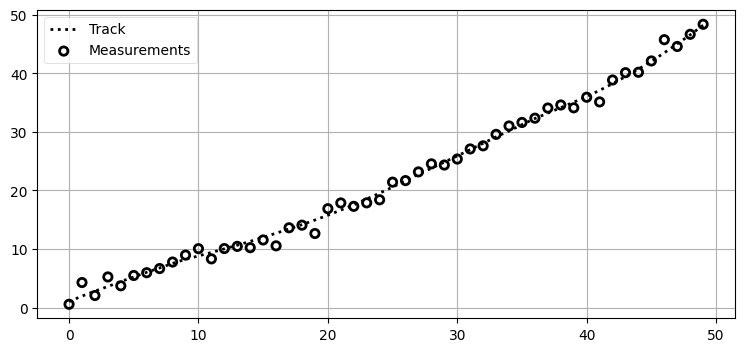

In [15]:
from kf_book.book_plots import plot_track

class ConstantVelocityObject(object):
    def __init__(self, x0=0, vel=1., noise_scale=0.06):
        self.x = x0
        self.vel = vel   自我。水平=水平
        self.noise_scale = noise_scale

    def update(self):
        self.vel += randn() * self.noise_scale
        self.x += self.vel
        return (self.x, self.vel)

def sense(x, noise_scale=1.):
    return x[0] + randn()*noise_scale

np.random.seed(124)
obj = ConstantVelocityObject()

xs, zs = [], []
for i in range(50):
    x = obj.update()
    z = sense(x)
    xs.append(x)
    zs.append(z)

xs = np.asarray(xs)

plot_track(xs[:, 0])
plot_measurements(range(len(zs)), zs)
plt.legend(loc='best');

I am satisfied with this plot. The track is not perfectly straight due to the noise that we added to the system - this could be the track of a person walking down the street, or perhaps of an aircraft being buffeted by variable winds. There is no intentional acceleration here, so we call it a constant velocity system. Again, you may be asking yourself that since there is in fact a tiny bit of acceleration going on why would we not use a second order Kalman filter to account for those changes? Let's find out.我对这个轨迹很满意。由于我们给系统添加了噪声，所以轨迹并非完全笔直——这可能是一个人在街上行走的轨迹，也可能是飞机在变化不定的风中飞行的轨迹。这里没有刻意的加速度，所以我们称其为匀速系统。您可能又会问，既然实际上确实存在一点点加速度，那为什么我们不使用二阶卡尔曼滤波器来处理这些变化呢？让我们来一探究竟。

How does one design a zero order, first order, or second order Kalman filter? We have been doing it all along, but just not using those terms. It might be slightly tedious, but I will elaborate fully on each - if the concept is clear to you feel free to skim a bit.如何设计零阶、一阶或二阶卡尔曼滤波器？我们一直在做这件事，只是没有用这些术语。这可能会有点繁琐，但我将详细阐述每一个——如果您已经理解了这个概念，可以略读一些。

### Zero Order Kalman Filter   零阶卡尔曼滤波器

A zero order Kalman filter is just a filter that tracks with no derivatives. We are tracking position, so that means we only have a state variable for position (no velocity or acceleration), and the state transition function also only accounts for position. Using the matrix formulation we would say that the state variable is零阶卡尔曼滤波器只是不考虑导数的跟踪滤波器。我们跟踪的是位置，这意味着我们只有位置的状态变量（没有速度或加速度），状态转移函数也仅考虑位置。用矩阵形式表示，我们会说状态变量是

$$\mathbf x = \begin{bmatrix}x\end{bmatrix}$$

The state transition function is very simple. There is no change in position, so we need to model $x=x$; in other words, *x* at time t+1 is the same as it was at time t. In matrix form, our state transition function is状态转移函数非常简单。位置没有变化，所以我们需要建模为 $x=x$；换句话说，时间 $t+1$ 时的 *x* 与时间 $t$ 时的 *x* 相同。以矩阵形式表示，我们的状态转移函数为

$$\mathbf F = \begin{bmatrix}1\end{bmatrix}$$

The measurement function is very easy. Recall that we need to define how to convert the state variable $\mathbf x$ into a measurement. We will assume that our measurements are positions. The state variable only contains a position, so we get测量函数非常简单。回想一下，我们需要定义如何将状态变量 $\mathbf   \ mathbf。 x$ 转换为测量值。我们假设测量值为位置。状态变量仅包含一个位置，因此我们得到

$$\mathbf H = \begin{bmatrix}1\end{bmatrix}$$

Let's write a function that constructs and returns a zero order Kalman filter.

In [16]:
def ZeroOrderKF(R, Q, P=20):
    """ Create zero order Kalman filter.
    Specify R and Q as floats."""将 R 和 Q 指定为浮点数。
    
    kf = KalmanFilter(dim_x=1, dim_z=1)
    kf.x = np.array([0.])
    kf.R *= R   kf。R *= R
    kf.Q *= Q
    kf.P *= P
    kf.F = np.eye(1)
    kf.H = np.eye(1)
    return kf   返回kf

### First Order Kalman Filter一阶卡尔曼滤波器

A first order Kalman filter tracks a first order system, such as position and velocity. We already did this for the dog tracking problem above, so this should be very clear. But let's do it again.一阶卡尔曼滤波器用于跟踪一阶系统，例如位置和速度。我们已经在上面的狗追踪问题中做过这个了，所以这应该非常清楚。但让我们再做一遍。

A first order system has position and velocity, so the state variable needs both of these. The matrix formulation could be一阶系统具有位置和速度，因此状态变量需要同时包含这两个量。矩阵形式可以是

$$ \mathbf x = \begin{bmatrix}x\\\dot x\end{bmatrix}$$

So now we have to design our state transition. The Newtonian equations for a time step are:所以现在我们必须设计我们的状态转换。一个时间步长的牛顿方程为：

$$\begin{aligned} x_t &= x_{t-1} + v\Delta t \\
 v_t &= v_{t-1}\end{aligned}$$$$v_t = v_{t - 1}$$
 
Recall that we need to convert this into the linear equation回想一下，我们需要将其转化为线性方程。

$$\begin{bmatrix}x\\\dot x\end{bmatrix} = \mathbf F\begin{bmatrix}x\\\dot x\end{bmatrix}$$

Setting   设置

$$\mathbf F = \begin{bmatrix}1 &\Delta t\\ 0 & 1\end{bmatrix}$$

gives us the equations above.

Finally, we design the measurement function. The measurement function needs to implement

$$\mathbf z = \mathbf{Hx}$$

Our sensor still only reads position, so it should take the position from the state, and 0 out the velocity and acceleration, like so:

$$\mathbf H = \begin{bmatrix}1 & 0 \end{bmatrix}$$

This function constructs and returns a first order Kalman filter.

In [17]:
def FirstOrderKF(R, Q, dt):   def 一阶卡尔曼滤波器(R, Q, dt
    """ Create first order Kalman filter. 创建一阶卡尔曼滤波器。
    Specify R and Q as floats."""将 R 和 Q 指定为浮点数。
    
    kf = KalmanFilter(dim_x=2, dim_z=1)
    kf.x = np.zeros(2)
    kf.P *= np.array([[100, 0], [0, 1]])
    kf.R *= R
    kf.Q = Q_discrete_white_noise(2, dt, Q)
    kf.F = np.array([[1., dt],
                     [0., 1]])
    kf.H = np.array([[1., 0]])
    return kf

### Second Order Kalman Filter二阶卡尔曼滤波器

A second order Kalman filter tracks a second order system, such as position, velocity and acceleration. The state variable will be二阶卡尔曼滤波器跟踪二阶系统，例如位置、速度和加速度。状态变量将是

$$ \mathbf x = \begin{bmatrix}x\\\dot x\\\ddot{x}\end{bmatrix}$$

So now we have to design our state transition. The Newtonian equations for a time step are:所以现在我们必须设计我们的状态转换。一个时间步长的牛顿方程为：

$$\begin{aligned} x_t &= x_{t-1} + v_{t-1}\Delta t + 0.5a_{t-1} \Delta t^2 \\$$\begin{aligned} x_t &= x_{t-1} + v_{t-1}\Delta t + 0.5a_{t-1} \Delta t^2 \\ \end{aligned}$$

其中，$x_t$ 表示在时刻 $t$ 的位置，$x_{t-1}$ 表示在时刻 $t-1$ 的位置，$v_{t-1}$
 v_t &= v_{t-1} + a_{t-1}\Delta t \\v_t = v_{t-1} + a_{t-1} \Delta t
 a_t &= a_{t-1}\end{aligned}$$
 
Recall that we need to convert this into the linear equation回想一下，我们需要将其转化为线性方程。

$$\begin{bmatrix}x\\\dot x\\\ddot{x}\end{bmatrix} = \mathbf F\begin{bmatrix}x\\\dot x\\\ddot{x}\end{bmatrix}$$

Setting   设置

$$\mathbf F = \begin{bmatrix}1 & \Delta t &.5\Delta t^2\\ $$\mathbf F = \begin{bmatrix}1 & \Delta t &.5\Delta t^2\\0 & 1 & \Delta t\\0 & 0 & 1\end{bmatrix}$$

翻译成中文：

$$\mathbf F = \begin
0 & 1 & \Delta t \\   0 & 1 & \ t \\
0 & 0 & 1\end{bmatrix}$$

gives us the equations above. 给出了上述方程。

Finally, we design the measurement function. The measurement function needs to implement

$$z = \mathbf{Hx}$$

Our sensor still only reads position, so it should take the position from the state, and 0 out the velocity, like so:

$$\mathbf H = \begin{bmatrix}1 & 0 & 0\end{bmatrix}$$

This function constructs and returns a second order Kalman filter.

In [18]:
def SecondOrderKF(R_std, Q, dt, P=100):
    """ Create second order Kalman filter. 
    Specify R and Q as floats."""
    
    kf = KalmanFilter(dim_x=3, dim_z=1)
    kf.x = np.zeros(3)
    kf.P[0, 0] = P
    kf.P[1, 1] = 1
    kf.P[2, 2] = 1
    kf.R *= R_std**2
    kf.Q = Q_discrete_white_noise(3, dt, Q)
    kf.F = np.array([[1., dt, .5*dt*dt],
                     [0., 1.,       dt],
                     [0., 0.,       1.]])
    kf.H = np.array([[1., 0., 0.]])
    return kf

## Evaluating Filter Order   评估滤波器阶数

Now we can run each Kalman filter against the simulation and evaluate the results. 现在我们可以针对模拟运行每个卡尔曼滤波器，并评估结果。

How do we evaluate the results? We can do this qualitatively by plotting the track and the Kalman filter output and eyeballing the results. However, a rigorous approach uses mathematics. Recall that the system covariance matrix $\mathbf P$ contains the computed variance and covariances for each of the state variables. The diagonal contains the variance. Remember that roughly 99% of all measurements fall within $3\sigma$ if the noise is Gaussian. If this is not clear please review the Gaussian chapter before continuing, as this is an important point. 我们如何评估结果？我们可以定性地通过绘制轨迹和卡尔曼滤波器输出并直观地查看结果来完成。然而，严谨的方法是使用数学。回想一下，系统协方差矩阵 $\mathbf   \ mathbf。 P$ 包含了每个状态变量的计算方差和协方差。对角线上的元素是方差。请记住，如果噪声是高斯分布的，那么大约 99% 的所有测量值都落在 $3\sigma   \σ$ 范围内。如果这一点不清楚，请在继续之前回顾一下高斯分布章节，因为这是一个重要的点。

So we can evaluate the filter by looking at the residuals between the estimated state and actual state and comparing them to the standard deviations which we derive from $\mathbf P$. If the filter is performing correctly 99% of the residuals will fall within $3\sigma$. This is true for all the state variables, not just for the position. 因此，我们可以通过观察估计状态与实际状态之间的残差，并将其与从 $\mathbf   \ mathbf。 P$ 推导出的标准差进行比较来评估滤波器。如果滤波器运行正常，99% 的残差将落在 $3\sigma   \σ$ 范围内。这适用于所有状态变量，而不仅仅是位置。

I must mention that this is only true for simulated systems. Real sensors are not perfectly Gaussian, and you may need to expand your criteria to, say, $5\sigma$ with real sensor data.

So let's run the first order Kalman filter against our first order system and access its performance. You can probably guess that it will do well, but let's look at it using the standard deviations.

First, let's write a routine to generate the noisy measurements for us.

In [19]:
def simulate_system(Q, count):
    obj = ConstantVelocityObject(x0=.0, vel=0.5, noise_scale=Q)
    xs, zs = [], []
    for i in range(count):
        x = obj.update()
        z = sense(x)
        xs.append(x)
        zs.append(z)
    return np.array(xs), np.array(zs)

And now a routine to perform the filtering and save the output in a `Saver` object.现在编写一个执行过滤操作并将输出保存到 `Saver   储蓄者` 对象中的常规程序。

In [20]:
from filterpy.common import Saver

def filter_data(kf, zs):
    s = Saver(kf)
    kf.batch_filter(zs, saver=s)
    s.to_array()
    return s

Now we are prepared to run the filter and look at the results.现在我们准备运行过滤器并查看结果。

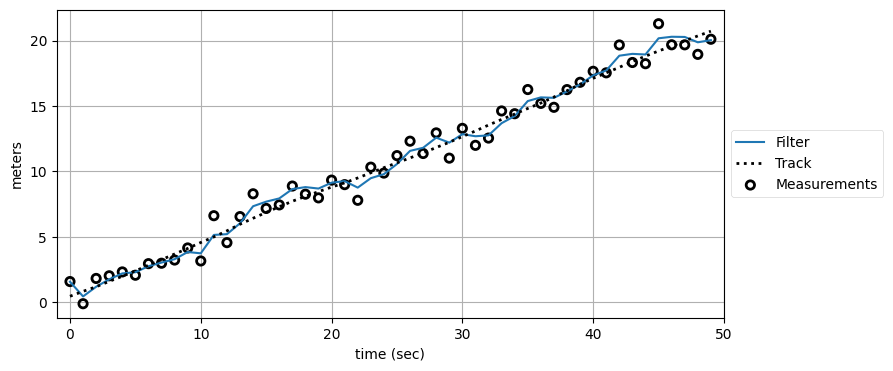

In [21]:
from kf_book.book_plots import plot_kf_output

R, Q = 1, 0.03
xs, zs = simulate_system(Q=Q, count=50)

kf = FirstOrderKF(R, Q, dt=1)
data1 = filter_data(kf, zs)

plot_kf_output(xs, data1.x, data1.z)

It looks like the filter is performing well, but it is hard to tell exactly how well. Let's look at the residuals and see if they help. We'll do this a lot, so I'll write a function to plot them.看起来滤波器运行良好，但很难确切知道其效果究竟如何。让我们看看残差，看看它们能否提供帮助。我们会经常这么做，所以我将编写一个函数来绘制它们。

In [22]:
from kf_book.book_plots import plot_residual_limits, set_labels

def plot_residuals(xs, data, col, title, y_label, stds=1):
    res = xs - data.x[:, col]
    plt.plot(res)
    plot_residual_limits(data.P[:, col, col], stds)
    set_labels(title, 'time (sec)', y_label)

<>:2: SyntaxWarning: invalid escape sequence '\s'
<>:2: SyntaxWarning: invalid escape sequence '\s'
C:\Users\12746\AppData\Local\Temp\ipykernel_42396\816674969.py:2: SyntaxWarning: invalid escape sequence '\s'
  title='First Order Position Residuals(1$\sigma$)',


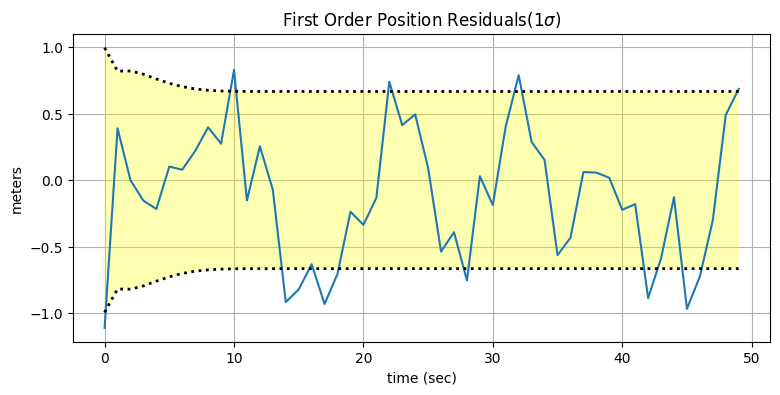

In [23]:
plot_residuals(xs[:, 0], data1, 0, 
               title='First Order Position Residuals(1$\sigma$)',
               y_label='meters')   

How do we interpret this plot? The residual is drawn as the jagged line - the difference between the measurement and the predicted position. If there was no measurement noise and the Kalman filter prediction was always perfect the residual would always be zero. So the ideal output would be a horizontal line at 0. We can see that the residual is centered around 0, so this gives us confidence that the noise is Gaussian (because the errors fall equally above and below 0). The yellow area between dotted lines show the theoretical performance of the filter for 1 standard deviations. In other words, approximately 68% of the errors should fall within the dotted lines. The residual falls within this range, so we see that the filter is performing well, and that it is not diverging.我们如何解读这个图？残差以锯齿状的线绘制出来——即测量值与预测位置之间的差值。如果不存在测量噪声且卡尔曼滤波器的预测总是完美的，那么残差将始终为零。所以理想输出应是一条位于 0 的水平线。我们可以看到残差围绕 0 分布，这让我们确信噪声是高斯分布的（因为误差在 0 上下分布均匀）。虚线之间的黄色区域显示了滤波器理论上的 1 个标准差的性能。换句话说，大约 68% 的误差应该落在虚线范围内。残差处于这个范围内，所以我们看到滤波器运行良好，并且没有发散。

Let's look at the residuals for velocity. 让我们来看一下速度的残差。

<>:2: SyntaxWarning: invalid escape sequence '\s'
<>:2: SyntaxWarning: invalid escape sequence '\s'
C:\Users\12746\AppData\Local\Temp\ipykernel_42396\3054760267.py:2: SyntaxWarning: invalid escape sequence '\s'
  title='First Order Velocity Residuals(1$\sigma$)',


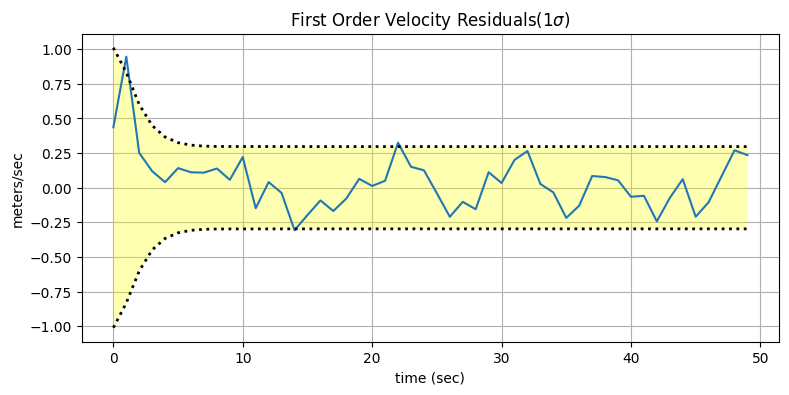

In [24]:
plot_residuals(xs[:, 1], data1, 1, 
               title='First Order Velocity Residuals(1$\sigma$)',
               y_label='meters/sec')   

Again, as expected, the residual falls within the theoretical performance of the filter, so we feel confident that the filter is well designed for this system. 再次，正如预期的那样，残差在滤波器的理论性能范围内，所以我们确信该滤波器对于此系统的设计是合理的。

Now let's do the same thing using the zero order Kalman filter. All of the code and math is largely the same, so let's just look at the results without discussing the implementation much.现在让我们用零阶卡尔曼滤波器来做同样的事情。所有的代码和数学运算基本相同，所以我们就直接看结果，不多讨论实现过程。

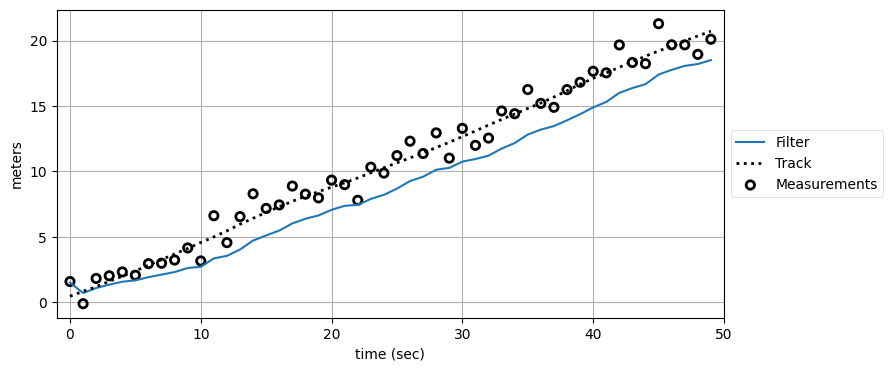

In [25]:
kf0 = ZeroOrderKF(R, Q)
data0 = filter_data(kf0, zs)
plot_kf_output(xs, data0.x, data0.z)

As we would expect, the filter has problems. Think back to the g-h filter, where we incorporated acceleration into the system. The g-h filter always lagged the input because there were not enough terms to allow the filter to adjust quickly enough to the changes in velocity. On every `predict()` step the Kalman filter assumes that there is no change in position - if the current position is 4.3 it will predict that the position at the next time period is 4.3. Of course, the actual position is closer to 5.3. The measurement, with noise, might be 5.4, so the filter chooses an estimate part way between 4.3 and 5.4, causing it to lag the actual value of 5.3 by a significant amount. This same thing happens in the next step, the next one, and so on. The filter never catches up.正如我们所料，滤波器存在问题。回想一下 g-h 滤波器，当时我们在系统中加入了加速度。g-h 滤波器总是滞后于输入，因为其项数不够，无法使滤波器足够快地适应速度的变化。在每次 `predict()   预测()` 步骤中，卡尔曼滤波器都假定位置没有变化——如果当前位置是 4.3，它会预测下一个时间周期的位置也是 4.3。当然，实际位置更接近 5.3。带有噪声的测量值可能是 5.4，所以滤波器选择了一个介于 4.3 和 5.4 之间的估计值，导致它比实际值 5.3 滞后了相当大的距离。在接下来的每一步，同样的情况都会发生，一步又一步，如此循环。滤波器永远追不上。

This raises a very important point. The assumption of 'constant' is an assumption of constant-ness between discrete samples only. The filter's output can still change over time.这提出了一个非常重要的观点。“恒定”的假设只是指在离散样本之间保持恒定，滤波器的输出仍会随时间变化。

Now let's look at the residuals. We are not tracking velocity, so we can only look at the residual for position.现在让我们来看一下残差。我们没有追踪速度，所以只能查看位置的残差。

<>:2: SyntaxWarning: invalid escape sequence '\s'
<>:2: SyntaxWarning: invalid escape sequence '\s'
C:\Users\12746\AppData\Local\Temp\ipykernel_42396\2980822654.py:2: SyntaxWarning: invalid escape sequence '\s'
  title='Zero Order Position Residuals(3$\sigma$)',


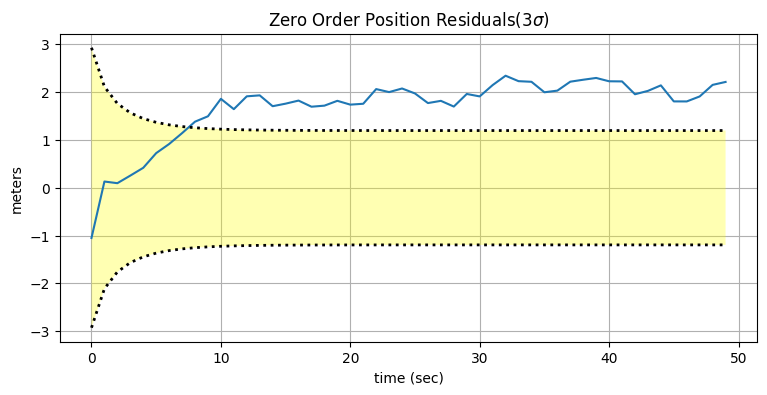

In [26]:
plot_residuals(xs[:, 0], data0, 0, 
               title='Zero Order Position Residuals(3$\sigma$)',
               y_label='meters',
               stds=3)

We can see that the filter diverges almost immediately. After a few seconds the residual exceeds the bounds of three standard deviations. It is important to understand that the covariance matrix $\mathbf P$ is only reporting the *theoretical* performance of the filter *assuming* all of the inputs are correct. In other words, this Kalman filter is diverging, but $\mathbf P$ implies that the Kalman filter's estimates are getting better and better with time because the variance is getting smaller. The filter has no way to know that you are lying to it about the system. This is sometimes referred to a *smug* filter - it is overconfident in its performance.我们可以看到滤波器几乎立刻就发散了。几秒钟后，残差就超出了三个标准差的范围。重要的是要明白协方差矩阵 $\mathbf   \ mathbf。 P$ 只是在假设所有输入都正确的情况下报告滤波器的*理论*性能。换句话说，这个卡尔曼滤波器正在发散，但 $\mathbf   \ mathbf。 P$ 却表明卡尔曼滤波器的估计随着时间的推移变得越来越准确，因为方差在减小。滤波器无法知道你在对它说谎，谎报了系统的情况。这种情况有时被称为*自满*滤波器——它对自己的性能过于自信。

In this system the divergence is immediate and striking. In many systems it will only be gradual, and/or slight. It is important to look at charts like these for your systems to ensure that the performance of the filter is within the bounds of its theoretical performance.在这个系统中，差异是立竿见影且显著的。在许多系统中，这种差异只会是渐进的，和/或细微的。重要的是要查看您系统的此类图表，以确保滤波器的性能在其理论性能范围内。

Now let's try a second order system. This might strike you as a good thing to do. After all, we know there is a bit of noise in the movement of the simulated object, which implies there is some acceleration. Why not model the acceleration with a second order model? If there is no acceleration, the acceleration should just be estimated to be 0, right?. But is that what happens? Think about it before going on.现在让我们尝试一个二阶系统。这或许会让你觉得是个不错的做法。毕竟，我们知道模拟物体的运动中存在一些噪声，这意味着存在一定的加速度。为何不用二阶模型来模拟加速度呢？如果没有加速度，加速度就应该被估计为 0，对吧？但事实果真如此吗？在继续之前，请先思考一下。

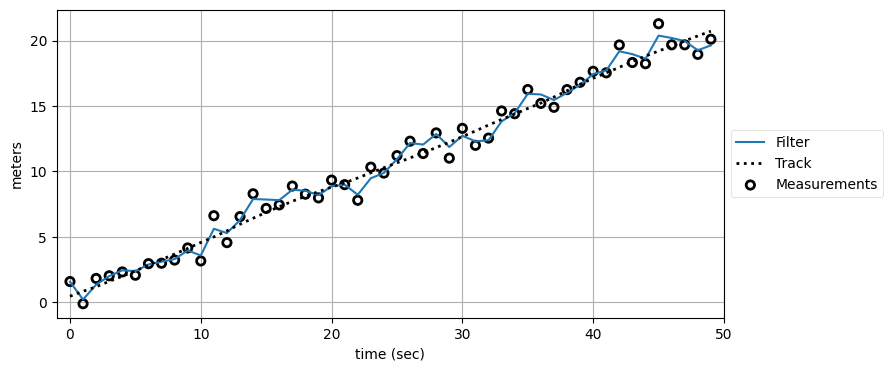

In [27]:
kf2 = SecondOrderKF(R, Q, dt=1)
data2 = filter_data(kf2, zs)
plot_kf_output(xs, data2.x, data2.z)

Did this perform as you expected?这符合您的预期吗？

We can see that second order filter performs poorly compared to the first order filter. Why? This  filter models acceleration, and so the large changes in the measurement gets interpreted as acceleration instead of noise. Thus the filter closely tracks the noise. Not only that, but it *overshoots* the noise in places if the noise is consistently above or below the track because the filter incorrectly assumes an acceleration that does not exist, and so it's prediction goes further and further away from the track on each measurement. This is not a good state of affairs.我们可以看到，二阶滤波器的表现不如一阶滤波器。为什么？此滤波器对加速度进行建模，因此测量值的大幅变化会被解读为加速度而非噪声。因此，滤波器会紧紧追踪噪声。不仅如此，如果噪声持续高于或低于轨迹，滤波器还会在某些地方“超调”噪声，因为它错误地假设了不存在的加速度，所以每次测量时其预测都会越来越偏离轨迹。这种情况很糟糕。

Still, the track doesn't look *horrible*. Let's see the story that the residuals tell. I will add a wrinkle here. The residuals for the second order system do not look terrible in that they do not diverge or exceed three standard deviations. However, it is very telling to look at the residuals for the first order vs the second order filter, so I have plotted both on the same graph.不过，这条轨迹看起来还不算太糟糕。让我们看看残差所讲述的故事。这里我要加一点复杂性。二阶系统的残差看起来不算太糟，因为它们既没有发散也没有超过三个标准差。然而，将一阶滤波器的残差与二阶滤波器的残差进行对比是非常有启发性的，所以我把它们画在了同一张图上。

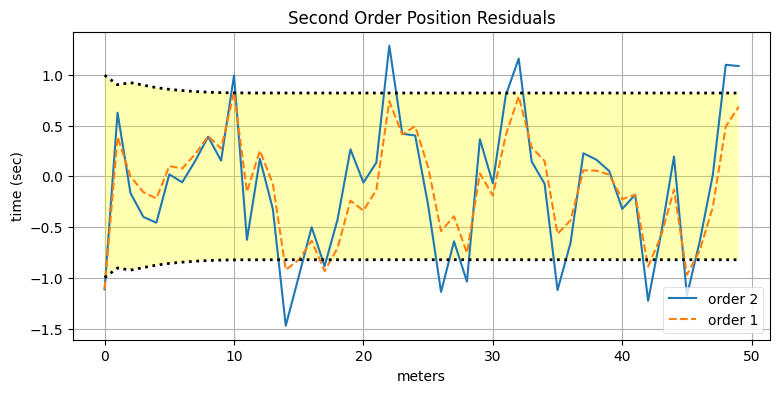

In [28]:
res2 = xs[:, 0] - data2.x[:, 0]
res1 = xs[:, 0] - data1.x[:, 0]

plt.plot(res2, label='order 2')
plt.plot(res1, ls="--", label='order 1')
plot_residual_limits(data2.P[:, 0, 0])
set_labels('Second Order Position Residuals',
           'meters', 'time (sec)')
plt.legend();

The second order position residuals are slightly worse than the residuals of the first order filter, but they still fall within the theoretical limits of the filter. There is nothing very alarming here.二阶位置残差略逊于一阶滤波器的残差，但仍处于滤波器的理论限制范围内。这里没有什么特别令人担忧的。

Now let's look at the residuals for the velocity.现在让我们来看一下速度的残差。

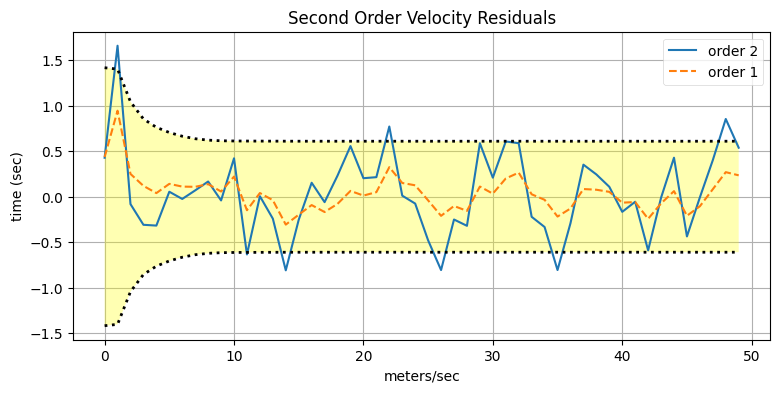

In [29]:
res2 = xs[:, 1] - data2.x[:, 1]
res1 = xs[:, 1] - data1.x[:, 1]

plt.plot(res2, label='order 2')
plt.plot(res1, ls='--', label='order 1')
plot_residual_limits(data2.P[:, 1, 1])
set_labels('Second Order Velocity Residuals', 
                      'meters/sec', 'time (sec)')
plt.legend();

Here the story is very different. While the residuals of the second order system fall within the theoretical bounds of the filter's performance, we can see that the residuals are *far* worse than for the first order filter. This is the usual result for this scenario. The filter is assuming that there is acceleration that does not exist. It mistakes noise in the measurement as acceleration and this gets added into the velocity estimate on every predict cycle. Of course the acceleration is not actually there and so the residual for the velocity is much larger than its optimum.这里的情况则截然不同。尽管二阶系统的残差在滤波器性能的理论范围内，但我们可以看到，其残差远比一阶滤波器的要糟糕得多。这是此类情况下的常见结果。滤波器假定存在实际上并不存在的加速度。它将测量中的噪声误认为是加速度，并在每次预测周期中将其加到速度估计值中。当然，加速度实际上并不存在，因此速度的残差远大于其最优值。

I have one more trick up my sleeve. We have a first order system; i.e. the velocity is more-or-less constant. Real world systems are never perfect, so of course the velocity is never exactly the same between time periods. When we use a first order filter we account for that slight variation in velocity with the *process noise*. The matrix $\mathbf Q$ is computed to account for this slight variation. If we move to a second order filter we are now accounting for the changes in velocity. Perhaps now we have no process noise, and we can set $\mathbf Q$ to zero! 我还有最后一招。我们有一个一阶系统，也就是说速度大致保持不变。现实中的系统从来都不是完美的，所以当然在不同的时间段内速度不可能完全相同。当我们使用一阶滤波器时，会用“过程噪声”来考虑这种速度的微小变化。矩阵 $\mathbf   \ mathbf。 Q   问$ 就是计算来考虑这种微小变化的。如果我们转而使用二阶滤波器，现在就要考虑速度的变化了。也许现在我们没有过程噪声了，就可以把 $\mathbf   \ mathbf。 Q   问$ 设为零！

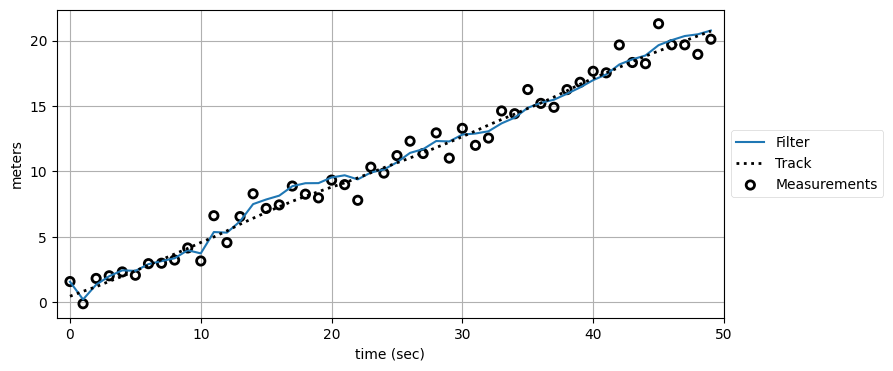

In [30]:
kf2 = SecondOrderKF(R, 0, dt=1)
data2 = filter_data(kf2, zs)
plot_kf_output(xs, data2.x, data2.z)

To my eye it looks like the filter quickly converges to the actual track. Success!在我看来，滤波器似乎很快就收敛到了实际轨迹上。成功了！

Or, maybe not. Setting the process noise to 0 tells the filter that the process model is perfect. Let's look at the performance of the filter over a longer period of time.或者，也许并非如此。将过程噪声设置为 0 是在告诉滤波器过程模型是完美的。让我们来看看滤波器在更长时间段内的性能表现。

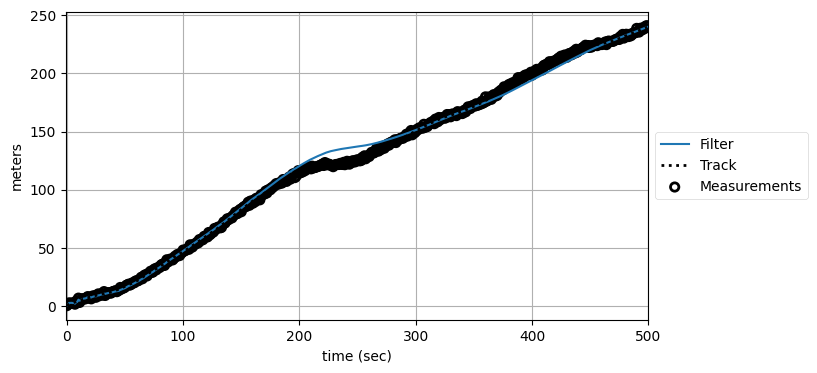

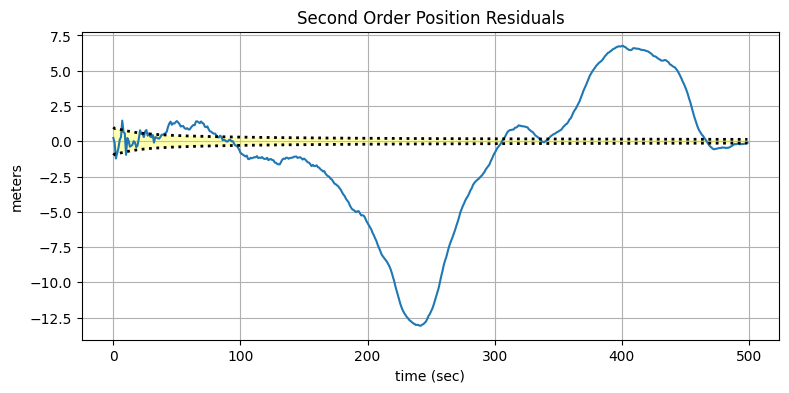

In [31]:
np.random.seed(25944)
xs500, zs500 = simulate_system(Q=Q, count=500)

kf2 = SecondOrderKF(R, 0, dt=1)
data500 = filter_data(kf2, zs500)

plot_kf_output(xs500, data500.x, data500.z)
plot_residuals(xs500[:, 0], data500, 0, 
               'Second Order Position Residuals',
               'meters') 

We can see that the performance of the filter is abysmal. We can see that in the track plot where the filter diverges from the track for an extended period of time.The residual plot makes the problem more apparent. Just before the 100th update the filter diverges sharply from the theoretical performance. It *might* be converging at the end, but I doubt it. The entire time, the filter is reporting smaller and smaller variances. **Do not trust the filter's covariance matrix to tell you if the filter is performing well**!我们可以看出滤波器的表现极差。从轨迹图中可以看出，滤波器在很长一段时间内都偏离了轨迹。残差图更清楚地表明了这一问题。在第 100 次更新前，滤波器与理论性能的偏差急剧增大。它在最后可能有所收敛，但我对此表示怀疑。整个过程中，滤波器报告的方差越来越小。**切勿相信滤波器的协方差矩阵能告诉你滤波器是否运行良好**！

Why is this happening? Recall that if we set the process noise to zero we are telling the filter to use only the process model. The measurements end up getting ignored. The physical system is *not* perfect, and so the filter is unable to adapt to this imperfect behavior. 为什么会这样？回想一下，如果我们把过程噪声设为零，就是在告诉滤波器只使用过程模型。结果测量值就被忽略了。实际系统并非完美无缺，所以滤波器无法适应这种不完美的表现。

Maybe just a really low process noise? Let's try that.也许只是过程噪声非常低？那咱们试试看。

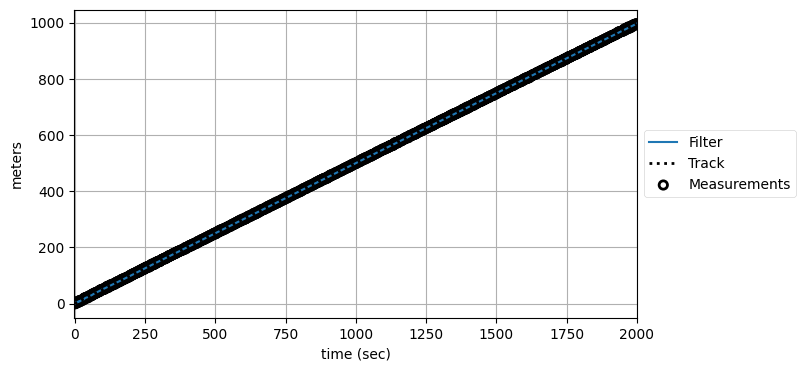

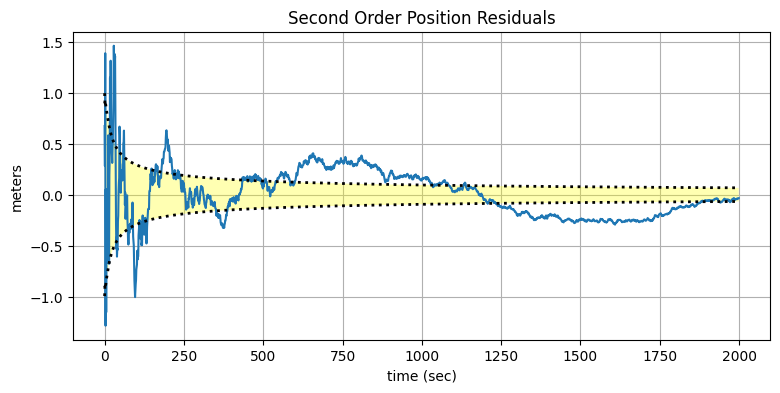

In [32]:
np.random.seed(32594)
xs2000, zs2000 = simulate_system(Q=0.0001, count=2000)

kf2 = SecondOrderKF(R, 0, dt=1)
data2000 = filter_data(kf2, zs2000)

plot_kf_output(xs2000, data2000.x, data2000.z)
plot_residuals(xs2000[:, 0], data2000, 0, 
               'Second Order Position Residuals',
               'meters') 

Again, the residual plot tells the story. The track looks very good, but the residual plot shows that the filter is diverging for significant periods of time.再次，残差图说明了一切。轨迹看起来非常不错，但残差图表明滤波器在相当长的一段时间内都在发散。

How should you think about all of this? You might argue that the last plot is 'good enough' for your application, and perhaps it is. I warn you however that a diverging filter doesn't always converge. With a different data set, or a physical system that performs differently you can end up with a filter that veers further and further away from the measurements.对于这一切您应如何思考？您或许会说最后一个图表对于您的应用来说已经“足够好了”，也许确实如此。但我还是要提醒您，发散滤波器并非总是收敛的。对于不同的数据集，或者性能不同的物理系统，您最终可能会得到一个与测量值偏差越来越大的滤波器。

Also, let's think about this in a data fitting sense. Suppose I give you two points, and tell you to fit a straight line to the points. 另外，让我们从数据拟合的角度来思考这个问题。假设我给你两个点，并让你用一条直线来拟合这两个点。

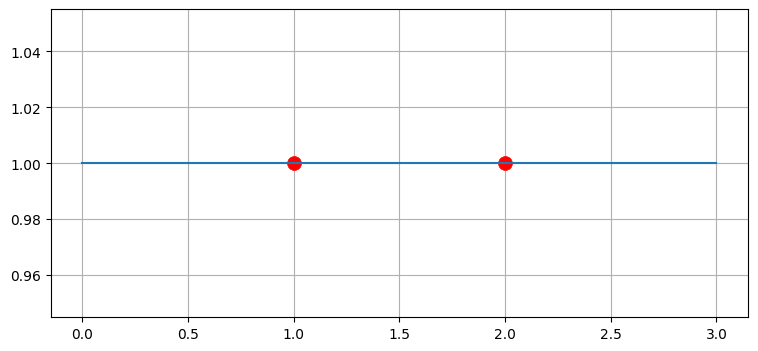

In [33]:
plt.scatter([1, 2], [1, 1], s=100, c='r')
plt.plot([0, 3], [1, 1]);

A straight line is the only possible answer. Furthermore, the answer is optimal. If I gave you more points you could use a least squares fit to find the best line, and the answer would still be optimal in a least squares sense.直线是唯一可能的答案。而且，这个答案是最优的。如果我给你更多的点，你可以用最小二乘法拟合来找到最佳直线，从最小二乘法的角度来看，答案仍然是最优的。

But suppose I told you to fit a higher order polynomial to those two points. There are an infinite number of answers to the problem. For example, an infinite number of second order parabolas pass through those points. When the Kalman filter is of higher order than your physical process it also has an infinite number of solutions to choose from. The answer is not just non-optimal, it often diverges and never recovers. 但假设我让你用一个更高阶的多项式来拟合这两个点。这个问题有无数个答案。例如，无数个二次抛物线都能通过这两个点。当卡尔曼滤波器的阶数高于你的物理过程时，它也有无数个解可供选择。答案不仅不是最优的，而且常常会发散，永远无法恢复。

For best performance you need a filter whose order matches the system's order. In many cases that will be easy to do - if you are designing a Kalman filter to read the thermometer of a freezer it seems clear that a zero order filter is the right choice. But what order should we use if we are tracking a car? Order one will work well while the car is moving in a straight line at a constant speed, but cars turn, speed up, and slow down, in which case a second order filter will perform better. That is the problem addressed in the Adaptive Filters chapter. There we will learn how to design a filter that adapts to changing order in the tracked object's behavior.要达到最佳性能，您需要一个与系统阶数相匹配的滤波器。在很多情况下，这很容易做到——如果您设计一个卡尔曼滤波器来读取冰箱的温度计，显然零阶滤波器是正确的选择。但如果我们要追踪一辆汽车，应该使用几阶滤波器呢？当汽车以恒定速度沿直线行驶时，一阶滤波器效果很好，但汽车会转弯、加速和减速，在这种情况下，二阶滤波器表现会更好。这就是自适应滤波器章节所要解决的问题。在那里，我们将学习如何设计一个能适应被追踪对象行为变化的滤波器。

With that said, a lower order filter can track a higher order process so long as you add enough process noise and you keep the discretization period small (100 samples a second are usually locally linear). The results will not be optimal, but they can still be very good, and I always reach for this tool first before trying an adaptive filter. Let's look at an example with acceleration. First, the simulation.

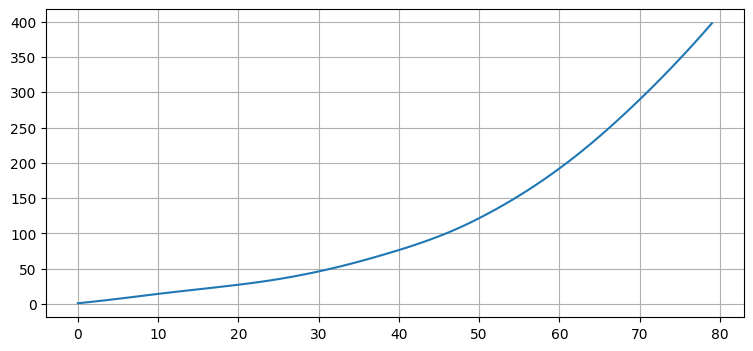

In [34]:
class ConstantAccelerationObject(object):
    def __init__(self, x0=0, vel=1., acc=0.1, acc_noise=.1):
        self.x = x0
        self.vel = vel   自我。水平=水平
        self.acc = acc
        self.acc_noise_scale = acc_noise
    
    def update(self):
        self.acc += randn() * self.acc_noise_scale       
        self.vel += self.acc
        self.x += self.vel
        return (self.x, self.vel, self.acc)
  
R, Q = 6., 0.02
def simulate_acc_system(R, Q, count):
    obj = ConstantAccelerationObject(acc_noise=Q)
    zs = []
    xs = []
    for i in range(count):
        x = obj.update()
        z = sense(x, R)
        xs.append(x)
        zs.append(z)
    return np.asarray(xs), zs

np.random.seed(124)
xs, zs = simulate_acc_system(R=R, Q=Q, count=80)
plt.plot(xs[:, 0]);

Now we will filter the data using a second order filter.现在我们将使用二阶滤波器对数据进行滤波。

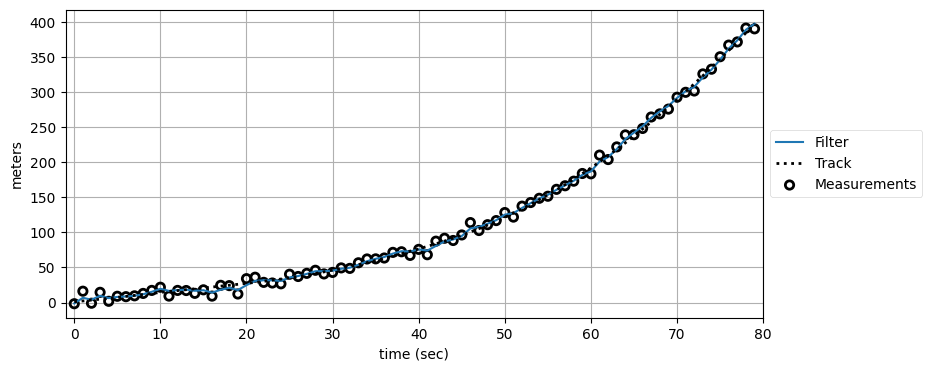

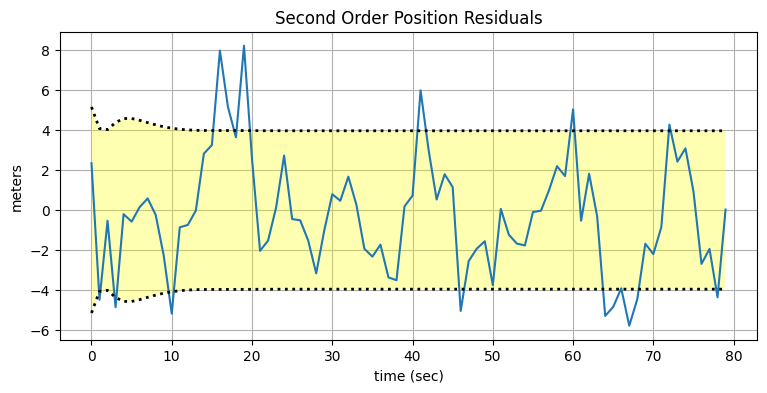

In [35]:
np.random.seed(124)
xs, zs = simulate_acc_system(R=R, Q=Q, count=80)

kf2 = SecondOrderKF(R, Q, dt=1)
data2 = filter_data(kf2, zs)

plot_kf_output(xs, data2.x, data2.z, aspect_equal=False)
plot_residuals(xs[:, 0], data2, 0, 
               'Second Order Position Residuals',
               'meters') 

We can see that the filter is performing within the theoretical limits of the filter. 我们可以看到，该滤波器的工作性能在滤波器的理论极限范围内。

Now let's use a lower order filter. As already demonstrated the lower order filter will lag the signal because it is not modeling the acceleration. However, we can account for that (to an extent) by increasing the size of the process noise. The filter will treat the acceleration as noise in the process model. The result will be suboptimal, but if designed well it will not diverge. Choosing the amount of extra process noise is not an exact science. You will have to experiment with representative data. Here, I've multiplied it by 10, and am getting good results.现在让我们使用一个低阶滤波器。正如已经展示的那样，低阶滤波器会滞后于信号，因为它没有对加速度进行建模。不过，我们可以通过增大过程噪声的大小来在一定程度上弥补这一点。滤波器会将加速度视为过程模型中的噪声。结果将不是最优的，但如果设计得当，它不会发散。选择额外的过程噪声量并非一门精确的科学。您需要使用具有代表性的数据进行试验。在这里，我将其乘以了 10，并且得到了不错的结果。

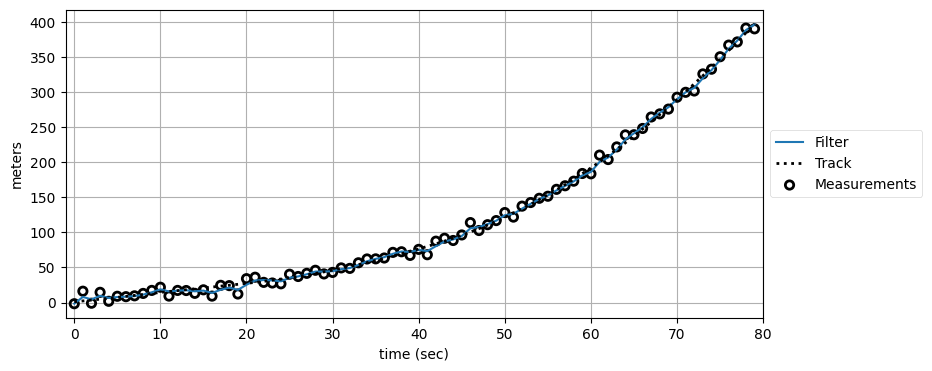

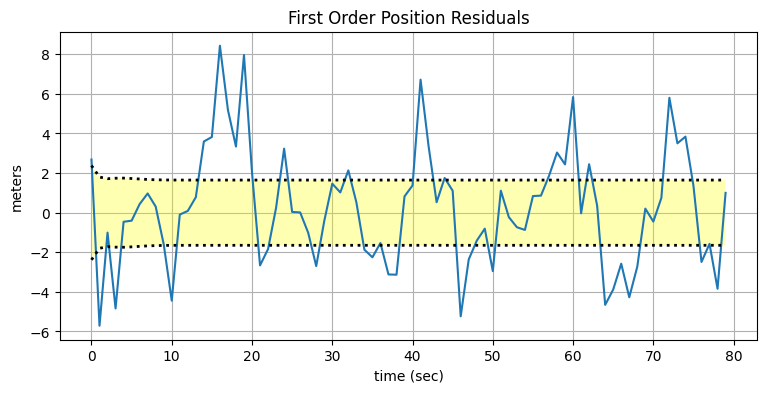

In [36]:
kf3 = FirstOrderKF(R, Q * 10, dt=1)
data3= filter_data(kf3, zs)

plot_kf_output(xs, data3.x, data3.z, aspect_equal=False)
plot_residuals(xs[:, 0], data3, 0, 
               'First Order Position Residuals',
               'meters') 

Think about what will happen if you make the process noise many times larger than it needs to be. A large process noise tells the filter to favor the measurements, so we would expect the filter to closely mimic the noise in the measurements. Let's find out.设想一下，如果将过程噪声设置得比实际所需大很多，会发生什么情况。较大的过程噪声会告诉滤波器更倾向于测量值，所以我们预计滤波器会紧密地模仿测量值中的噪声。让我们来验证一下。

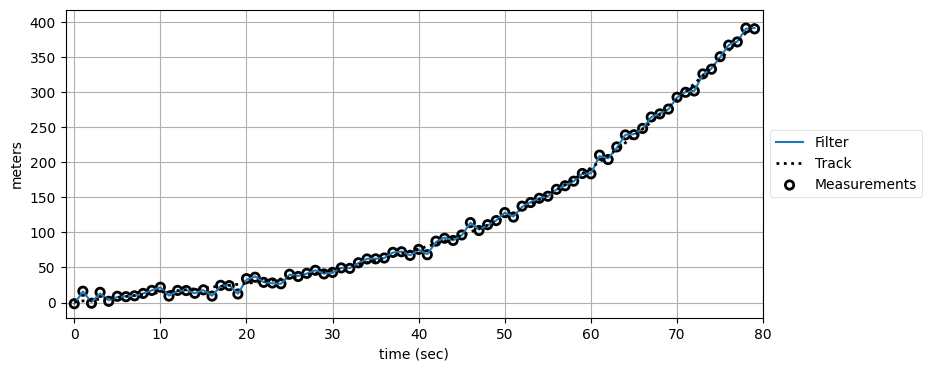

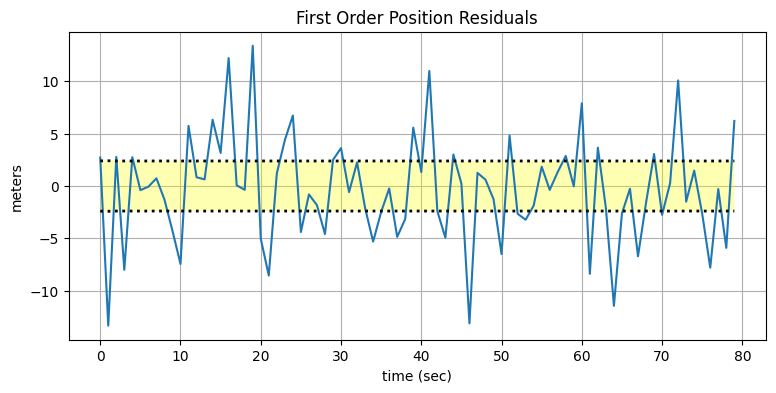

In [37]:
kf4 = FirstOrderKF(R, Q * 10000, dt=1)
data4 = filter_data(kf4, zs)

plot_kf_output(xs, data4.x, data4.z, aspect_equal=False)
plot_residuals(xs[:, 0], data4, 0, 
               'First Order Position Residuals',
               'meters') 

## Exercise: State Variable Design练习：状态变量设计

As I've mentioned, you may place the variables in $\mathbf x$ in whatever order you choose. For example, you could define a 1D constant acceleration as $\mathbf x = \begin{bmatrix}\ddot x & x & \dot x\end{bmatrix}^\mathsf T$. I can't imagine why you would want that order, but it is possible.正如我所提到的，您可以按照自己选择的任意顺序放置向量 $\mathbf   \ mathbf。 x$ 中的变量。例如，您可以将一维恒定加速度定义为 $\mathbf   \ mathbf。 x = \begin   \开始{bmatrix}\ddot x & x & \dot   \点 x\end   \结束{bmatrix}^\mathsf T$。我实在想不出您为何会想要这种顺序，但这是可行的。

Let's do something more reasonable. Design a second order filter for a robot moving in 2D, where $\mathbf x = \begin{bmatrix}x & y & \dot x & \dot y \end{bmatrix}^\mathsf T$. In this chapter we have been using $\mathbf x = \begin{bmatrix}x & \dot x & y & \dot y \end{bmatrix}^\mathsf T$.让我们来做点更合理的事。为在二维空间中移动的机器人设计一个二阶滤波器，其中 $\mathbf   \ mathbf。 x = \begin   \开始{bmatrix}x & y & \dot   \点 x & \dot   \点 y \end   \结束{bmatrix}^\mathsf T$。在本章中，我们一直使用的是 $\mathbf   \ mathbf。 x = \begin   \开始{bmatrix}x & \dot   \点 x & y & \dot   \点 y \end   \结束{bmatrix}^\mathsf T$。

Why would you choose a different ordering? As you'll see in a moment, changing the order of $\mathbf x$ changes the order of most of the rest of the filter's matrices. Depending on what data you want to inspect, such as the correlations in $\mathbf P$, various orderings of $\mathbf x$ can make that easier or more difficult.您为何会选择不同的排序方式？正如您马上就会看到的那样，改变 $\mathbf   \ mathbf。 x$ 的顺序会改变滤波器中大多数其余矩阵的顺序。根据您想要检查的数据，例如 $\mathbf   \ mathbf。 P$ 中的相关性，$\mathbf   \ mathbf。 x$ 的不同排序方式可能会使这一过程变得更容易或更困难。

Think about how to do this. What needs to change? Clearly, you just need to change the Kalman filter matrices to reflect this new design. 

Give it a try below using this boilerplate code:

```python

N = 30 # number of iterations
dt = 1.0 # time step
R_std = 0.35
Q_std = 0.04

sensor = PosSensor((0, 0), (2, .5), noise_std=R_std)
zs = np.array([sensor.read() for _ in range(N)])

tracker = KalmanFilter(dim_x=4, dim_z=2)
# assign state variables here

xs, ys = [], []
for z in zs:
    tracker.predict()
    tracker.update(z)
    xs.append(tracker.x[0])
    ys.append(tracker.x[1])
plt.plot(xs, ys);
```

### Solution   解决方案

Let's start with $\mathbf F$. With a bit of practice you should be able to just write out the matrix. If you found that difficult, then write out the set of equations for $\mathbf F$ ordering the variables as used by the state variable.我们先从 $\mathbf   \ mathbf。 F$ 开始。经过一些练习，你应该能够直接写出矩阵。如果你觉得这很难，那就写出 $\mathbf   \ mathbf。 F$ 的方程组，按照状态变量使用的顺序排列变量。

$$
x = 1x + 0y + 1\dot x\Delta t + 0 \dot y\Delta t \\x = 1x + 0y + 1\dot   \点 x\Delta   \δ t + 0 \dot   \点 y\Delta   \δ t
y = 0x + 1y + 0\dot x\Delta t + 1 \dot y\Delta t \\y = 0x + 1y + 0\dot   \点 x\Delta   \δ t + 1 \dot   \点 y\Delta   \δ t
\dot x = 0x + 0y + 1\dot x\Delta t + 0 \dot y\Delta t \\x 的变化率 = 0x  0y  1×x 的变化率×Δt  0  y 的变化率×Δt
\dot y = 0x + 0y + 0\dot x\Delta t + 1 \dot y\Delta t 
$$

We can copy out the coefficients to get我们可以把系数抄下来得到

$$\mathbf F = \begin{bmatrix}1&0&\Delta t & 0\\0&1&0&\Delta t\\0&0&1&0\\0&0&0&1\end{bmatrix}$$$$\mathbf   \ mathbf。 F = \begin   \开始{bmatrix}1&0&\Delta   & \δ t & 0\\0&1&0&\Delta   & \δ t\\0&0&1&0\\0&0&0&1\end   \结束{bmatrix}$$

矩阵 F 如下所示：

$$\mathbf F = \begin{bmatrix}1&0&\Delta t & 0\\0&1&0&\Delta t\\0&0&1&0\\0&0&0&1\end{bmatrix}$$$$\mathbf   \ mathbf。 F = \begin   \开始{bmatrix}1&0&\Delta   & \δ t & 0\\0&1&0&\Delta   & \δ t\\0&0&1&0\\0&0&0&1\end   \结束{bmatrix}$$

矩阵 F 如下所示：

$$\mathbf F = \begin{bmatrix}1&0&\Delta t & 0\\0&1&0&\Delta t\\0&0&1&0\\0&0&0&1\end{bmatrix}$$$$\mathbf   \ mathbf。 F = \begin   \开始{bmatrix}1&0&\Delta   & \δ t & 0\\0&1&0&\Delta   & \δ t\\0&0&1&0\\0&0&0&1\end   \结束{bmatrix}$$

矩阵 F 如下所示：

$$\mathbf F = \begin{bmatrix}1&0&\Delta t & 0\\0&1&0&\Delta t\\0&0&1&0\\0&0&0&1\end{bmatrix}$$$$\mathbf   \ mathbf。 F = \begin   \开始{bmatrix}1&0&\Delta   & \δ t & 0\\0&1&0&\Delta   & \δ t\\0&0&1&0\\0&0&0&1\end   \结束{bmatrix}$$

矩阵 F 如下所示：

$$\mathbf F = \begin{bmatrix}1&0&\Delta t & 0\\0&1&0&\Delta t\\0&0&1&0\\0&0&0&1\end{bmatrix}$$$$\mathbf   \ mathbf。 F = \begin   \开始{bmatrix}1&0&\Delta   & \δ t & 0\\0&1&0&\Delta   & \δ t\\0&0&1&0\\0&0&0&1\end   \结束{bmatrix}$$

矩阵 F 如下所示：

$$\mathbf F = \begin{bmatrix}1&0&\Delta t & 0\\0&1&0&\Delta t\\0&0&1&0\\0&0&0&1\end{bmatrix}$$$$\mathbf   \ mathbf。 F = \begin   \开始{bmatrix}1&0&\Delta   & \δ t & 0\\0&1&0&\Delta   & \δ t\\0&0&1&0\\0&0&0&1\end   \结束{bmatrix}$$

矩阵 F 如下所示：

$$\mathbf F = \begin{bmatrix}1&0&\Delta t & 0\\0&1&0&\Delta t\\0&0&1&0\\0&0&0&1\end{bmatrix}$$$$\mathbf   \ mathbf。 F = \begin   \开始{bmatrix}1&0&\Delta   & \δ t & 0\\0&1&0&\Delta   & \δ t\\0&0&1&0\\0&0&0&1\end   \结束{bmatrix}$$

矩阵 F 如下所示：

$$\mathbf F = \begin{bmatrix}1&0&\Delta t & 0\\0&1&0&\Delta t\\0&0&1&0\\0&0&0&1\end{bmatrix}$$$$\mathbf   \ mathbf。 F = \begin   \开始{bmatrix}1&0&\Delta   & \δ t & 0\\0&1&0&\Delta   & \δ t\\0&0&1&0\\0&0&0&1\end   \结束{bmatrix}$$

矩阵 F 如下所示：

$$\mathbf F = \begin{bmatrix}1&0&\Delta t & 0\\0&1&0&\Delta t\\0&0&1&0\\0&0&0&1\end{bmatrix}$$$$\mathbf   \ mathbf。 F = \begin   \开始{bmatrix}1&0&\Delta   & \δ t & 0\\0&1&0&\Delta   & \δ t\\0&0&1&0\\0&0&0&1\end   \结束{bmatrix}$$

矩阵 F 如下所示：

$$\mathbf F = \begin{bmatrix}1&0&\Delta t & 0\\0&1&0&\Delta t\\0&0&1&0\\0&0&0&1\end{bmatrix}$$$$\mathbf   \ mathbf。 F = \begin   \开始{bmatrix}1&0&\Delta   & \δ t & 0\\0&1&0&\Delta   & \δ t\\0&0&1&0\\0&0&0&1\end   \结束{bmatrix}$$

矩阵 F 如下所示：

$$\mathbf F = \begin{bmatrix}1&0&\Delta t & 0\\0&1&0&\Delta t\\0&0&1&0\\0&0&0&1\end{bmatrix}$$$$\mathbf   \ mathbf。 F = \begin   \开始{bmatrix}1&0&\Delta   & \δ t & 0\\0&1&0&\Delta   & \δ t\\0&0&1&0\\0&0&0&1\end   \结束{bmatrix}$$

矩阵 F 如下所示：

$$\mathbf F = \begin{bmatrix}1&0&\Delta t & 0\\0&1&0&\Delta t\\0&0&1&0\\0&0&0&1\end{bmatrix}$$$$\mathbf   \ mathbf。 F = \begin   \开始{bmatrix}1&0&\Delta   & \δ t & 0\\0&1&0&\Delta   & \δ t\\0&0&1&0\\0&0&0&1\end   \结束{bmatrix}$$

矩阵 F 如下所示：

$$\mathbf F = \begin{bmatrix}1&0&\Delta t & 0\\0&1&0&\Delta t\\0&0&1&0\\0&0&0&1\end{bmatrix}$$$$\mathbf   \ mathbf。 F = \begin   \开始{bmatrix}1&0&\Delta   & \δ t & 0\\0&1&0&\Delta   & \δ t\\0&0&1&0\\0&0&0&1\end   \结束{bmatrix}$$

矩阵 F 如下所示：

$$\mathbf F = \begin{bmatrix}1&0&\Delta t & 0\\0&1&0&\Delta t\\0&0&1&0\\0&0&0&1\end{bmatrix}$$$$\mathbf   \ mathbf。 F = \begin   \开始{bmatrix}1&0&\Delta   & \δ t & 0\\0&1&0&\Delta   & \δ t\\0&0&1&0\\0&0&0&1\end   \结束{bmatrix}$$

矩阵 F 如下所示：

$$\mathbf F = \begin{bmatrix}1&0&\Delta t & 0\\0&1&0&\Delta t\\0&0&1&0\\0&0&0&1\end{bmatrix}$$$$\mathbf   \ mathbf。 F = \begin   \开始{bmatrix}1&0&\Delta   & \δ t & 0\\0&1&0&\Delta   & \δ t\\0&0&1&0\\0&0&0&1\end   \结束{bmatrix}$$

矩阵 F 如下所示：

$$\mathbf F = \begin{bmatrix}1&0&\Delta t & 0\\0&1&0&\Delta t\\0&0&1&0\\0&0&0&1\end{bmatrix}$$$$\mathbf   \ mathbf。 F = \begin   \开始{bmatrix}1&0&\Delta   & \δ t & 0\\0&1&0&\Delta   & \δ t\\0&0&1&0\\0&0&0&1\end   \结束{bmatrix}$$

矩阵 F 如下所示：

$$\mathbf F = \begin{bmatrix}1&0&\Delta t & 0\\0&1&0&\Delta t\\0&0&1&0\\0&0&0&1\end{bmatrix}$$$$\mathbf   \ mathbf。 F = \begin   \开始{bmatrix}1&0&\Delta   & \δ t & 0\\0&1&0&\Delta   & \δ t\\0&0&1&0\\0&0&0&1\end   \结束{bmatrix}$$

矩阵 F 如下所示：

$$\mathbf F = \begin{bmatrix}1&0&\Delta t & 0\\0&1&0&\Delta t\\0&0&1&0\\0&0&0&1\end{bmatrix}$$$$\mathbf   \ mathbf。 F = \begin   \开始{bmatrix}1&0&\Delta   & \δ t & 0\\0&1&0&\Delta   & \δ t\\0&0&1&0\\0&0&0&1\end   \结束{bmatrix}$$

矩阵 F 如下所示：

$$\mathbf F = \begin{bmatrix}1&0&\Delta t & 0\\0&1&0&\Delta t\\0&0&1&0\\0&0&0&1\end{bmatrix}$$$$\mathbf   \ mathbf。 F = \begin   \开始{bmatrix}1&0&\Delta   & \δ t & 0\\0&1&0&\Delta   & \δ t\\0&0&1&0\\0&0&0&1\end   \结束{bmatrix}$$

矩阵 F 如下所示：

$$\mathbf F = \begin{bmatrix}1&0&\Delta t & 0\\0&1&0&\Delta t\\0&0&1&0\\0&0&0&1\end{bmatrix}$$$$\mathbf   \ mathbf。 F = \begin   \开始{bmatrix}1&0&\Delta   & \δ t & 0\\0&1&0&\Delta   & \δ t\\0&0&1&0\\0&0&0&1\end   \结束{bmatrix}$$

矩阵 F 如下所示：

$$\mathbf F = \begin{bmatrix}1&0&\Delta t & 0\\0&1&0&\Delta t\\0&0&1&0\\0&0&0&1\end{bmatrix}$$$$\mathbf   \ mathbf。 F = \begin   \开始{bmatrix}1&0&\Delta   & \δ t & 0\\0&1&0&\Delta   & \δ t\\0&0&1&0\\0&0&0&1\end   \结束{bmatrix}$$

矩阵 F 如下所示：

$$\mathbf F = \begin{bmatrix}1&0&\Delta t & 0\\0&1&0&\Delta t\\0&0&1&0\\0&0&0&1\end{bmatrix}$$$$\mathbf   \ mathbf。 F = \begin   \开始{bmatrix}1&0&\Delta   & \δ t & 0\\0&1&0&\Delta   & \δ t\\0&0&1&0\\0&0&0&1\end   \结束{bmatrix}$$

矩阵 F 如下所示：

$$\mathbf F = \begin{bmatrix}1&0&\Delta t & 0\\0&1&0&\Delta t\\0&0&1&0\\0&0&0&1\end{bmatrix}$$$$\mathbf   \ mathbf。 F = \begin   \开始{bmatrix}1&0&\Delta   & \δ t & 0\\0&1&0&\Delta   & \δ t\\0&0&1&0\\0&0&0&1\end   \结束{bmatrix}$$

矩阵 F 如下所示：

$$\mathbf F = \begin{bmatrix}1&0&\Delta t & 0\\0&1&0&\Delta t\\0&0&1&0\\0&0&0&1\end{bmatrix}$$$$\mathbf   \ mathbf。 F = \begin   \开始{bmatrix}1&0&\Delta   & \δ t & 0\\0&1&0&\Delta   & \δ t\\0&0&1&0\\0&0&0&1\end   \结束{bmatrix}$$

矩阵 F 如下所示：

$$\mathbf F = \begin{bmatrix}1&0&\Delta t & 0\\0&1&0&\Delta t\\0&0&1&0\\0&0&0&1\end{bmatrix}$$$$\mathbf   \ mathbf。 F = \begin   \开始{bmatrix}1&0&\Delta   & \δ t & 0\\0&1&0&\Delta   & \δ t\\0&0&1&0\\0&0&0&1\end   \结束{bmatrix}$$

矩阵 F 如下所示：

$$\mathbf F = \begin{bmatrix}1&0&\Delta t & 0\\0&1&0&\Delta t\\0&0&1&0\\0&0&0&1\end{bmatrix}$$$$\mathbf   \ mathbf。 F = \begin   \开始{bmatrix}1&0&\Delta   & \δ t & 0\\0&1&0&\Delta   & \δ t\\0&0&1&0\\0&0&0&1\end   \结束{bmatrix}$$

矩阵 F 如下所示：

$$\mathbf F = \begin{bmatrix}1&0&\Delta t & 0\\0&1&0&\Delta t\\0&0&1&0\\0&0&0&1\end{bmatrix}$$$$\mathbf   \ mathbf。 F = \begin   \开始{bmatrix}1&0&\Delta   & \δ t & 0\\0&1&0&\Delta   & \δ t\\0&0&1&0\\0&0&0&1\end   \结束{bmatrix}$$

矩阵 F 如下所示：

$$\mathbf F = \begin{bmatrix}1&0&\Delta t & 0\\0&1&0&\Delta t\\0&0&1&0\\0&0&0&1\end{bmatrix}$$$$\mathbf   \ mathbf。 F = \begin   \开始{bmatrix}1&0&\Delta   & \δ t & 0\\0&1&0&\Delta   & \δ t\\0&0&1&0\\0&0&0&1\end   \结束{bmatrix}$$

矩阵 F 如下所示：

$$\mathbf F = \begin{bmatrix}1&0&\Delta t & 0\\0&1&0&\Delta t\\0&0&1&0\\0&0&0&1\end{bmatrix}$$$$\mathbf   \ mathbf。 F = \begin   \开始{bmatrix}1&0&\Delta   & \δ t & 0\\0&1&0&\Delta   & \δ t\\0&0&1&0\\0&0&0&1\end   \结束{bmatrix}$$

矩阵 F 如下所示：

$$\mathbf F = \begin{bmatrix}1&0&\Delta t & 0\\0&1&0&\Delta t\\0&0&1&0\\0&0&0&1\end{bmatrix}$$$$\mathbf   \ mathbf。 F = \begin   \开始{bmatrix}1&0&\Delta   & \δ t & 0\\0&1&0&\Delta   & \δ t\\0&0&1&0\\0&0&0&1\end   \结束{bmatrix}$$

矩阵 F 如下所示：

$$\mathbf F = \begin{bmatrix}1&0&\Delta t & 0\\0&1&0&\Delta t\\0&0&1&0\\0&0&0&1\end{bmatrix}$$$$\mathbf   \ mathbf。 F = \begin   \开始{bmatrix}1&0&\Delta   & \δ t & 0\\0&1&0&\Delta   & \δ t\\0&0&1&0\\0&0&0&1\end   \结束{bmatrix}$$

矩阵 F 如下所示：

$$\mathbf F = \begin{bmatrix}1&0&\Delta t & 0\\0&1&0&\Delta t\\0&0&1&0\\0&0&0&1\end{bmatrix}$$$$\mathbf   \ mathbf。 F = \begin   \开始{bmatrix}1&0&\Delta   & \δ t & 0\\0&1&0&\Delta   & \δ t\\0&0&1&0\\0&0&0&1\end   \结束{bmatrix}$$

矩阵 F 如下所示：

$$\mathbf F = \begin{bmatrix}1&0&\Delta t & 0\\0&1&0&\Delta t\\0&0&1&0\\0&0&0&1\end{bmatrix}$$$$\mathbf   \ mathbf。 F = \begin   \开始{bmatrix}1&0&\Delta   & \δ t & 0\\0&1&0&\Delta   & \δ t\\0&0&1&0\\0&0&0&1\end   \结束{bmatrix}$$

矩阵 F 如下所示：

$$\mathbf F = \begin{bmatrix}1&0&\Delta t & 0\\0&1&0&\Delta t\\0&0&1&0\\0&0&0&1\end{bmatrix}$$$$\mathbf   \ mathbf。 F = \begin   \开始{bmatrix}1&0&\Delta   & \δ t & 0\\0&1&0&\Delta   & \δ t\\0&0&1&0\\0&0&0&1\end   \结束{bmatrix}$$

矩阵 F 如下所示：

$$\mathbf F = \begin{bmatrix}1&0&\Delta t & 0\\0&1&0&\Delta t\\0&0&1&0\\0&0&0&1\end{bmatrix}$$$$\mathbf   \ mathbf。 F = \begin   \开始{bmatrix}1&0&\Delta   & \δ t & 0\\0&1&0&\Delta   & \δ t\\0&0&1&0\\0&0&0&1\end   \结束{bmatrix}$$

矩阵 F 如下所示：

$$\mathbf F = \begin{bmatrix}1&0&\Delta t & 0\\0&1&0&\Delta t\\0&0&1&0\\0&0&0&1\end{bmatrix}$$$$\mathbf   \ mathbf。 F = \begin   \开始{bmatrix}1&0&\Delta   & \δ t & 0\\0&1&0&\Delta   & \δ t\\0&0&1&0\\0&0&0&1\end   \结束{bmatrix}$$

矩阵 F 如下所示：

$$\mathbf F = \begin{bmatrix}1&0&\Delta t & 0\\0&1&0&\Delta t\\0&0&1&0\\0&0&0&1\end{bmatrix}$$$$\mathbf   \ mathbf。 F = \begin   \开始{bmatrix}1&0&\Delta   & \δ t & 0\\0&1&0&\Delta   & \δ t\\0&0&1&0\\0&0&0&1\end   \结束{bmatrix}$$

矩阵 F 如下所示：

$$\mathbf F = \begin{bmatrix}1&0&\Delta t & 0\\0&1&0&\Delta t\\0&0&1&0\\0&0&0&1\end{bmatrix}$$$$\mathbf   \ mathbf。 F = \begin   \开始{bmatrix}1&0&\Delta   & \δ t & 0\\0&1&0&\Delta   & \δ t\\0&0&1&0\\0&0&0&1\end   \结束{bmatrix}$$

矩阵 F 如下所示：

$$\mathbf F = \begin{bmatrix}1&0&\Delta t & 0\\0&1&0&\Delta t\\0&0&1&0\\0&0&0&1\end{bmatrix}$$$$\mathbf   \ mathbf。 F = \begin   \开始{bmatrix}1&0&\Delta   & \δ t & 0\\0&1&0&\Delta   & \δ t\\0&0&1&0\\0&0&0&1\end   \结束{bmatrix}$$

矩阵 F 如下所示：

$$\mathbf F = \begin{bmatrix}1&0&\Delta t & 0\\0&1&0&\Delta t\\0&0&1&0\\0&0&0&1\end{bmatrix}$$$$\mathbf   \ mathbf。 F = \begin   \开始{bmatrix}1&0&\Delta   & \δ t & 0\\0&1&0&\Delta   & \δ t\\0&0&1&0\\0&0&0&1\end   \结束{bmatrix}$$

矩阵 F 如下所示：

$$\mathbf F = \begin{bmatrix}1&0&\Delta t & 0\\0&1&0&\Delta t\\0&0&1&0\\0&0&0&1\end{bmatrix}$$$$\mathbf   \ mathbf。 F = \begin   \开始{bmatrix}1&0&\Delta   & \δ t & 0\\0&1&0&\Delta   & \δ t\\0&0&1&0\\0&0&0&1\end   \结束{bmatrix}$$

矩阵 F 如下所示：

$$\mathbf F = \begin{bmatrix}1&0&\Delta t & 0\\0&1&0&\Delta t\\0&0&1&0\\0&0&0&1\end{bmatrix}$$$$\mathbf F = \begin{bmatrix}1&0&\Delta t & 0\\0&1&0&\Delta t\\0&0&1&0\\0&0&0&1\end{bmatrix}$$

矩阵 F 如下所示：

$$\mathbf F = \begin{bmatrix}1&0&\Delta t & 0\\0&1&0&\Delta t\\0&0&1&0\\0&0&0&1\end{bmatrix}$$

The state noise also requires shuffling things around. First, figure out how it should be arranged for the state variable ordering. This can be easier if you write the state variables vertically and horizontally across the matrix to see how they pair up. This is hard to do in Jupyter notebook, so I will forgo it here.状态噪声也需要重新排列一下。首先，确定状态变量的顺序应如何排列。如果将状态变量在矩阵中纵向和横向排列，会更容易看出它们是如何配对的。这在 Jupyter 笔记本中很难实现，所以这里就不演示了。

$$\mathbf Q = 
\begin{bmatrix}
\sigma_x^2 & \sigma_{xy} & \sigma_{x\dot x} & \sigma_{x\dot y} \\
\sigma_{yx} & \sigma_y^2 & \sigma_{y\dot x} & \sigma_{y\dot y} \\
\sigma_{\dot x x} & \sigma_{\dot x y} & \sigma_{\dot x}^2 & \sigma_{\dot x \dot y} \\
\sigma_{\dot y x} & \sigma_{\dot y y} & \sigma_{\dot y \dot x} & \sigma_{\dot y}^2
\end{bmatrix}
$$

There is no correlation between $x$ and $y$, so we can set terms with both to zero

$$\mathbf Q = 
\begin{bmatrix}
\sigma_x^2 & 0 & \sigma_{x\dot x} & 0 \\
0 & \sigma_y^2 & 0 & \sigma_{y\dot y} \\
\sigma_{\dot x x} & 0 & \sigma_{\dot x}^2 & 0 \\
0 & \sigma_{\dot y y} & 0 & \sigma_{\dot y}^2
\end{bmatrix}
$$

Now that you see this you can see the pattern and perhaps design $\mathbf Q$ more quickly.

`Q_discrete_white_noise` generates a matrix with a different ordering, but we can just copy terms from it, which we will see in the code below.

Now let's design $\mathbf H$. It converts the state $\begin{bmatrix}x & y & \dot x & \dot y \end{bmatrix}^\mathsf T$ into the measurement $\mathbf z = \begin{bmatrix}z_x & z_y\end{bmatrix}^\mathsf T$.

$$
\begin{aligned}
\mathbf{Hx} &= \mathbf z \\
\begin{bmatrix}?&?&?&?\\?&?&?&?\end{bmatrix}\begin{bmatrix}x \\ y \\ \dot x \\ \dot y \end{bmatrix} &= \begin{bmatrix}z_x \\ z_y\end{bmatrix}
\end{aligned}
$$

Now it should be easy to fill in the matrix:
$$
\begin{bmatrix}1&0&0&0\\0&1&0&0\end{bmatrix}\begin{bmatrix}x \\ y \\ \dot x \\ \dot y \end{bmatrix} = \begin{bmatrix}z_x \\ z_y\end{bmatrix}
$$

The measurement $\mathbf z = \begin{bmatrix}z_x & z_y\end{bmatrix}^\mathsf T$ has not changed so $\mathbf R$ does not change.

Finally, $\mathbf P$. It uses the same ordering as $\mathbf Q$, so it is already designed for us.

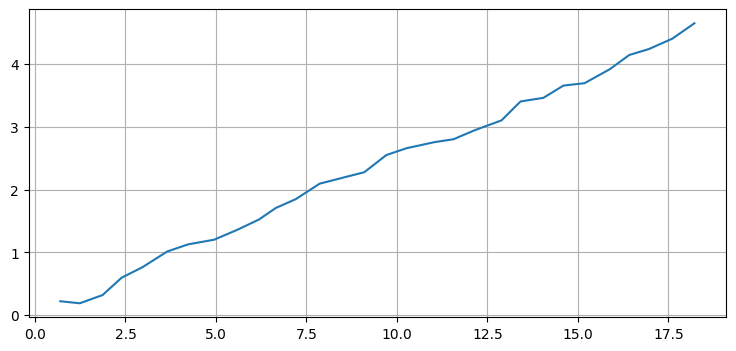

In [38]:
N = 30 # number of iterations
dt = 1.0 # time step
R_std = 0.35
Q_std = 0.04

M_TO_FT = 1 / 0.3048

sensor = PosSensor((0, 0), (2, .5), noise_std=R_std)
zs = np.array([sensor.read() for _ in range(N)])

tracker = KalmanFilter(dim_x=4, dim_z=2)

tracker.F = np.array([[1, 0, dt,  0],
                      [0, 1,  0, dt],
                      [0, 0,  1,  0],
                      [0, 0,  0,  1]])

tracker.H = np.array([[M_TO_FT, 0, 0, 0],
                      [0, M_TO_FT, 0, 0]])

tracker.R = np.eye(2) * R_std**2
q = Q_discrete_white_noise(dim=2, dt=dt, var=Q_std**2)
tracker.Q[0,0] = q[0,0]
tracker.Q[1,1] = q[0,0]
tracker.Q[2,2] = q[1,1]
tracker.Q[3,3] = q[1,1]
tracker.Q[0,2] = q[0,1]
tracker.Q[2,0] = q[0,1]
tracker.Q[1,3] = q[0,1]
tracker.Q[3,1] = q[0,1]

tracker.x = np.array([[0, 0, 0, 0]]).T
tracker.P = np.eye(4) * 500.

xs, ys = [], []
for z in zs:
    tracker.predict()
    tracker.update(z)
    xs.append(tracker.x[0])
    ys.append(tracker.x[1])
plt.plot(xs, ys);

## Detecting and Rejecting Bad Measurement检测并剔除不良测量值

The Kalman filter provides no way to detect and reject a bad measurement. Suppose you are tracking aircraft, and you receive a measurement 100km away from the aircraft's current position. If you call update with that value the new estimate will be skewed radically towards the measurement.卡尔曼滤波器无法检测和排除错误的测量值。假设您正在追踪一架飞机，而您收到的测量值与飞机当前的位置相差 100 公里。如果您用该值调用更新函数，新的估计值将会严重偏向于该测量值。

I'll run a simulation to give us a concrete example. After 100 epoch's I'll do an update with a measurement equal to twice the current position. `filterpy.common` provides `kinematic_kf` which creates a linear kinematic filter of arbitrary dimension and order. I'll use it here to keep the code tidy, I don't use it in the rest of the book because I want you to get lots of practice writing filters.我将运行一个模拟来为我们提供一个具体的例子。在 100 个周期后，我将进行一次更新，测量值等于当前位置的两倍。`filterpy.common` 提供了 `kinematic_kf`，它可以创建任意维度和阶数的线性运动学滤波器。在这里我将使用它来保持代码整洁，但在本书的其余部分我不使用它，因为我想让您多练习编写滤波器。

In [39]:
from filterpy.common import kinematic_kf

kf = kinematic_kf(dim=2, order=1, dt=1.0, order_by_dim=False)
kf.Q = np.diag([0, 0, .003, .003])
kf.x = np.array([[1., 1., 0., 0.]]).T
kf.R = np.diag([0.03, 0.21]) # use different errors

for i in range(101):
    kf.predict()
    kf.update(np.array([[i*.05, i*.05]])) # around 200 kph

p0 = kf.x[0:2]

kf.predict()
prior = kf.x
z = kf.x[0:2]*2
kf.update(z)
p1 = kf.x[0:2]

# compute error of measurement from prior
y = np.abs(z - kf.H @ prior)
dist = np.linalg.norm(y)

np.set_printoptions(precision=2, suppress=True)

print(f'bad measurement       : {z.T} km')
print(f'before bad measurement: {p0.T} km')
print(f'after bad measurement : {p1.T} km')
print(f'estimate shift        : {np.linalg.norm(p1 - prior[:2]):.1f} km')
print(f'distance from prior   : {dist:.1f} km')

bad measurement       : [[10.1 10.1]] km
before bad measurement: [[5. 5.]] km
after bad measurement : [[7.84 7.01]] km
estimate shift        : 3.4 km
distance from prior   : 7.1 km


`kinematic_kf`? What's that? `filterpy.common` provides `kinematic_kf` to allow you to create a linear kinematic filter of arbitrary dimension and order. I don't use it in this book because I want you to gain a lot of experience creating Kalman filters. I used it here just to keep my example short and to expose you to this part of the library.`kinematic_kf`？这是什么？`filterpy.common` 提供了 `kinematic_kf`，以便您能够创建任意维度和阶数的线性运动学滤波器。我在本书中没有使用它，因为我希望您能获得大量创建卡尔曼滤波器的经验。我在这里使用它只是为了使示例简短，并让您了解该库的这一部分。

Back on topic. As you can see the estimate jumped 3.4 km, and the error between the prediction (prior) and the measurement is over 7 km.回到正题。如您所见，估计值跃升了 3.4 千米，而预测值（先验值）与测量值之间的误差超过了 7 千米。

What can we do to avoid this? Our first thought might be to just add a check if the prior is far from the measurement. Why the prior and not the current estimate? Because after the update the estimate could now be quite close to the bad measurement, although it isn't in this case.我们能做些什么来避免这种情况呢？我们的第一反应可能是添加一个检查，看看先验值是否与测量值相差甚远。为什么是先验值而不是当前估计值呢？因为在更新之后，估计值可能会非常接近错误的测量值，尽管在这个例子中并非如此。

Note that while I could have just written `prior[0:2] - z` to get the error, I used the mathematically correct $\mathbf z - \mathbf{Hx}$ to compute the error. This is just for illustration; the Kalman filter class stores the innovation in `KalmanFilter.y`. I use it instead of the value I computed above to illustrate this:请注意，虽然我本可以直接写 `prior[0:2] - z   先验[00:2]- z` 来获取误差，但我使用了数学上正确的 $\mathbf   \ mathbf。 z - \mathbf   \ mathbf。{Hx}$ 来计算误差。这只是为了说明；卡尔曼滤波器类将新息存储在 `KalmanFilter.y` 中。我用它而不是上面计算的值来说明这一点：

In [40]:
print(f'error = {np.linalg.norm(kf.y):.1f} km, at a speed of {dist*3600:.0f} kph')

error = 7.1 km, at a speed of 25710 kph


In this example the measurement is nearly 7 km away from the predicted position. That sounds "far". Is it? It could be far if the units are kilometers and the update rate is 1 second; no aircraft can travel the over 25000 kph this error implies. It could be absurdly small if the units are centimeters and the epoch is 1 minute.在这个例子中，测量值与预测位置相差将近 7 千米。这听起来“很远”。真的是这样吗？如果单位是千米，更新率为 1 秒，那确实很远，因为没有飞机能以超过 25000 千米/小时的速度飞行，这误差意味着如此。但如果单位是厘米，更新周期为 1 分钟，那这个误差就小得离谱了。

We could add a check that either takes the performance limits of the aircraft into account:我们可以增加一项检查，该检查要么将飞机的性能限制考虑在内：
```
vel = y / dt
if vel >= MIN_AC_VELOCITY and vel <= MAX_AC_VELOCITY:如果速度 vel 大于等于最小加速度速度 MIN_AC_VELOCITY 并且小于等于最大加速度速度 MAX_AC_VELOCITY：
    kf.update()
```
 
Do you think this is a reasonable and robust solution? Come up with as many objections as you can before reading further.您觉得这是一个合理且可靠的解决方案吗？在继续阅读之前，请尽可能多地提出反对意见。


This is not very satisfying to me. Suppose we had just initialized the filter with an guessed at position; we would discard good measurements and never start filtering. Second, this ignores the knowledge we have about the sensor and process errors. The Kalman filter maintains its current accuracy in $\mathbf P$. If $\mathbf P$ implies that $\sigma_x = 10$ meters, and the measurement is 1 km away, clearly the measurement is bad as it is 100 standard deviations away from the prior. 这对我来说不太令人满意。假设我们只是用一个猜测的位置来初始化滤波器，那么我们会丢弃好的测量值，而且永远不会开始滤波。其次，这忽略了我们对传感器和过程误差的了解。卡尔曼滤波器通过矩阵 $\mathbf   \ mathbf。 P$ 维护其当前的精度。如果 $\mathbf   \ mathbf。 P$ 表明 $\sigma_x = 10$ 米，而测量值距离 1 千米，显然这个测量值是不好的，因为它与先验值相差 100 个标准差。

Let's plot $\mathbf P$. I'll plot the first, second, and third standard deviations.

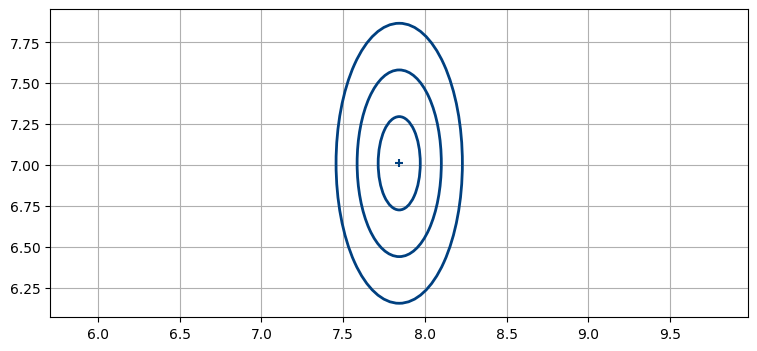

In [41]:
x, P = kf.x[0:2], kf.P[0:2, 0:2]
plot_covariance_ellipse(x, P, std=[1,2,3])

In previous sections $\mathbf P$ was a cicle, not an ellipse. In my code I set  $\mathbf R = \bigl[ \begin{smallmatrix}0.03 & 0 \\ 0 & 0.15\end{smallmatrix}\bigl ]$, which gives the measurement of $y$ 5 times the error of $x$. That's somewhat artificial, but in subsequent chapters nearly all of the covariances will be elliptical for good reasons. 在前面的章节中，$\mathbf   \ mathbf。 P$ 是一个圆，而非椭圆。在我的代码中，我设定了 $\mathbf   \ mathbf。 R = \bigl[ \begin   \开始{smallmatrix}0.03 & 0 \\ 0 & 0.15\end   \结束{smallmatrix}\bigl ]$，这使得 $y$ 的测量误差是 $x$ 的 5 倍。这有点人为设定，但在后续章节中，几乎所有协方差矩阵呈椭圆形都是有充分理由的。

Think about what this means. Statistics tells us that 99% of all measurements fall within 3 standard deviations; that means 99% of all measurements should be within this ellipse. Let's plot the measurement with the ellipse.想想这意味着什么。统计学告诉我们，99% 的所有测量值都落在 3 个标准差范围内；也就是说，99% 的所有测量值都应该在这个椭圆内。让我们把这个测量值和椭圆一起画出来。

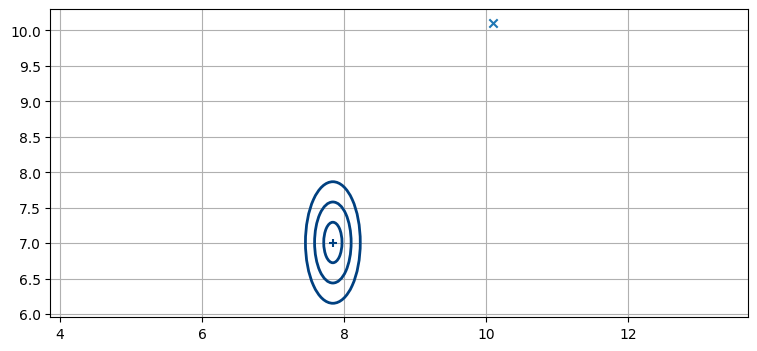

In [42]:
plot_covariance_ellipse(x, P, std=[1,2,3])
plt.scatter(z[0], z[1], marker='x');

Clearly the measurement is far beyond the the prior's covariance; we probably want to consider this a bad measurement and not use it. How would we do that?显然，该测量值远远超出了先验协方差的范围；我们或许应该将其视为不良测量值而不予采用。那我们该如何处理呢？

The first idea would to be extract the standard deviation for $x$ and $y$ and write a simple if statement. Here I will use another feature of the `KalmanFilter` class. The method `residual_of` computes the residual compared to the prior. I don't need to use it in this case since `kf.y` is already assigned by the call to `update()`, but if we are discarding measurements `update()` would not have been called yet and `kf.y` would contain the innovation from the previous epoch.第一个想法是提取 $x$ 和 $y$ 的标准差，并编写一个简单的 if 语句。在这里，我将使用 `KalmanFilter` 类的另一个特性。`residual_of` 方法计算与先验值的残差。在这种情况下，我不需要使用它，因为 `kf.y` 已经由 `update()` 调用赋值，但如果要丢弃测量值，`update()` 尚未被调用，`kf.y` 将包含上一个周期的创新值。

First, let's introduce two terms. We are discussing **gating**. A **gate** is a formula or algorithm that determines if a measurement is good or bad. Only good measurements get through the gate. This process is called gating.首先，我们来介绍两个术语。我们正在讨论的是“门控”。一个“门”是一个公式或算法，用于判断测量结果是好是坏。只有好的测量结果才能通过这个门。这个过程就叫做门控。

In practice measurements are not purely Gaussian, so a gate of 3 standard deviations is likely to discard some good measurements. I will elaborate soon, for now we will use 4 standard deviations实际上，测量值并非完全呈高斯分布，因此 3 个标准差的门限可能会舍弃一些良好的测量值。稍后我会详细说明，目前我们采用 4 个标准差。

In [43]:
GATE_LIMIT = 4.
std_x = np.sqrt(P[0,0])
std_y = np.sqrt(P[1,1])
y = kf.residual_of(z)[:,0]

if y[0] > GATE_LIMIT * std_x or y[1] > GATE_LIMIT * std_y:
    print(f'discarding measurement, error is {y[0]/std_x:.0f} std, {y[1]/std_y:.0f} std')
    
print('y   is', y)
print(f'std is {std_x:.2f} {std_y:.2f}')

discarding measurement, error is 39 std, 18 std
y   is [5.05 5.05]
std is 0.13 0.29


We see the errors are roughly 39 and 18 standard deviations away. Is this good enough?我们看到误差大约在 39 和 18 个标准差之外。这样够好吗？

Maybe. However, notice that the if statement forms a rectangular region surrounding the ellipse. In the plot below I've drawn a measurement that is clearly outside of the 3 std ellipse, yet would be accepted by the gate, and another measurement that lies just on the 3 std boundary.或许吧。不过请注意，if 语句形成了一个矩形区域，将椭圆包围在内。在下面的图中，我画出了一个明显位于 3 倍标准差椭圆之外但仍会被门限接受的测量值，以及另一个刚好位于 3 倍标准差边界上的测量值。

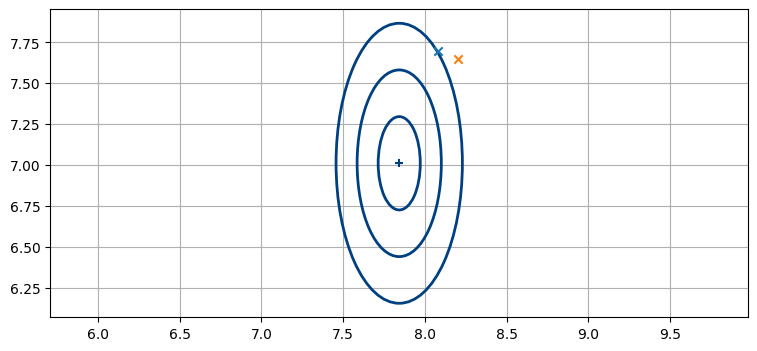

In [44]:
plot_covariance_ellipse(x, P, std=[1,2,3])
plt.scatter(8.08, 7.7, marker='x')
plt.scatter(8.2, 7.65, marker='x');

There are alternative methods of defining this gate. The **mahalanobis distance** is a statistical measure of the distance of a point from a distribution. Before we get to the definition and math, let's compute the mahalanobis distance for some points. `filterpy.stats` implements `mahalanobis()`.定义此门限还有其他方法。马氏距离是一种衡量某点与分布之间距离的统计量。在给出定义和数学公式之前，让我们先计算一些点的马氏距离。`filterpy.stats` 实现了 `mahalanobis()` 函数。

In [45]:
from filterpy.stats import mahalanobis
m = mahalanobis(x=z, mean=x, cov=P)
print(f'mahalanobis distance = {m:.1f}')

mahalanobis distance = 20.6


Without knowing the units we can compare it to the standard deviation errors computed in $x$ and $y$ separately, 39, and 18, and see that it is reasonably close. Let's see what we get for the point I plotted above.在不知道单位的情况下，我们可以将其与分别在 $x$ 和 $y$ 方向上计算出的标准偏差误差 39 和 18 进行比较，发现它相当接近。让我们看看上面我绘制的那个点的结果。

In [46]:
print(f'mahalanobis distance = {mahalanobis(x=[8.08, 7.7], mean=x, cov=P):.1f}')
print(f'mahalanobis distance = {mahalanobis(x=[8.2, 7.65], mean=x, cov=P):.1f}')

mahalanobis distance = 3.0
mahalanobis distance = 3.6


As we will see the mahalanobis distance computes the scalar standard deviation *distance* point to a distribution, much like the Euclidian distance computes a scalar distance from a point to another point. 正如我们将会看到的，马氏距离计算的是一个点到分布的标量标准差“距离”，这很像欧几里得距离计算的是一个点到另一个点的标量距离。

The cell above bears that out. The point that was sitting on the 3 std boundary has a mahalanobis distance of 3.0, and the one outside of the ellipse has a value of 3.6 std.上面的单元格就证明了这一点。位于 3 个标准差边界上的那个点的马氏距离为 3.0，而位于椭圆之外的那个点的值为 3.6 个标准差。

How do we compute the mahalanobis distance? It is defined as我们如何计算马氏距离？其定义为

$$D_m= \sqrt{(\mathbf x-\mu)^\mathsf T \mathbf S^{-1} (\mathbf x-\mu)}$$$$D_m   米 = \sqrt   \√6{(\mathbf   \ mathbf。 x - \mu)^\mathsf T \mathbf   \ mathbf。 S   年代^{-1} (\mathbf   \ mathbf。 x - \mu)}$$

翻译为：

$$D_m = \sqrt{(\mathbf x - \mu)^\mathsf T \mathbf S^{-1} (\mathbf x - \mu)}$$$$D_m   米 = \sqrt   \√6{(\mathbf   \ mathbf。 x - \mu)^\mathsf T \mathbf   \ mathbf。 S   年代^{-1} (\mathbf   \ mathbf。 x - \mu)}$$

翻译为：

$$D_m = \sqrt{(\mathbf x - \mu)^\mathsf T \mathbf S^{-1} (\mathbf x - \mu)}$$$$D_m   米 = \sqrt   \√6{(\mathbf   \ mathbf。 x - \mu)^\mathsf T \mathbf   \ mathbf。 S   年代^{-1} (\mathbf   \ mathbf。 x - \mu)}$$

翻译为：

$$D_m = \sqrt{(\mathbf x - \mu)^\mathsf T \mathbf S^{-1} (\mathbf x - \mu)}$$$$D_m   米 = \sqrt   \√6{(\mathbf   \ mathbf。 x - \mu)^\mathsf T \mathbf   \ mathbf。 S   年代^{-1} (\mathbf   \ mathbf。 x - \mu)}$$

翻译为：

$$D_m = \sqrt{(\mathbf x - \mu)^\mathsf T \mathbf S^{-1} (\mathbf x - \mu)}$$$$D_m   米 = \sqrt   \√6{(\mathbf   \ mathbf。 x - \mu)^\mathsf T \mathbf   \ mathbf。 S   年代^{-1} (\mathbf   \ mathbf。 x - \mu)}$$

翻译为：

$$D_m = \sqrt{(\mathbf x - \mu)^\mathsf T \mathbf S^{-1} (\mathbf x - \mu)}$$$$D_m   米 = \sqrt   \√6{(\mathbf   \ mathbf。 x - \mu)^\mathsf T \mathbf   \ mathbf。 S   年代^{-1} (\mathbf   \ mathbf。 x - \mu)}$$

翻译为：

$$D_m = \sqrt{(\mathbf x - \mu)^\mathsf T \mathbf S^{-1} (\mathbf x - \mu)}$$$$D_m   米 = \sqrt   \√6{(\mathbf   \ mathbf。 x - \mu)^\mathsf T \mathbf   \ mathbf。 S   年代^{-1} (\mathbf   \ mathbf。 x - \mu)}$$

翻译为：

$$D_m = \sqrt{(\mathbf x - \mu)^\mathsf T \mathbf S^{-1} (\mathbf x - \mu)}$$$$D_m   米 = \sqrt   \√6{(\mathbf   \ mathbf。 x - \mu)^\mathsf T \mathbf   \ mathbf。 S   年代^{-1} (\mathbf   \ mathbf。 x - \mu)}$$

翻译为：

$$D_m = \sqrt{(\mathbf x - \mu)^\mathsf T \mathbf S^{-1} (\mathbf x - \mu)}$$$$D_m   米 = \sqrt   \√6{(\mathbf   \ mathbf。 x - \mu)^\mathsf T \mathbf   \ mathbf。 S   年代^{-1} (\mathbf   \ mathbf。 x - \mu)}$$

翻译为：

$$D_m = \sqrt{(\mathbf x - \mu)^\mathsf T \mathbf S^{-1} (\mathbf x - \mu)}$$$$D_m   米 = \sqrt   \√6{(\mathbf   \ mathbf。 x - \mu)^\mathsf T \mathbf   \ mathbf。 S   年代^{-1} (\mathbf   \ mathbf。 x - \mu)}$$

翻译为：

$$D_m = \sqrt{(\mathbf x - \mu)^\mathsf T \mathbf S^{-1} (\mathbf x - \mu)}$$$$D_m   米 = \sqrt   \√6{(\mathbf   \ mathbf。 x - \mu)^\mathsf T \mathbf   \ mathbf。 S   年代^{-1} (\mathbf   \ mathbf。 x - \mu)}$$

翻译为：

$$D_m = \sqrt{(\mathbf x - \mu)^\mathsf T \mathbf S^{-1} (\mathbf x - \mu)}$$$$D_m   米 = \sqrt   \√6{(\mathbf   \ mathbf。 x - \mu)^\mathsf T \mathbf   \ mathbf。 S   年代^{-1} (\mathbf   \ mathbf。 x - \mu)}$$

翻译为：

$$D_m = \sqrt{(\mathbf x - \mu)^\mathsf T \mathbf S^{-1} (\mathbf x - \mu)}$$$$D_m   米 = \sqrt   \√6{(\mathbf   \ mathbf。 x - \mu)^\mathsf T \mathbf   \ mathbf。 S   年代^{-1} (\mathbf   \ mathbf。 x - \mu)}$$

翻译为：

$$D_m = \sqrt{(\mathbf x - \mu)^\mathsf T \mathbf S^{-1} (\mathbf x - \mu)}$$$$D_m   米 = \sqrt   \√6{(\mathbf   \ mathbf。 x - \mu)^\mathsf T \mathbf   \ mathbf。 S   年代^{-1} (\mathbf   \ mathbf。 x - \mu)}$$

翻译为：

$$D_m = \sqrt{(\mathbf x - \mu)^\mathsf T \mathbf S^{-1} (\mathbf x - \mu)}$$$$D_m   米 = \sqrt   \√6{(\mathbf   \ mathbf。 x - \mu)^\mathsf T \mathbf   \ mathbf。 S   年代^{-1} (\mathbf   \ mathbf。 x - \mu)}$$

翻译为：

$$D_m = \sqrt{(\mathbf x - \mu)^\mathsf T \mathbf S^{-1} (\mathbf x - \mu)}$$$$D_m   米 = \sqrt   \√6{(\mathbf   \ mathbf。 x - \mu)^\mathsf T \mathbf   \ mathbf。 S   年代^{-1} (\mathbf   \ mathbf。 x - \mu)}$$

翻译为：

$$D_m = \sqrt{(\mathbf x - \mu)^\mathsf T \mathbf S^{-1} (\mathbf x - \mu)}$$$$D_m   米 = \sqrt   \√6{(\mathbf   \ mathbf。 x - \mu)^\mathsf T \mathbf   \ mathbf。 S   年代^{-1} (\mathbf   \ mathbf。 x - \mu)}$$

翻译为：

$$D_m = \sqrt{(\mathbf x - \mu)^\mathsf T \mathbf S^{-1} (\mathbf x - \mu)}$$$$D_m   米 = \sqrt   \√6{(\mathbf   \ mathbf。 x - \mu)^\mathsf T \mathbf   \ mathbf。 S   年代^{-1} (\mathbf   \ mathbf。 x - \mu)}$$

翻译为：

$$D_m = \sqrt{(\mathbf x - \mu)^\mathsf T \mathbf S^{-1} (\mathbf x - \mu)}$$$$D_m   米 = \sqrt   \√6{(\mathbf   \ mathbf。 x - \mu)^\mathsf T \mathbf   \ mathbf。 S   年代^{-1} (\mathbf   \ mathbf。 x - \mu)}$$

翻译为：

$$D_m = \sqrt{(\mathbf x - \mu)^\mathsf T \mathbf S^{-1} (\mathbf x - \mu)}$$$$D_m   米 = \sqrt   \√6{(\mathbf   \ mathbf。 x - \mu)^\mathsf T \mathbf   \ mathbf。 S   年代^{-1} (\mathbf   \ mathbf。 x - \mu)}$$

翻译为：

$$D_m = \sqrt{(\mathbf x - \mu)^\mathsf T \mathbf S^{-1} (\mathbf x - \mu)}$$$$D_m   米 = \sqrt   \√6{(\mathbf   \ mathbf。 x - \mu)^\mathsf T \mathbf   \ mathbf。 S   年代^{-1} (\mathbf   \ mathbf。 x - \mu)}$$

翻译为：

$$D_m = \sqrt{(\mathbf x - \mu)^\mathsf T \mathbf S^{-1} (\mathbf x - \mu)}$$$$D_m   米 = \sqrt   \√6{(\mathbf   \ mathbf。 x - \mu)^\mathsf T \mathbf   \ mathbf。 S   年代^{-1} (\mathbf   \ mathbf。 x - \mu)}$$

翻译为：

$$D_m = \sqrt{(\mathbf x - \mu)^\mathsf T \mathbf S^{-1} (\mathbf x - \mu)}$$$$D_m   米 = \sqrt   \√6{(\mathbf   \ mathbf。 x - \mu)^\mathsf T \mathbf   \ mathbf。 S   年代^{-1} (\mathbf   \ mathbf。 x - \mu)}$$

翻译为：

$$D_m = \sqrt{(\mathbf x - \mu)^\mathsf T \mathbf S^{-1} (\mathbf x - \mu)}$$$$D_m   米 = \sqrt   \√6{(\mathbf   \ mathbf。 x - \mu)^\mathsf T \mathbf   \ mathbf。 S   年代^{-1} (\mathbf   \ mathbf。 x - \mu)}$$

翻译为：

$$D_m = \sqrt{(\mathbf x - \mu)^\mathsf T \mathbf S^{-1} (\mathbf x - \mu)}$$$$D_m   米 = \sqrt   \√6{(\mathbf   \ mathbf。 x - \mu)^\mathsf T \mathbf   \ mathbf。 S   年代^{-1} (\mathbf   \ mathbf。 x - \mu)}$$

翻译为：

$$D_m = \sqrt{(\mathbf x - \mu)^\mathsf T \mathbf S^{-1} (\mathbf x - \mu)}$$$$D_m   米 = \sqrt   \√6{(\mathbf   \ mathbf。 x - \mu)^\mathsf T \mathbf   \ mathbf。 S   年代^{-1} (\mathbf   \ mathbf。 x - \mu)}$$

翻译为：

$$D_m = \sqrt{(\mathbf x - \mu)^\mathsf T \mathbf S^{-1} (\mathbf x - \mu)}$$$$D_m   米 = \sqrt   \√6{(\mathbf   \ mathbf。 x - \mu)^\mathsf T \mathbf   \ mathbf。 S   年代^{-1} (\mathbf   \ mathbf。 x - \mu)}$$

翻译为：

$$D_m = \sqrt{(\mathbf x - \mu)^\mathsf T \mathbf S^{-1} (\mathbf x - \mu)}$$$$D_m   米 = \sqrt   \√6{(\mathbf   \ mathbf。 x - \mu)^\mathsf T \mathbf   \ mathbf。 S   年代^{-1} (\mathbf   \ mathbf。 x - \mu)}$$

翻译为：

$$D_m = \sqrt{(\mathbf x - \mu)^\mathsf T \mathbf S^{-1} (\mathbf x - \mu)}$$$$D_m   米 = \sqrt   \√6{(\mathbf   \ mathbf。 x - \mu)^\mathsf T \mathbf   \ mathbf。 S   年代^{-1} (\mathbf   \ mathbf。 x - \mu)}$$

翻译为：

$$D_m = \sqrt{(\mathbf x - \mu)^\mathsf T \mathbf S^{-1} (\mathbf x - \mu)}$$$$D_m   米 = \sqrt   \√6{(\mathbf   \ mathbf。 x - \mu)^\mathsf T \mathbf   \ mathbf。 S   年代^{-1} (\mathbf   \ mathbf。 x - \mu)}$$

翻译为：

$$D_m = \sqrt{(\mathbf x - \mu)^\mathsf T \mathbf S^{-1} (\mathbf x - \mu)}$$$$D_m   米 = \sqrt   \√6{(\mathbf   \ mathbf。 x - \mu)^\mathsf T \mathbf   \ mathbf。 S   年代^{-1} (\mathbf   \ mathbf。 x - \mu)}$$

翻译为：

$$D_m = \sqrt{(\mathbf x - \mu)^\mathsf T \mathbf S^{-1} (\mathbf x - \mu)}$$$$D_m   米 = \sqrt   \√6{(\mathbf   \ mathbf。 x - \mu)^\mathsf T \mathbf   \ mathbf。 S   年代^{-1} (\mathbf   \ mathbf。 x - \mu)}$$

翻译为：

$$D_m = \sqrt{(\mathbf x - \mu)^\mathsf T \mathbf S^{-1} (\mathbf x - \mu)}$$$$D_m   米 = \sqrt   \√6{(\mathbf   \ mathbf。 x - \mu)^\mathsf T \mathbf   \ mathbf。 S   年代^{-1} (\mathbf   \ mathbf。 x - \mu)}$$

翻译为：

$$D_m = \sqrt{(\mathbf x - \mu)^\mathsf T \mathbf S^{-1} (\mathbf x - \mu)}$$$$D_m   米 = \sqrt   \√6{(\mathbf   \ mathbf。 x - \mu)^\mathsf T \mathbf   \ mathbf。 S   年代^{-1} (\mathbf   \ mathbf。 x - \mu)}$$

翻译为：

$$D_m = \sqrt{(\mathbf x - \mu)^\mathsf T \mathbf S^{-1} (\mathbf x - \mu)}$$$$D_m   米 = \sqrt   \√6{(\mathbf   \ mathbf。 x - \mu)^\mathsf T \mathbf   \ mathbf。 S   年代^{-1} (\mathbf   \ mathbf。 x - \mu)}$$

翻译为：

$$D_m = \sqrt{(\mathbf x - \mu)^\mathsf T \mathbf S^{-1} (\mathbf x - \mu)}$$$$D_m   米 = \sqrt   \√6{(\mathbf   \ mathbf。 x - \mu)^\mathsf T \mathbf   \ mathbf。 S   年代^{-1} (\mathbf   \ mathbf。 x - \mu)}$$

翻译为：

$$D_m = \sqrt{(\mathbf x - \mu)^\mathsf T \mathbf S^{-1} (\mathbf x - \mu)}$$$$D_m   米 = \sqrt   \√6{(\mathbf   \ mathbf。 x - \mu)^\mathsf T \mathbf   \ mathbf。 S   年代^{-1} (\mathbf   \ mathbf。 x - \mu)}$$

翻译为：

$$D_m = \sqrt{(\mathbf x - \mu)^\mathsf T \mathbf S^{-1} (\mathbf x - \mu)}$$$$D_m   米 = \sqrt   \√6{(\mathbf   \ mathbf。 x - \mu)^\mathsf T \mathbf   \ mathbf。 S   年代^{-1} (\mathbf   \ mathbf。 x - \mu)}$$

翻译为：

$$D_m = \sqrt{(\mathbf x - \mu)^\mathsf T \mathbf S^{-1} (\mathbf x - \mu)}$$$$D_m   米 = \sqrt   \√6{(\mathbf   \ mathbf。 x - \mu)^\mathsf T \mathbf   \ mathbf。 S   年代^{-1} (\mathbf   \ mathbf。 x - \mu)}$$

翻译为：

$$D_m = \sqrt{(\mathbf x - \mu)^\mathsf T \mathbf S^{-1} (\mathbf x - \mu)}$$$$D_m   米 = \sqrt   \√6{(\mathbf   \ mathbf。 x - \mu)^\mathsf T \mathbf   \ mathbf。 S   年代^{-1} (\mathbf   \ mathbf。 x - \mu)}$$

翻译为：

$$D_m = \sqrt{(\mathbf x - \mu)^\mathsf T \mathbf S^{-1} (\mathbf x - \mu)}$$$$D_m   米 = \sqrt   \√6{(\mathbf   \ mathbf。 x - \mu)^\mathsf T \mathbf   \ mathbf。 S   年代^{-1} (\mathbf   \ mathbf。 x - \mu)}$$

翻译为：

$$D_m = \sqrt{(\mathbf x - \mu)^\mathsf T \mathbf S^{-1} (\mathbf x - \mu)}$$$$D_m = \sqrt{(\mathbf x - \mu)^\mathsf T \mathbf S^{-1} (\mathbf x - \mu)}$$

翻译为：

$$D_m = \sqrt{(\mathbf x - \mu)^\mathsf T \mathbf S^{-1} (\mathbf x - \mu)}$$

其中，$D_m

其中，$D_m

其中，$D_m

其中，$D_m

其中，$D_m

其中，$D_m

其中，$D_m

其中，$D_m

其中，$D_m

其中，$D_m

其中，$D_m

其中，$D_m

其中，$D_m

其中，$D_m

其中，$D_m

其中，$D_m

其中，$D_m

其中，$D_m

其中，$D_m

其中，$D_m

其中，$D_m

其中，$D_m

其中，$D_m

其中，$D_m

其中，$D_m

其中，$D_m

其中，$D_m

其中，$D_m

其中，$D_m

其中，$D_m

其中，$D_m

其中，$D_m

其中，$D_m

其中，$D_m

其中，$D_m

其中，$D_m

其中，$D_m

其中，$D_m

其中，$D_m

其中，$D_m

其中，$D_m

其中

Note how similar this is to the Euclidean distance, which we can write as:请注意，这与欧几里得距离是多么相似，我们可以将其写为：

$$D_e= \sqrt{(\mathbf x-\mathbf y)^\mathsf T (\mathbf x-\mathbf y)}$$

In fact, if the covariance $\mathbf S$ is the identity matrix the mahalanobis distance is the same as the Euclidean distance. You should be able to see how that works with the linear algebra: the inverse of the identity matrix is the identity matrix, so we are effectively multiplying the terms with 1. Think of it intuitively. If the standard deviation in each dimension is 1, then the a point anywhere on a circle of radius 1 around the mean will lie on the 1 std circle and also be 1 *unit* away in Euclidean measure.实际上，如果协方差矩阵 $\mathbf   \ mathbf。 S   年代$ 为单位矩阵，那么马氏距离就与欧几里得距离相同。从线性代数的角度来看，您应该能够明白其中的道理：单位矩阵的逆矩阵仍是单位矩阵，所以实际上我们只是将各项乘以 1。直观地想一想，如果每个维度的标准差都是 1，那么围绕均值的半径为 1 的圆上的任何一点都将位于 1 个标准差的圆上，并且在欧几里得度量下距离为 1 个单位。

This suggests another interpretation. If the covariance matrix is diagonal then we can think of the mahalanobis distance as being the *scaled* Euclidean distance, where each term is scaled by the covariance in the diagonal.

$$D_m = \sqrt{\sum_{i-1}^N \frac{(x_i - \mu_i)^2}{\sigma_i}}$$

In 2D that would be 

$$D_m = \sqrt {\frac{1}{\sigma_x^2}(x_0 - x_1)^2 + \frac{1}{\sigma_y^2}(y_0 - y_1)^2}$$

This should give you insight into the equation for mahalanobis distance. You cannot divide by a matrix, but multiplying by the inverse is *effectively* the same, in a hand wavey sense. Multiplying by the difference $\mathbf y = \mathbf x - \mathbf \mu$ on each side gives us the squared norm scaled by the covariance: $\mathbf y^\mathsf T \mathbf S^{-1}\mathbf y^\mathsf T$. The covariance terms are all squared, so taking the square root at the end brings us to a scalar distance which is the Euclidean distance scaled by the covariance.


### Gating and Data Association Strategies门控与数据关联策略

The two gates above are known as rectangular and ellipsoidal gates in some of the literature because of their shape. There are more alternatives I will not explore here. For example, a maneuver gate is used to define a region where it is possible for the object to maneuver, taking the object's current velocity and ability to maneuver into account. For example, a fighter jet would have a maneuver gate shaped much like a cone projecting in front of it's current direction of travel. An automobile would have a much smaller 2D pie slice shape projecting in front of it. A ship would have a much narrower slice since it's ability to turn or accelerate quickly is minimal.上面的两个门由于其形状在一些文献中被称为矩形门和椭圆形门。这里还有更多其他的选择，我就不一一探讨了。例如，机动门用于定义一个区域，在该区域内考虑到物体当前的速度和机动能力，物体有可能进行机动。例如，战斗机的机动门形状很像一个朝其当前行进方向前方伸出的圆锥体。汽车的机动门则是一个较小的二维扇形，朝其前方伸出。而轮船的机动门则是一个更窄的扇形，因为它快速转向或加速的能力有限。

Which gating technique should you use? There is no single answer. Much depends on the dimensionality of the problem and how much computational power you have. A rectangular gate is very cheap to compute, the maneuver gate isn't much worse, but the ellipsoidal gate can be expensive in higher dimensions. However, as you increase dimensions the relative area difference between the ellipsoid and rectangular gate increases significantly.应该使用哪种门控技术？没有一个确切的答案。这在很大程度上取决于问题的维度以及您拥有的计算能力。矩形门的计算成本非常低，机动门的成本也不高多少，但在高维度下，椭圆门的计算成本可能会很高。然而，随着维度的增加，椭圆门和矩形门之间的相对面积差异会显著增大。

This matters more than you might realize. Every measurement has noise. A spurious measurement can fall *within* our gate, causing us to accept it. The larger the area that extends past the ellipsoid, the larger the probability of the gate passing a bad measurement. I will not do the math here, but in 5 dimensions the rectangular gate is twice as likely to accept a bad measurement as the ellipsoid. 

If computational time is a concern and you have many spurious measurements you can take a two gate approach. The first gate is large and rectangular, and used as a first pass to throw away obviously bad measurements. The few measurements that pass that gate are then subjected to the more expensive mahalanobis distance calculation. If you are running on a modern desktop processor the time of those matrix multiplies are not significant, but it may matter if you are running on an embedded chip with modest floating point performance.

Data association is a vast topic that requires its own book. The canonical example is tracking with radar. The radar detects multiple signals on each sweep. From that we need to form aircraft tracks, and reject noisy measurements. This is a very difficult problem. Suppose the first sweep gets 5 measurements. We would create 5 potential tracks. In the next sweep we get 6 measurements. We can combine any of the first measurements with any of the second measurements, giving us 30 potential tracks. But, it is also possible that these are all new aircraft that we didn't see in the last sweep, so that gives us 6 more tracks. After just a few epochs we reach millions, then billions of potential tracks.

Given this list of billions of tracks we can then compute a score for each track. I'll provide the math for that in the following section. But, visualize a track that forms a 'Z' shape over 3 epochs. No aircraft can maneuver like that, so we would give it a very low probability of being real. Another track forms a straight line, but imputes a velocity of 10,000 kph. That is also very improbable. Another track curves at 200 kph. That has a high probability.

So tracking becomes a matter of gating, data association, and pruning. For example, say the second radar sweep just occured. Do I combine all possible combinations into a tracks? I probably shouldn't. If point 1, sweep 1 imputes a velocity of 200kph with point 3, sweep 2 we should form a track from it. If the velocity is 5000 kph we shouldn't bother; we know that track is so unlikely as to be impossible. Then, as the tracks grow we will have well defined ellipsoidal or maneuver gates for them, and we can be far more selective about the measurements we associate with tracks.

There are schemes for associations. We can choose to associate a measurement to only one track. Or, we can choose to associate a measurement with multiple tracks, reflecting our lack of certainty with which track it belongs to. For example, aircraft tracks can cross from the point of view of the radar. As the aircraft approach associating a single measurement with one of the two aircraft can become uncertain. You could assign the measurement to both tracks for a short time. As you gather more measurements you could then go back and change assignment based on which is more probable given the new information.

'Billions' does not begin to capture the combinatorial explosion this implies. After just a few seconds you will be out of computer memory, a bit longer and you would require every atom in the universe to represent all of the potential tracks. So a practical algorithm needs to aggressively prune tracks. This pruning takes additional compute power. 

A later chapter in the book provides the modern answer to this problem, the *particle filter*, which solves the combinatorial explosion with statistical sampling. It is my favored approach for this problem, so I will not write more about the techniques I am discussing in this section. I am not entirely up to date on current research in this area, so do your own research if you are trying to solve a problem requiring to either track multiple objects or deal with multiple spurious measurements. Particle filters have their own difficulties and limitations.

I will point you to a few books and researchers. Samuel S. Blackman's "Multiple-Target Tracking with Radar Application" is the clearest written book I have read on the topic, though it is dated (1986). Yaakov Bar-Shalom has written extensively on the subject. Subhash Challa et. al "Fundamentals of Object Tracking" is a fairly modern work that covers the various approaches. This book is fairly rigorous mathematically; filters are presented as a collection of integrals representing various Bayesian formulation, and it is up to you to translate that into a working algorithm. It is readable if you have taken on all the math in this book, but not easy. Lawrence D. Stone's "Bayesian Multiple Target Tracking" treats it as a Bayesian inference problem, as I have, but is also quite theoretical, where you are blithely told to find a maximum of a complicated integral, which in practice you will probably solve using a particle filter. 

Back to our simple problem - tracking a single object with an occasional bad measurement. How should that be implemented? It's fairly straightforward; if the measurement is bad, discard it and do not call update. This will cause you to call `predict()` twice in a row, which is fine. Your uncertainty will grow, but a few missed updates generally will not cause a problem. 

What cutoff value should you use for your gate? I don't know. Theory says 3 std, but practice says otherwise. You will need to experiment. Gather data, run a filter on it using various gates, and see what value gives the best results. In the next section I give you some math to evaluate filter performance. Maybe you find out you need to accept all measurements < 4.5 std. I watched a NASA video where they stated they used a gate around 5-6 std. it depends on your problem and data. 

## Evaluating Filter Performance评估滤波器性能

It is easy to design a Kalman filter for a simulated situation. You know how much noise you are injecting in your process model, so you specify $\mathbf Q$ to have the same value. You also know how much noise is in the measurement simulation, so the measurement noise matrix $\mathbf R$ is equally trivial to define. 在模拟情况下设计卡尔曼滤波器很容易。您知道在过程模型中注入了多少噪声，所以您可以将 $\mathbf   \ mathbf。 Q   问$ 设定为相同的值。您也知道测量模拟中的噪声有多少，因此测量噪声矩阵 $\mathbf   \ mathbf。 R$ 同样很容易定义。

In practice design is more ad hoc. Real sensors rarely perform to spec, and they rarely perform in a Gaussian manner. They are also easily fooled by environmental noise. For example, circuit noise causes voltage fluctuations which can affect the output of a sensor. Creating a process model and noise is even more difficult. Modelling an automobile is very difficult. The steering causes nonlinear behavior, tires slip, people brake and accelerate hard enough to cause tire slips, winds push the car off course. The end result is the Kalman filter is an *inexact* model of the system. This inexactness causes suboptimal behavior, which in the worst case causes the filter to diverge completely. 实际上，设计往往更具随机性。真正的传感器很少能达到规格要求，也很少能表现出高斯分布的特性。它们还很容易受到环境噪声的影响。例如，电路噪声会导致电压波动，从而影响传感器的输出。创建过程模型和噪声模型更是难上加难。对汽车进行建模非常困难。转向会导致非线性行为，轮胎打滑，人们急刹车和急加速也会导致轮胎打滑，风会把车吹偏。最终结果是卡尔曼滤波器只是对系统的一种不精确的模型。这种不精确性会导致次优行为，在最坏的情况下会导致滤波器完全发散。

Because of the unknowns you will be unable to analytically compute the correct values for the filter's matrices. You will start by making the best estimate possible, and then test your filter against a wide variety of simulated and real data. Your evaluation of the performance will guide you towards what changes you need to make to the matrices. We've done some of this already - I've shown you the effect of $\mathbf Q$ being too large or small.

Now let's consider more analytical ways of accessing performance. If the Kalman filter is performing optimally its estimation errors (the difference between the true state and the estimated state) will have these properties:

    1. The mean of the estimation error is zero
    2. Its covariance is described by the Kalman filter's covariance matrix
    
### Normalized Estimated Error Squared (NEES)

The first method is the most powerful, but only possible in simulations. If you are simulating a system you know its true value, or 'ground truth'. It is then trivial to compute the error of the system at any step as the difference between ground truth ($\mathbf x$) and the filter's state estimate ($\hat{\mathbf x}$):

$$\tilde{\mathbf x} = \mathbf x - \hat{\mathbf x}$$

We can then define the *normalized estimated error squared* (NEES) as 

$$\epsilon = \tilde{\mathbf x}^\mathsf T\mathbf P^{-1}\tilde{\mathbf x}$$

To understand this equation let's look at it if the state's dimension is one. In that case both x and P are scalars, so

$$\epsilon = \frac{x^2}{P}$$

If this is not clear, recall that if $a$ is scalar,  $a^\mathsf T = a$ and that $a^{-1} =\frac{1}{a}$.

So as the covariance matrix gets smaller NEES gets larger for the same error. The covariance matrix is the filter's estimate of it's error, so if it is small relative to the estimation error then it is performing worse than if it is large relative to the same estimation error.

This computation gives us a scalar result. If $\mathbf x$ is dimension ($n \times 1$), then the dimension of the computation is ($1 \times n$)($n \times n$)($n \times 1$) = ($1 \times 1$). What do we do with this number?

The math is outside the scope of this book, but a random variable in the form $\tilde{\mathbf x}^\mathsf T\mathbf P^{-1}\tilde{\mathbf x}$ is said to be *chi-squared distributed with n degrees of freedom*, and thus the expected value of the sequence should be $n$. Bar-Shalom [1] has an excellent discussion of this topic. 

In plain terms, take the average of all the NEES values, and they should be less then the dimension of x. Let's see that using an example from earlier in the chapter:

In [47]:
from scipy.linalg import inv

def NEES(xs, est_xs, Ps):
    est_err = xs - est_xs
    err = []
    for x, p in zip(est_err, Ps):
        err.append(x.T @ inv(p) @ x)
    return err

In [48]:
R, Q = 6., 0.02
xs, zs = simulate_acc_system(R=R, Q=Q, count=80)
kf2 = SecondOrderKF(R, Q, dt=1)
est_xs, ps, _, _ = kf2.batch_filter(zs)

nees = NEES (xs, est_xs, ps)
eps = np.mean(nees)

print(f'mean NEES is: {eps:.4f}')
if eps < kf2.dim_x:
    print('passed')
else:
    print('failed')

mean NEES is: 0.8893
passed


`NEES` is implemented FilterPy; access it with`NEES` 在 FilterPy 中得以实现；通过以下方式访问它

```python   ”“python
from filterpy.stats import NEESfrom filterpy.stats 导入 NEES
```
This is an excellent measure of the filter's performance, and should be used whenever possible, especially in production code when you need to evaluate the filter while it is running. While designing a filter I still prefer plotting the residuals as it gives me a more intuitive understanding of what is happening.这是衡量滤波器性能的绝佳指标，应尽可能使用，尤其是在生产代码中需要在运行时评估滤波器时。不过在设计滤波器时，我还是更倾向于绘制残差图，因为它能让我更直观地理解正在发生的情况。

However, if your simulation is of limited fidelity then you need to use another approach.然而，如果您的模拟精度有限，那么您就需要采用另一种方法。

### Likelihood Function   似然函数

In statistics the likelihood is very similar to a probability, with a subtle difference that is important to us. A *probability* is the chance of something happening - as in what is the probability that a fair die rolls 6 three times in five rolls? The *likelihood* asks the reverse question - given that a die rolled 6 three times in five rolls, what is the likelihood that the die is fair?  在统计学中，似然与概率非常相似，但有一个对我们来说很重要的细微差别。概率是指某事发生的可能性——比如，一个公平的骰子在五次投掷中三次掷出 6 的概率是多少？而似然则反过来提问——已知一个骰子在五次投掷中有三次掷出 6，那么这个骰子是公平的似然性有多大？

We first discussed the likelihood function in the **Discrete Bayes** chapter. In the context of these filters the likelihood is a measure of how likely the measurement are given the current state.我们在“离散贝叶斯”一章中首次讨论了似然函数。在这些滤波器的语境中，似然度是对给定当前状态测量值出现可能性的一种度量。

This is important to us because we have the filter output and we want to know the likelihood that it is performing optimally given the assumptions of Gaussian noise and linear behavior. If the likelihood is low we know one of our assumptions is wrong. In the **Adaptive Filtering** chapter we will learn how to make use of this information to improve the filter; here we will only learn to make the measurement. 这对我们来说很重要，因为我们有滤波器的输出，并且想知道在高斯噪声和线性行为的假设下，它正常运行的可能性有多大。如果可能性很低，我们就知道我们的某个假设是错误的。在“自适应滤波”一章中，我们将学习如何利用这些信息来改进滤波器；在这里，我们只学习如何进行测量。

The residual and system uncertainty of the filter is defined as

$$\begin{aligned}
\mathbf y &= \mathbf z - \mathbf{H \bar x}\\
\mathbf S &= \mathbf{H\bar{P}H}^\mathsf T + \mathbf R
\end{aligned}
$$

Given these we can compute the likelihood function with

$$
\mathcal{L} = \frac{1}{\sqrt{2\pi S}}\exp [-\frac{1}{2}\mathbf y^\mathsf T\mathbf S^{-1}\mathbf y]$$

That may look complicated, but notice that the exponential is the equation for a Gaussian. This suggests an implementation of

```python
from scipy.stats import multivariate_normal
hx = (H @ x).flatten()
S = H @ P @ H.T  + R
likelihood = multivariate_normal.pdf(z.flatten(), mean=hx, cov=S)
```

In practice it happens a bit differently. Likelihoods can be difficult to deal with mathematically. It is common to compute and use the *log-likelihood* instead, which is just the natural log of the likelihood. This has several benefits. First, the log is strictly increasing, and it reaches it's maximum value at the same point of the function it is applied to. If you want to find the maximum of a function you normally take the derivative of it; it can be difficult to find the derivative of some arbitrary function, but finding $\frac{d}{dx} log(f(x))$ is trivial, and the result is the same as $\frac{d}{dx} f(x)$. We don't use this property in this book, but it is essential when performing analysis on filters.

The likelihood and log-likelihood are computed for you when `update()` is called, and is accessible via the 'log_likelihood' and `likelihood` data attribute. Let's look at this: I'll run the filter with several measurements within expected range, and then inject measurements far from the expected values:

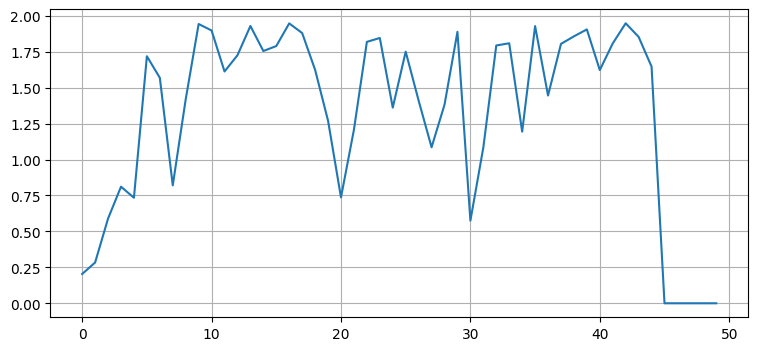

In [49]:
R, Q = .05, 0.02
xs, zs = simulate_acc_system(R=R, Q=Q, count=50)
zs[-5:-1] = [100, 200, 200, 200] # bad measurements, bad!

kf = SecondOrderKF(R, Q, dt=1, P=1)
s = Saver(kf)
kf.batch_filter(zs, saver=s)
plt.plot(s.likelihood);

The likelihood gets larger as the filter converges during the first few iterations. After that the likelihood bounces around until it reaches the bad measurements, at which time it goes to zero, indicating that if the measurements are valid the filter is very unlikely to be optimal.在最初的几次迭代中，随着滤波器的收敛，似然度会增大。之后，似然度会波动，直到遇到错误的测量值，此时它会降至零，这表明如果测量值有效，那么滤波器不太可能是最优的。

See how starkly the log-likelihood illustrates where the filter goes 'bad'.看看对数似然函数是如何鲜明地表明滤波器在何处“出错”的。

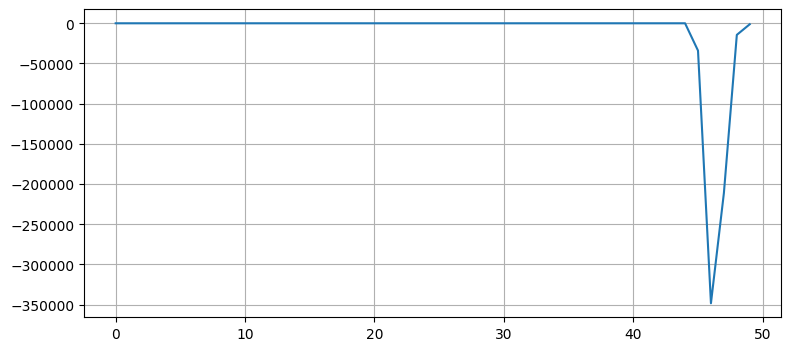

In [50]:
plt.plot(s.log_likelihood);

Why does it return to zero at the end? Think about that before reading the answer. The filter begins to adapt to the new measurements by moving the state close to the measurements. The residuals become small, and so the state and residuals agree. 为什么最后会回到零？在看答案之前先思考一下这个问题。滤波器通过将状态值移向新的测量值来开始适应新的测量值。残差变得很小，因此状态值和残差趋于一致。

## Control Inputs   控制输入

In the **Discrete Bayes** chapter I introduced the notion of using control signals to improve the filter's performance. Instead of assuming that the object continues to move as it has so far we use our knowledge of the control inputs to predict where the object is. In the **Univariate Kalman Filter** chapter we made use of the same idea. The predict method of the Kalman filter read在“离散贝叶斯”一章中，我介绍了利用控制信号来提升滤波器性能的概念。我们不再假设物体继续按照此前的方式移动，而是利用对控制输入的了解来预测物体的位置。在“一维卡尔曼滤波器”一章中，我们同样运用了这一思路。卡尔曼滤波器的预测方法读取

```python   ”“python
def predict(pos, movement):def predict(pos, movement)：  （此行无需翻译，为函数定义）

预测（位置，移动
    return (pos[0] + movement[0], pos[1] + movement[1])返回 (pos[0] + movement[0], pos[1] + movement[1])
```

In the last chapter we learned that the equation for the state prediction is:在上一章中我们了解到状态预测的方程为：

$$\bar{\mathbf x} = \mathbf{Fx} + \mathbf{Bu}$$$$\bar   \酒吧{\mathbf   \ mathbf。 x} = \mathbf   \ mathbf。{Fx   外汇}   \mathbf   \ mathbf。{Bu}$$

Our state is a vector, so we need to represent the control input as a vector. Here $\mathbf{u}$ is the control input, and $\mathbf{B}$ is a matrix that transforms the control input into a change in $\mathbf x$. Let's consider a simple example. Suppose the state is $x = \begin{bmatrix} x & \dot x\end{bmatrix}$ for a robot we are controlling and the control input is commanded velocity. This gives us a control input of 我们的状态是一个向量，因此我们需要将控制输入表示为一个向量。这里，$\mathbf   \ mathbf。{u}$ 是控制输入，而 $\mathbf   \ mathbf。{B}$ 是一个将控制输入转换为 $\mathbf   \ mathbf。 x$ 变化的矩阵。让我们考虑一个简单的例子。假设对于我们要控制的机器人，其状态为 $x = \begin   \开始{bmatrix} x & \dot   \点 x\end   \结束{bmatrix}$，并且控制输入是命令速度。这给出了我们的控制输入为

$$\mathbf{u} = \begin{bmatrix}\dot x_\mathtt{cmd}\end{bmatrix}$$

For simplicity we will assume that the robot can respond instantly to changes to this input. That means that the new position and velocity after $\Delta t$ seconds will be

$$\begin{aligned}x &= x + \dot x_\mathtt{cmd} \Delta t \\
\dot x &= \dot x_\mathtt{cmd}\end{aligned}$$

We need to represent this set of equations in the form $\bar{\mathbf x} = \mathbf{Fx} + \mathbf{Bu}$.

I will use the $\mathbf{Fx}$ term to extract the $x$ for the top equation, and the $\mathbf{Bu}$ term for the rest, like so:



$$\begin{bmatrix}x\\\dot x\end{bmatrix} = \begin{bmatrix}1 & 0\\0 & 0 \end{bmatrix}\begin{bmatrix}x\\\dot x\end{bmatrix} +
\begin{bmatrix}\Delta t \\ 1\end{bmatrix}\begin{bmatrix}\dot x_\mathtt{cmd}\end{bmatrix}
$$


This is a simplification; typical control inputs are changes to steering angle and changes in acceleration. This introduces nonlinearities which we will learn to deal with in a later chapter.

The rest of the Kalman filter will be designed as normal. You've seen this several times by now, so without further comment here is an example.

[[10.  0.]
 [ 0. 10.]]


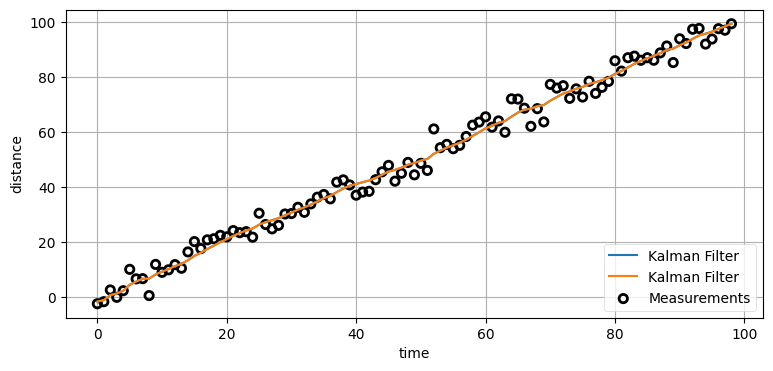

In [51]:
dt = 1.
R = 3.
kf = KalmanFilter(dim_x=2, dim_z=1, dim_u = 1)
kf.P *= 10
kf.R *= R
kf.Q = Q_discrete_white_noise(2, dt, 0.1)
kf.F = np.array([[1., 0], [0., 0.]])
kf.B = np.array([[dt], [ 1.]])
kf.H = np.array([[1., 0]])
print(kf.P)

zs = [i + randn()*R for i in range(1, 100)]
xs = []
cmd_velocity = np.array([1.])
for z in zs:
    kf.predict(u=cmd_velocity)
    kf.update(z)
    xs.append(kf.x[0])

plt.plot(xs, label='Kalman Filter')
plot_measurements(zs)
plt.xlabel('time')
plt.legend(loc=4)
plt.ylabel('distance');

## Sensor Fusion   传感器融合

Early in the g-h filter chapter we discussed designing a filter for two scales, one accurate and one  inaccurate. We determined that we should always include the information from the inaccurate filter - we should never discard any information. So consider a situation where we have two sensors measuring the system. How shall we incorporate that into our Kalman filter? 在 g-h 滤波器章节的早期部分，我们讨论了为两个尺度设计滤波器，一个精确，一个不精确。我们确定应始终包含不精确滤波器的信息——我们永远不应丢弃任何信息。那么，假设我们有两个传感器在测量系统，我们应如何将其纳入卡尔曼滤波器呢？

Suppose we have a train or cart on a railway. It has a sensor attached to the wheels counting revolutions, which can be converted to a distance along the track. Then, suppose we have a GPS-like sensor which I'll call a 'position sensor' mounted to the train which reports position. I'll explain why I don't just use a GPS in the next section. Thus, we have two measurements, both reporting position along the track. Suppose further that the accuracy of the wheel sensor is 1m, and the accuracy of the position sensor is 10m. How do we combine these two measurements into one filter? This may seem quite contrived, but aircraft use sensor fusion to fuse the measurements from sensors such as a GPS, INS, Doppler radar, VOR, the airspeed indicator, and more.假设我们有一辆在铁轨上行驶的火车或手推车。车轮上装有一个传感器，用于计算转数，这可以转换为沿轨道的距离。再假设我们有一个类似 GPS 的传感器，我称之为“位置传感器”，安装在火车上，用于报告位置。我将在下一节解释为什么我不直接使用 GPS。因此，我们有两个测量值，都报告沿轨道的位置。假设车轮传感器的精度为 1 米，位置传感器的精度为 10 米。如何将这两个测量值融合到一个滤波器中？这可能看起来有些牵强，但飞机使用传感器融合来融合来自 GPS、惯性导航系统（INS）、多普勒雷达、甚高频全向信标（VOR）、空速指示器等传感器的测量值。

Kalman filters for inertial systems are very difficult, but fusing data from two or more sensors providing measurements of the same state variable (such as position) is quite easy. The relevant matrix is the measurement matrix $\mathbf H$. Recall that this matrix tells us how to convert from the Kalman filter's state $\mathbf x$ to a measurement $\mathbf z$. Suppose that we decide that our Kalman filter state should contain the position and velocity of the train, so that

$$ \mathbf x = \begin{bmatrix}x \\ \dot x\end{bmatrix}$$

We have two measurements for position, so we will define the measurement vector to be a vector of the measurements from the wheel and the position sensor.

$$ \mathbf z = \begin{bmatrix}z_{wheel} \\ z_{ps}\end{bmatrix}$$

So we have to design the matrix $\mathbf H$ to convert $\mathbf x$ to $\mathbf z$ . They are both positions, so the conversion is nothing more than multiplying by one:

$$ \begin{bmatrix}z_{wheel} \\ z_{ps}\end{bmatrix} = \begin{bmatrix}1 &0 \\ 1& 0\end{bmatrix} \begin{bmatrix}x \\ \dot x\end{bmatrix}$$

To make it clearer, suppose that the wheel reports not position but the number of rotations of the wheels, where 1 revolution yields 2 meters of travel. In that case we would write

$$ \begin{bmatrix}z_{rot} \\ z_{ps}\end{bmatrix} = \begin{bmatrix}0.5 &0 \\ 1& 0\end{bmatrix} \begin{bmatrix}x \\ \dot x\end{bmatrix}$$

Now we have to design the measurement noise matrix $\mathbf R$. Suppose that the measurement variance for the position is twice the variance of the wheel, and the standard deviation of the wheel is 1.5 meters. That gives us

$$
\begin{aligned}
\sigma_{wheel} &=  1.5\\
\sigma^2_{wheel} &= 2.25 \\ 
\sigma_{ps} &= 1.5*2 = 3 \\
\sigma^2_{ps} &= 9.
\end{aligned}
$$

That is pretty much our Kalman filter design. We need to design for $\mathbf Q$, but that is invariant to whether we are doing sensor fusion or not, so I will just choose some arbitrary value.

So let's run a simulation of this design. I will assume a velocity of 10 m/s with an update rate of 0.1 seconds.

fusion std: 1.647


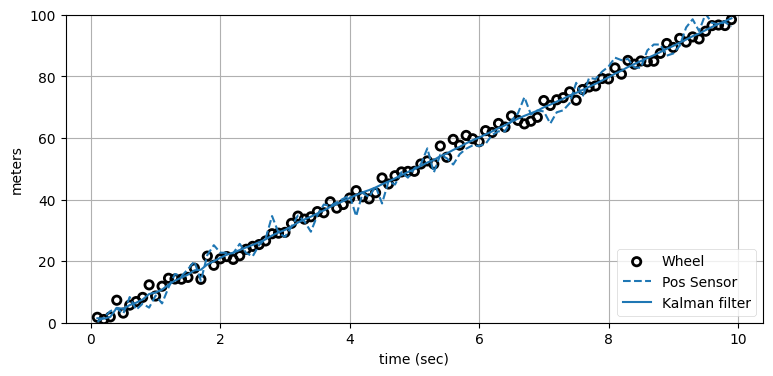

In [52]:
from numpy import array, asarray
import numpy.random as random

def fusion_test(wheel_sigma, ps_sigma, do_plot=True):
    dt = 0.1
    kf = KalmanFilter(dim_x=2, dim_z=2)

    kf.F = array([[1., dt], [0., 1.]])
    kf.H = array([[1., 0.], [1., 0.]])
    kf.x = array([[0.], [1.]])
    kf.Q *= array([[(dt**3)/3, (dt**2)/2],
                   [(dt**2)/2,  dt      ]]) * 0.02
    kf.P *= 100
    kf.R[0, 0] = wheel_sigma**2
    kf.R[1, 1] = ps_sigma**2 
    s = Saver(kf)

    random.seed(1123)
    for i in range(1, 100):
        m0 = i + randn()*wheel_sigma
        m1 = i + randn()*ps_sigma
        kf.predict()
        kf.update(array([[m0], [m1]]))
        s.save()
    s.to_array()
    print(f'fusion std: {np.std(s.y[:, 0]):.3f}')
    if do_plot:
        ts = np.arange(0.1, 10, .1)
        plot_measurements(ts, s.z[:, 0], label='Wheel')
        plt.plot(ts, s.z[:, 1], ls='--', label='Pos Sensor')
        plot_filter(ts, s.x[:, 0], label='Kalman filter')
        plt.legend(loc=4)
        plt.ylim(0, 100)
        set_labels(x='time (sec)', y='meters')

fusion_test(1.5, 3.0)

We can see the result of the Kalman filter in blue.我们可以看到卡尔曼滤波的结果用蓝色表示。

It may be somewhat difficult to understand the previous example at an intuitive level. Let's look at a different problem. Suppose we are tracking an object in 2D space, and have two radar systems at different positions. Each radar system gives us a range and bearing to the target. How do the readings from each data affect the results?要直观地理解前面的例子可能有点困难。让我们来看一个不同的问题。假设我们在二维空间中追踪一个物体，并且有两个位于不同位置的雷达系统。每个雷达系统都会给我们提供到目标的距离和方位。那么每个数据的读数如何影响结果呢？

This is a nonlinear problem because we need to use trigonometry  to compute coordinates from a range and bearing, and we have not yet learned how to solve nonlinear problems with Kalman filters. So for this problem ignore the code that I use and just concentrate on the charts that the code outputs. We will revisit this problem in subsequent chapters and learn how to write this code.这是一个非线性问题，因为我们需要使用三角学从距离和方位来计算坐标，而我们尚未学习如何用卡尔曼滤波器解决非线性问题。所以对于这个问题，忽略我所使用的代码，只需关注代码输出的图表。我们将在后续章节中再次探讨这个问题，并学习如何编写这段代码。

I will position the target at (100, 100). The first radar will be at (50, 50), and the second radar at (150, 50). This will cause the first radar to measure a bearing of 45 degrees, and the second will report 135 degrees.我会将目标定位在（100，100）处。第一台雷达位于（50，50），第二台雷达位于（150，50）。这样第一台雷达测得的方位角为 45 度，第二台则会报告 135 度。

I will create the Kalman filter first, and then plot its initial covariance matrix. I am using an **unscented Kalman filter**, which is covered in a later chapter.

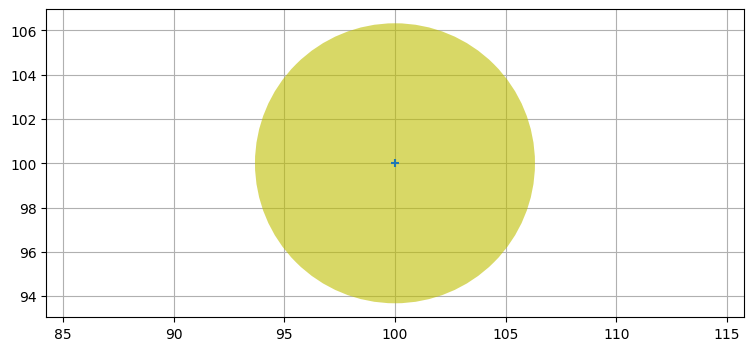

In [53]:
from kf_book.kf_design_internal import sensor_fusion_kf

kf = sensor_fusion_kf()
x0, p0 = kf.x.copy(), kf.P.copy()
plot_covariance_ellipse(x0, p0, fc='y', ec=None, alpha=0.6)

We are equally uncertain about the position in x and y, so the covariance is circular.我们在 x 轴和 y 轴上的位置同样不确定，所以协方差是圆形的。

Now we will update the Kalman filter with a reading from the first radar. I will set the standard deviation of the bearing error at 0.5$^\circ$, and the standard deviation of the distance error at 3.现在我们将用来自第一台雷达的读数更新卡尔曼滤波器。我将设定方位角误差的标准差为 0.5 度，距离误差的标准差为 3。

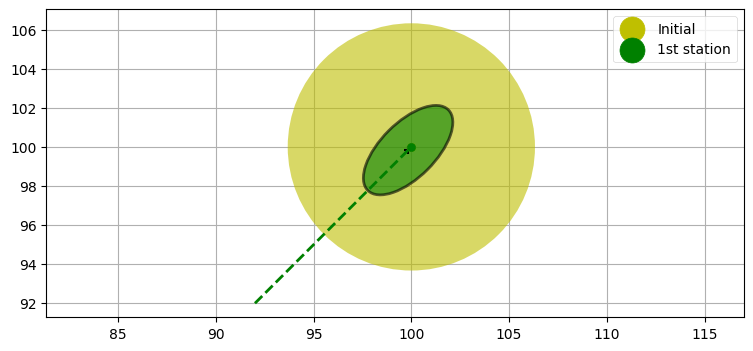

In [54]:
from math import radians
from kf_book.kf_design_internal import sensor_fusion_kf, set_radar_pos

# set the error of the radar's bearing and distance
kf.R[0, 0] = radians (.5)**2
kf.R[1, 1] = 3.**2

# compute position and covariance from first radar station
set_radar_pos((50, 50))
dist = (50**2 + 50**2) ** 0.5
kf.predict()
kf.update([radians(45), dist])

# plot the results
x1, p1 = kf.x.copy(), kf.P.copy()

plot_covariance_ellipse(x0, p0, fc='y', ec=None, alpha=0.6)
plot_covariance_ellipse(x1, p1, fc='g', ec='k', alpha=0.6)

plt.scatter([100], [100], c='y', label='Initial')
plt.scatter([100], [100], c='g', label='1st station')
plt.legend(scatterpoints=1, markerscale=3)
plt.plot([92, 100], [92, 100], c='g', lw=2, ls='--');

We can see the effect of the errors on the geometry of the problem. The radar station is to the lower left of the target. The bearing measurement is extremely accurate at $\sigma=0.5^\circ$, but the distance error is inaccurate at $\sigma=3$. I've shown the radar reading with the dotted green line. We can easily see the effect of the accurate bearing and inaccurate distance in the shape of the covariance ellipse. 我们可以看到误差对问题几何形状的影响。雷达站位于目标的左下方。方位测量的精度极高，标准差为 0.5 度，但距离误差较大，标准差为 3。我用虚线绿线标出了雷达读数。从协方差椭圆的形状中，我们可以很容易地看出精确方位和不精确距离所产生的影响。

Now we can incorporate the second radar station's measurement. The second radar is at (150,50), which is below and to the right of the target. Before you go on, think about how you think the covariance will change when we incorporate this new reading.现在我们可以将第二个雷达站的测量结果纳入考量。第二个雷达位于（150，50），在目标的右下方。在继续之前，请思考一下，当我们将这个新的读数纳入时，您认为协方差会如何变化。

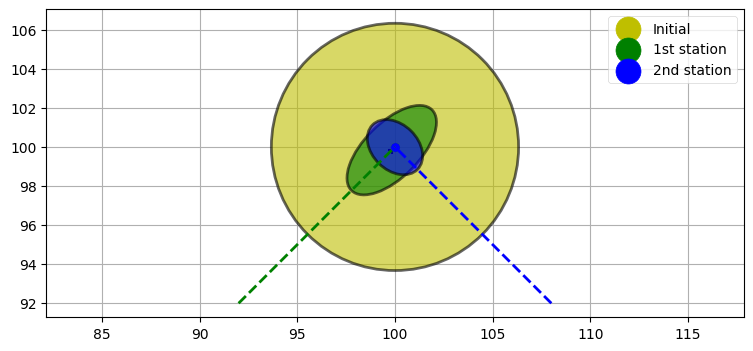

In [55]:
# compute position and covariance from second radar station
set_radar_pos((150, 50))
kf.predict()
kf.update([radians(135), dist])

plot_covariance_ellipse(x0, p0, fc='y', ec='k', alpha=0.6)
plot_covariance_ellipse(x1, p1, fc='g', ec='k', alpha=0.6)
plot_covariance_ellipse(kf.x, kf.P, fc='b', ec='k', alpha=0.6)

plt.scatter([100], [100], c='y', label='Initial')
plt.scatter([100], [100], c='g', label='1st station')
plt.scatter([100], [100], c='b', label='2nd station')
plt.legend(scatterpoints=1, markerscale=3)
plt.plot([92, 100], [92, 100], c='g', lw=2, ls='--')
plt.plot([108, 100], [92, 100], c='b', lw=2, ls='--');

We can see how the second radar measurement altered the covariance. The angle to the target is orthogonal to the first radar station, so the effects of the error in the bearing and range are swapped. So the angle of the covariance matrix switches to match the direction to the second station. It is important to note that the direction did not merely change; the size of the covariance matrix became much smaller as well.我们可以看到第二次雷达测量是如何改变协方差的。目标的角度与第一个雷达站垂直，因此方位和距离误差的影响发生了交换。所以协方差矩阵的角度也相应地转向与第二个雷达站的方向一致。需要注意的是，方向不仅发生了改变，协方差矩阵的大小也大幅减小了。

The covariance will always incorporate all of the information available, including the effects of the geometry of the problem. This formulation makes it particularly easy to see what is happening, but the same thing occurs if one sensor gives you position and a second sensor gives you velocity, or if two sensors provide measurements of position.协方差总是会整合所有可用的信息，包括问题几何形状的影响。这种表述方式特别便于看清所发生的情况，但即便一个传感器提供位置信息，另一个传感器提供速度信息，或者两个传感器都提供位置测量值，情况也是一样的。

One final thing before we move on: sensor fusion is a vast topic, and my coverage is simplistic to the point of being misleading. For example, GPS uses iterated least squares to determine the position from a set of pseudorange readings from the satellites without using a Kalman filter. I cover this topic in the supporting notebook [**Iterative Least Squares for Sensor Fusion**](http://nbviewer.ipython.org/urls/raw.github.com/rlabbe/Kalman-and-Bayesian-Filters-in-Python/master/Supporting_Notebooks/Iterative-Least-Squares-for-Sensor-Fusion.ipynb)在我们继续之前，还有一点要说：传感器融合是一个非常广泛的话题，我在这里的介绍过于简单，甚至可能具有误导性。例如，全球定位系统（GPS）通过迭代最小二乘法从卫星的伪距读数中确定位置，而无需使用卡尔曼滤波器。我在配套的笔记本 [**用于传感器融合的迭代最小二乘法**](http:/
bviewer.ipython.org/urls/raw.github.com/rlabbe/Kalman-and-Bayesian-Filters-in-Python/master/Supporting_Notebooks/Iterative-Least-Squares-for-Sensor-Fusion.ipynb) 中对此进行了介绍。This is introduced in bviewer.ipython.org/urls/raw.github.com/rlabbe/Kalman-and-Bayesian-Filters-in-Python/master/Supporting_Notebooks/Iterative-Least-Squares-for-Sensor-Fusion.ipynb.

That is the usual but not exclusive way this computation is done in GPS receivers. If you are a hobbyist my coverage may get you started. A commercial grade filter requires very careful design of the fusion process. That is the topic of several books, and you will have to further your education by finding one that covers your domain. 

### Exercise: Can you Filter GPS outputs?练习：你能筛选 GPS 输出吗？

In the section above I have you apply a Kalman filter to a 'GPS-like' sensor. Can you apply a Kalman filter to the output of a commercial Kalman filter? In other words, will the output of your filter be better than, worse than, or equal to the GPS's output?在上面的部分中，我让您将卡尔曼滤波器应用于一个类似 GPS 的传感器。您能否将卡尔曼滤波器应用于商用卡尔曼滤波器的输出？换句话说，您的滤波器的输出会比 GPS 的输出更好、更差还是相同？

#### Solution   解决方案

Commercial GPS's have a Kalman filter built into them, and their output is the filtered estimate created by that filter. So, suppose you have a steady stream of output from the GPS consisting of a position and position error. Can you not pass those two pieces of data into your own filter?商用 GPS 内置了卡尔曼滤波器，其输出是该滤波器生成的滤波估计值。那么，假设您从 GPS 持续获得包含位置和位置误差的输出流，您难道不能将这两项数据输入到自己的滤波器中吗？

Well, what are the characteristics of that data stream, and more importantly, what are the fundamental requirements of the input to the Kalman filter?那么，那个数据流有哪些特点，更重要的是，卡尔曼滤波器的输入有哪些基本要求？

Inputs to the Kalman filter must be *Gaussian* and *time independent*. This is because we imposed the requirement of the Markov property: the current state is dependent only on the previous state and current inputs. This makes the recursive form of the filter possible. The output of the GPS is *time dependent* because the filter bases its current estimate on the recursive estimates of all previous measurements. Hence, the signal is not white, it is not time independent, and if you pass that data into a Kalman filter you have violated the mathematical requirements of the filter. So, the answer is no, you cannot get better estimates by running a KF on the output of a commercial GPS. 卡尔曼滤波器的输入必须是*高斯分布*且*与时间无关*。这是因为我们强加了马尔可夫性质的要求：当前状态仅取决于前一状态和当前输入。这使得滤波器的递归形式成为可能。而 GPS 的输出是*与时间相关*的，因为滤波器基于所有先前测量的递归估计来得出当前估计值。因此，信号不是白噪声，不是与时间无关的，如果您将这些数据输入到卡尔曼滤波器中，就违反了滤波器的数学要求。所以，答案是否定的，您不能通过在商用 GPS 的输出上运行卡尔曼滤波器来获得更好的估计值。

Another way to think of it is that Kalman filters are optimal in a least squares sense. There is no way to take an optimal solution, pass it through a filter, any filter, and get a 'more optimal' answer because it is a logical impossibility. At best the signal will be unchanged, in which case it will still be optimal, or it will be changed, and hence no longer optimal.

This is a difficult problem that hobbyists face when trying to integrate GPS, IMU's and other off the shelf sensors. 

Let's look at the effect. A commercial GPS reports position, and an estimated error range. The estimated error just comes from the Kalman filter's $\mathbf P$ matrix. So let's filter some noisy data, take the filtered output as the new noisy input to the filter, and see what the result is. In other words, $\mathbf x$ will supply the  $\mathbf z$ input, and  $\mathbf P$ will supply the measurement covariance $\mathbf R$. To exaggerate the effects somewhat to make them more obvious I will plot the effects of doing this one, and then a second time. The second iteration doesn't make any 'sense' (no one would try that), it just helps me illustrate a point. First, the code and plots.

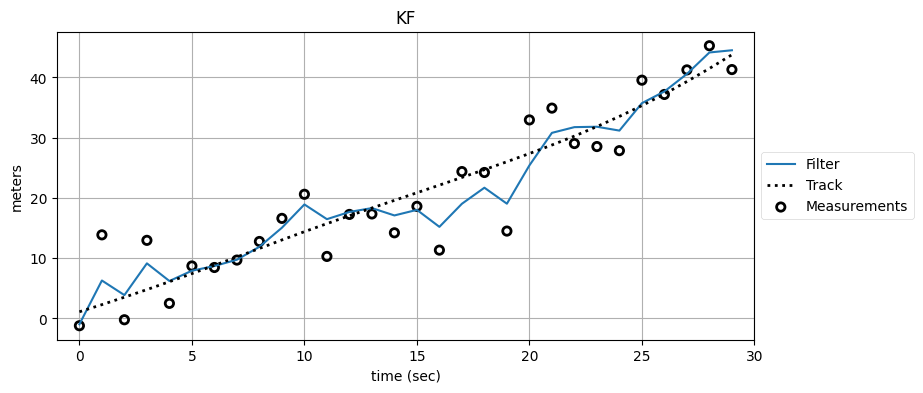

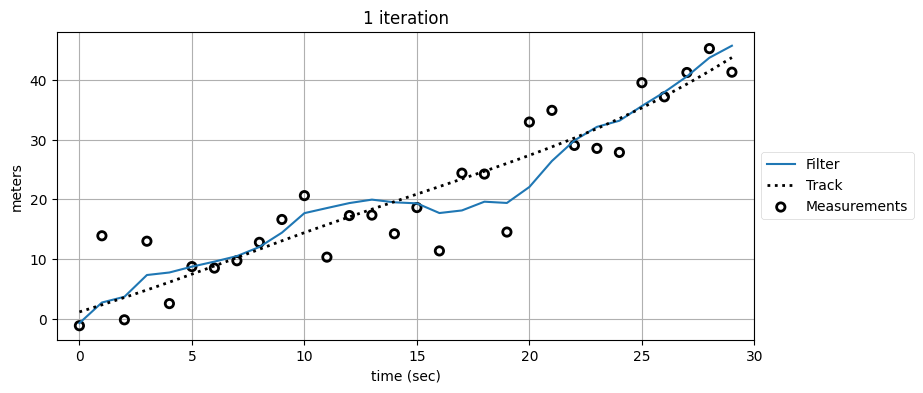

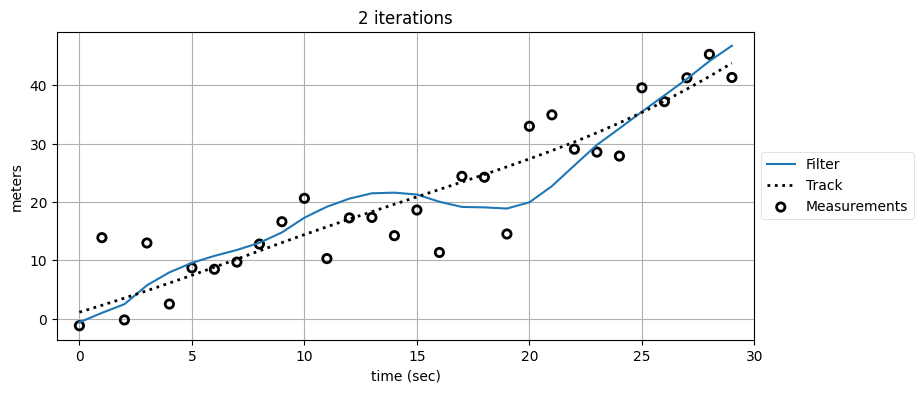

(5.0, 0.02)

In [56]:
np.random.seed(124)
R = 5.
xs, zs = simulate_acc_system(R=R, Q=Q, count=30)

kf0 = SecondOrderKF(R, Q, dt=1)
kf1 = SecondOrderKF(R, Q, dt=1)
kf2 = SecondOrderKF(R, Q, dt=1)

# Filter measurements
fxs0, ps0, _, _ = kf0.batch_filter(zs)

# filter twice more, using the state as the input
fxs1, ps1, _, _ = kf1.batch_filter(fxs0[:, 0])
fxs2, _, _, _ = kf2.batch_filter(fxs1[:, 0])

plot_kf_output(xs, fxs0, zs, 'KF', False)
plot_kf_output(xs, fxs1, zs, '1 iteration', False)
plot_kf_output(xs, fxs2, zs, '2 iterations', False)
R,Q

We see that the filtered output of the reprocessed signal is smoother, but it also diverges from the track. What is happening? Recall that the Kalman filter requires that the signal not be time correlated. However the output of the Kalman filter *is* time correlated because it incorporates all previous measurements into its estimate for this time period. So look at the last graph, for 2 iterations. The measurements start with several peaks that are larger than the track. This is 'remembered' (that is vague terminology, but I am trying to avoid the math) by the filter, and it has started to compute that the object is above the track. Later, at around 13 seconds we have a period where the measurements all happen to be below the track. This also gets incorporated into the memory of the filter, and the iterated output diverges far below the track. 我们看到，重新处理后的信号经过滤波后的输出更平滑了，但它也偏离了轨迹。这是怎么回事？回想一下，卡尔曼滤波器要求信号不能有时间相关性。然而，卡尔曼滤波器的输出是具有时间相关性的，因为它将所有先前的测量值都纳入了当前时间段的估计值中。所以请看最后一张图，迭代了两次。测量值一开始就有几个峰值高于轨迹。这被滤波器“记住”了（这是模糊的术语，但我尽量避免使用数学语言），滤波器开始计算物体在轨迹之上。后来，在大约 13 秒时，有一段测量值都恰好低于轨迹。这也被滤波器纳入了记忆，于是迭代输出远远偏离了轨迹。

Now let's look at this in a different way. The iterated output is *not* using $\mathbf z$ as the measurement, but the output of the previous Kalman filter estimate. So I will plot the output of the filter against the previous filter's output.现在让我们换个角度来审视这个问题。迭代输出并非以 $\mathbf   \ mathbf。 z$ 作为测量值，而是采用前一时刻卡尔曼滤波器的估计值。因此，我将把滤波器的输出与前一时刻滤波器的输出进行对比绘图。

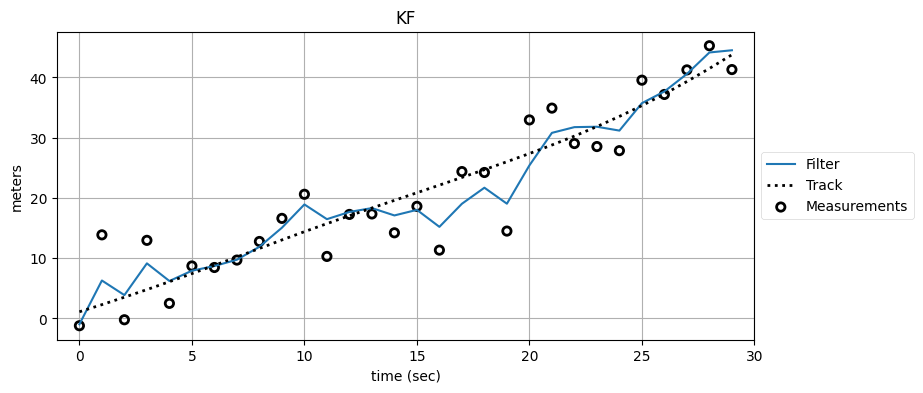

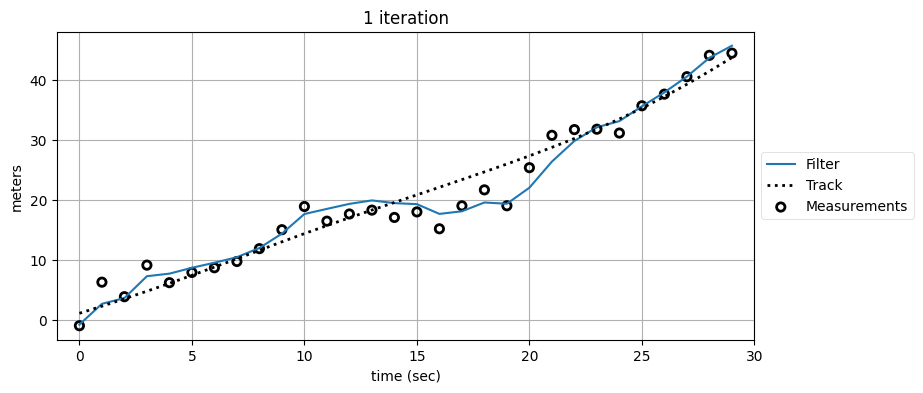

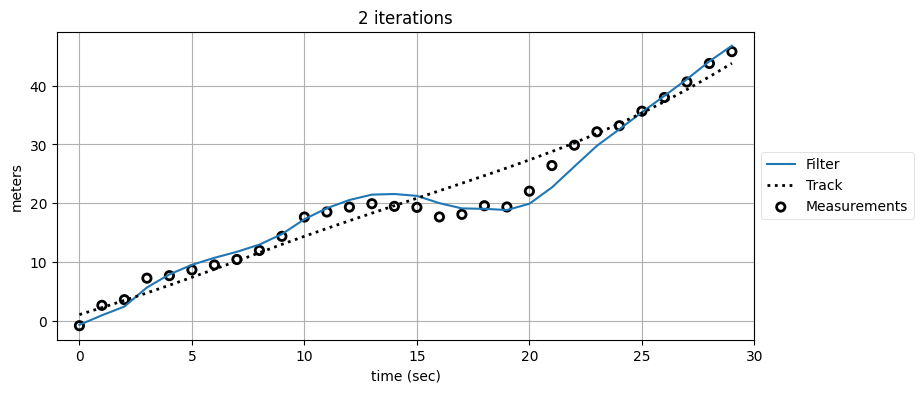

In [57]:
plot_kf_output(xs, fxs0, zs, title='KF', aspect_equal=False)
plot_kf_output(xs, fxs1, fxs0[:, 0], '1 iteration', False)
plot_kf_output(xs, fxs2, fxs1[:, 0], '2 iterations', False)

I hope the problem with this approach is now apparent. In the bottom graph we can see that the KF is tracking the imperfect estimates of the previous filter, and incorporating delay into the signal as well due to the memory of the previous measurements being incorporated into the signal.希望此时这种方法的问题已经显而易见了。从底部的图表中我们可以看到，卡尔曼滤波器（KF）正在追踪前一个滤波器的不完美估计值，并且由于前一次测量的记忆被纳入信号中，还引入了延迟。

### Exercise: Prove that the position sensor improves the filter练习：证明位置传感器能改进滤波器

Devise a way to prove that fusing the position sensor and wheel measurements yields a better result than using the wheel alone.设计一种方法来证明将位置传感器和车轮测量值融合起来比单独使用车轮测量值能得出更优的结果。

#### Solution 1   解决方案1

Force the Kalman filter to disregard the position sensor measurement by setting the measurement noise for the position sensor to a near infinite value. Re-run the filter and observe the standard deviation of the residual.将卡尔曼滤波器的位置传感器测量值置之不理，可将位置传感器的测量噪声设置为接近无穷大的值。重新运行滤波器，并观察残差的标准差。

In [58]:
fusion_test(1.5, 3.0, do_plot=False)
fusion_test(1.5, 1.e40, do_plot=False)

fusion std: 1.647
fusion std: 1.647


Here we can see the error in the filter where the position sensor measurement is almost entirely ignored is greater than that where it is used.在这里我们可以看到，滤波器中几乎完全忽略位置传感器测量值所产生的误差，要大于使用该测量值所产生的误差。

#### Solution 2   解决方案2

This is more work, but we can write a Kalman filter that only takes one measurement.这会多一些工作量，但我们能够编写一个仅采用一次测量值的卡尔曼滤波器。

std: 0.523


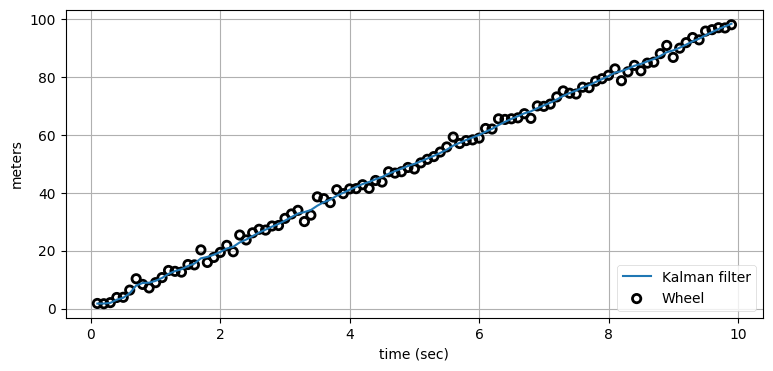

In [59]:
dt = 0.1
wheel_sigma = 1.5
kf = KalmanFilter(dim_x=2, dim_z=1)
kf.F = array([[1., dt], [0., 1.]])
kf.H = array([[1., 0.]])
kf.x = array([[0.], [1.]])
kf.Q *= 0.01
kf.P *= 100
kf.R[0, 0] = wheel_sigma**2

random.seed(1123)
nom = range(1, 100)
zs = np.array([i + randn()*wheel_sigma for i in nom])
xs, _, _, _ = kf.batch_filter(zs)
ts = np.arange(0.1, 10, .1)

res = nom - xs[:, 0, 0]
print(f'std: {np.std(res):.3f}')

plot_filter(ts, xs[:, 0], label='Kalman filter')
plot_measurements(ts, zs, label='Wheel')
set_labels(x='time (sec)', y='meters')
plt.legend(loc=4);

On this run I got a standard deviation of 0.523 vs the value of 0.391 for the fused measurements. 在这次运行中，我得到的标准差为 0.523，而融合测量值的标准差为 0.391。

## Nonstationary Processes   非平稳过程

So far we have assumed that the various matrices in the Kalman filter are *stationary* - nonchanging over time. For example, in the robot tracking section we assumed that $\Delta t = 1.0$ seconds, and designed the state transition matrix to be到目前为止，我们一直假定卡尔曼滤波器中的各种矩阵是*平稳的*——即不随时间变化。例如，在机器人跟踪部分，我们假定 $\Delta   \δ t = 1.0$ 秒，并设计了状态转移矩阵为

$$
\mathbf F = \begin{bmatrix}1& \Delta t& 0& 0\\0& 1& 0& 0\\0& 0& 1& \Delta t\\ 0& 0& 0& 1\end{bmatrix} = \begin{bmatrix}1& 1& 0& 0\\0& 1& 0& 0\\0& 0& 1& 1\\ 0& 0& 0& 1\end{bmatrix}$$

But what if our data rate changes in some unpredictable manner? Or what if we have two sensors, each running at a different rate? What if the error of the measurement changes? 但如果我们的数据传输速率以某种不可预测的方式发生变化呢？或者如果我们有两个传感器，每个传感器的运行速率都不同呢？如果测量误差发生变化又会怎样？

Handling this is easy; you just alter the Kalman filter matrices to reflect the current situation. Let's go back to our dog tracking problem and assume that the data input is somewhat sporadic. For this problem we designed处理这种情况很简单，您只需更改卡尔曼滤波矩阵以反映当前状况即可。让我们回到追踪狗的问题上，并假设数据输入有些不规律。针对这个问题，我们设计了


$$\begin{aligned}
\mathbf{\bar x} &= {\begin{bmatrix}x\\\dot x\end{bmatrix}}^- \\
\mathbf F &= \begin{bmatrix}1&\Delta t  \\ 0&1\end{bmatrix} 
\end{aligned}$$

and set the Kalman filter variable `F` during initialization like so:

```python
dt = 0.1
kf.F = np.array([[1, dt],
                 [0, 1]])
```

How would we handle $\Delta t$ changing for each measurement? It's easy - just modify the relevant matrices. In this case `F` is variant, so we will need to update this inside the update/predict loop.  `Q` is also dependent on time, so it must be assigned during each loop as well. Here is an example of how we might code this:

In [60]:
kf = KalmanFilter(dim_x=2, dim_z=1)
kf.x = array([0., 1.])
kf.H = array([[1, 0]])
kf.P = np.eye(2) * 50
kf.R = np.eye(1)
q_var = 0.02

# measurement tuple: (value, time)
zs = [(1., 1.),  (2., 1.1), (3., 0.9), (4.1, 1.23), (5.01, 0.97)]
for z, dt in zs:
    kf.F = array([[1, dt],
                  [0, 1]])
    kf.Q = Q_discrete_white_noise(dim=2, dt=dt, var=q_var)
    kf.predict()
    kf.update(z)
    print(kf.x)

[1. 1.]
[2.   0.92]
[2.96 1.  ]
[4.12 0.97]
[5.03 0.96]


### Sensor fusion: Different Data Rates传感器融合：不同的数据速率

It is rare that two different sensor classes output data at the same rate. Assume that the position sensor produces an update at 3 Hz, and the wheel updates at 7 Hz. Further assume that the timing is not precise - there is a bit of jitter such that a measurement can occur a bit before or after the predicted time. Let me further complicate the situation by having the wheel provide velocity estimates rather than position estimates.通常情况下，两种不同类型的传感器不会以相同的频率输出数据。假设位置传感器每秒更新 3 次，而轮子传感器每秒更新 7 次。再假设时间同步不够精确——存在一些抖动，使得测量值可能会在预测时间之前或之后出现。为了使情况更复杂，假设轮子传感器提供的是速度估计值而非位置估计值。

We can do this by waiting for a data packet from either sensor. When we get it, we determine the amount of time that has passed since the last update. We then need to modify the affected matrices. Both $\mathbf F$ and $\mathbf Q$ contain a time term $\Delta t$ so we will need to adjust these on every innovation. 我们可以通过等待来自任一传感器的数据包来实现这一点。收到数据包后，我们确定自上次更新以来经过的时间。然后我们需要修改受影响的矩阵。由于 $\mathbf   \ mathbf。 F$ 和 $\mathbf   \ mathbf。 Q   问$ 都包含时间项 $\Delta   \δ t$，因此每次创新时都需要调整它们。

The measurement changes each time, so we will have to modify $\mathbf H$ and $\mathbf R$. The position sensor alters the position element of $\mathbf x$, so we assign:每次测量结果都会有所变化，所以我们必须修改 $\mathbf   \ mathbf。 H$ 和 $\mathbf   \ mathbf。 R$。位置传感器会改变 $\mathbf   \ mathbf。 x$ 中的位置元素，因此我们指定：

$$\begin{aligned}
\mathbf H &= \begin{bmatrix}1 &0\end{bmatrix} \\
\mathbf R &= \sigma_{ps}^2
\end{aligned}$$

The wheel sensor alters the velocity element of $\mathbf x$, so we assign:

$$\begin{aligned}
\mathbf H &= \begin{bmatrix}0 &1\end{bmatrix} \\
\mathbf R &= \sigma_{wheel}^2
\end{aligned}$$

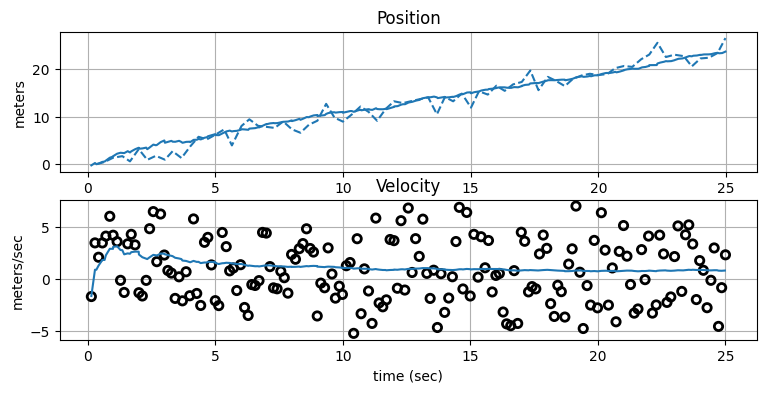

In [61]:
def gen_sensor_data(t, ps_std, wheel_std):
    # generate simulated sensor data
    pos_data, vel_data = [], []
    dt = 0.
    for i in range(t*3):
        dt += 1/3.
        t_i = dt + randn() * .01 # time jitter
        pos_data.append([t_i, t_i + randn()*ps_std])

    dt = 0.    
    for i in range(t*7):
        dt += 1/7.
        t_i = dt + randn() * .006 # time jitter
        vel_data.append([t_i, 1. + randn()*wheel_std])
    return pos_data, vel_data


def plot_fusion(xs, ts, zs_ps, zs_wheel):
    xs = np.array(xs)
    plt.subplot(211)
    plt.plot(zs_ps[:, 0], zs_ps[:, 1], ls='--', label='Pos Sensor')
    plot_filter(xs=ts, ys=xs[:, 0], label='Kalman filter')
    set_labels(title='Position', y='meters',)

    plt.subplot(212)
    plot_measurements(zs_wheel[:, 0], zs_wheel[:, 1],  label='Wheel')
    plot_filter(xs=ts, ys=xs[:, 1], label='Kalman filter')
    set_labels('Velocity', 'time (sec)', 'meters/sec')
    

def fusion_test(pos_data, vel_data, wheel_std, ps_std):
    kf = KalmanFilter(dim_x=2, dim_z=1)
    kf.F = array([[1., 1.], [0., 1.]])
    kf.H = array([[1., 0.], [1., 0.]])
    kf.x = array([[0.], [1.]])
    kf.P *= 100

    xs, ts = [],  []
    
    # copy data for plotting
    zs_wheel = np.array(vel_data)
    zs_ps = np.array(pos_data)
                     
    last_t = 0
    while len(pos_data) > 0 and len(vel_data) > 0:
        if pos_data[0][0] < vel_data[0][0]:
            t, z = pos_data.pop(0)
            dt = t - last_t
            last_t = t
            
            kf.H = np.array([[1., 0.]])
            kf.R[0,0] = ps_std**2
        else:
            t, z = vel_data.pop(0)
            dt = t - last_t
            last_t = t
            
            kf.H = np.array([[0., 1.]])
            kf.R[0,0] = wheel_std**2

        kf.F[0,1] = dt
        kf.Q = Q_discrete_white_noise(2, dt=dt, var=.02)
        kf.predict()
        kf.update(np.array([z]))

        xs.append(kf.x.T[0])
        ts.append(t)
    plot_fusion(xs, ts, zs_ps, zs_wheel)

random.seed(1123)
pos_data, vel_data = gen_sensor_data(25, 1.5, 3.0)
fusion_test(pos_data, vel_data, 1.5, 3.0);

## Tracking a Ball   追球

Now let's turn our attention to a situation where the physics of the object that we are tracking is constrained. A ball thrown in a vacuum must obey Newtonian laws. In a constant gravitational field it will travel in a parabola. I will assume you are familiar with the derivation of the formula:现在让我们把注意力转向这样一个情况，即我们所追踪的物体的物理特性受到限制。在真空环境中抛出的球必须遵循牛顿定律。在恒定的重力场中，它将沿抛物线运动。我假定您熟悉该公式的推导过程：

$$
\begin{aligned}   \贝京{aligned。
y &= \frac{g}{2}t^2 + v_{y0} t + y_0 \\y = \frac   \裂缝分析{g}{2}t^2 + v_{y0} t + y_0
x &= v_{x0} t + x_0X &= v_{x0} t x0
\end{aligned}   \ end办法{}
$$

where $g$ is the gravitational constant, $t$ is time, $v_{x0}$ and $v_{y0}$ are the initial velocities in the x and y plane. If the ball is thrown with an initial velocity of $v$ at angle $\theta$ above the horizon, we can compute $v_{x0}$ and $v_{y0}$ as其中，$g$ 为重力常数，$t$ 为时间，$v_{x0}$ 和 $v_{y0}$ 分别为 x 轴和 y 轴方向上的初速度。如果以初速度 $v$ 以与地平线成 $\theta   \θ$ 角向上抛出球，我们可以计算出 $v_{x0}$ 和 $v_{y0}$ 如下：

$$
\begin{aligned}   \贝京{aligned。
v_{x0} = v \cos{\theta} \\   \(v_{x0} = v \cos   \海岸线{\theta   \θ}\)
v_{y0} = v \sin{\theta}   v_{y0} = v \sin   罪\{\theta   \θ} 的中文翻译为：v_{y0} 等于 v 乘以 sinθ 。
\end{aligned}   \ end办法{}
$$

Because we don't have real data we will start by writing a simulator for a ball. As always, we add a noise term independent of time so we can simulate noisy sensors.由于我们没有真实的数据，所以我们将从编写一个球体的模拟器开始。和往常一样，我们会添加一个与时间无关的噪声项，以便模拟有噪声的传感器。

In [62]:
from math import radians, sin, cos
import math

def rk4(y, x, dx, f):
    """computes 4th order Runge-Kutta for dy/dx.
    y is the initial value for y
    x is the initial value for x
    dx is the difference in x (e.g. the time step)
    f is a callable function (y, x) that you supply to 
      compute dy/dx for the specified values.
    """
    
    k1 = dx * f(y, x)
    k2 = dx * f(y + 0.5*k1, x + 0.5*dx)
    k3 = dx * f(y + 0.5*k2, x + 0.5*dx)
    k4 = dx * f(y + k3, x + dx)
    
    return y + (k1 + 2*k2 + 2*k3 + k4) / 6.

def fx(x,t):
    return fx.vel
    
def fy(y,t):
    return fy.vel - 9.8*t


class BallTrajectory2D(object):
    def __init__(self, x0, y0, velocity, 
                 theta_deg=0., 
                 g=9.8, 
                 noise=[0.0, 0.0]):
        self.x = x0
        self.y = y0
        self.t = 0        
        theta = math.radians(theta_deg)
        fx.vel = math.cos(theta) * velocity
        fy.vel = math.sin(theta) * velocity        
        self.g = g
        self.noise = noise
        
        
    def step(self, dt):
        self.x = rk4(self.x, self.t, dt, fx)
        self.y = rk4(self.y, self.t, dt, fy)
        self.t += dt 
        return (self.x + randn()*self.noise[0], 
                self.y + randn()*self.noise[1])

So to create a trajectory starting at (0, 15) with a velocity of 100 m/s and an angle of 60° we would write:因此，要创建一条起始于（0，15）且速度为 100 米/秒、角度为 60°的轨迹，我们可以这样写：

```python   ”“python
traj = BallTrajectory2D(x0=0, y0=15, velocity=100, theta_deg=60)traj = BallTrajectory2D(x0=0, y0=15, velocity=100, theta_deg=60)

译文：traj = BallTrajectory2D(x0=0, y0=15, velocity=100, theta_deg=60轨迹 = 二维球体运动轨迹（初始 x 位置 = 0，初始 y 位置 = 15，速度 = 100，发射角度（度）= 60）
```
    
and then call `traj.step(t)` for each time step. Let's test this 然后对每个时间步调用 `traj.step(t)` 。让我们来测试一下。

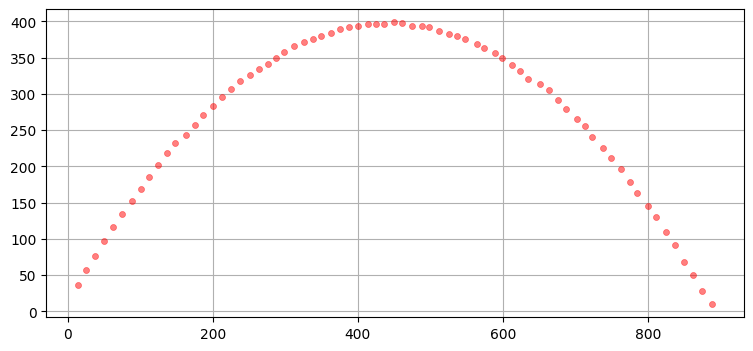

In [63]:
def test_ball_vacuum(noise):
    y = 15
    x = 0
    ball = BallTrajectory2D(x0=x, y0=y, 
                            theta_deg=60., velocity=100., 
                            noise=noise)
    t = 0
    dt = 0.25
    while y >= 0:
        x, y = ball.step(dt)
        t += dt
        if y >= 0:
            plt.scatter(x, y, color='r', marker='.', s=75, alpha=0.5)
         
    plt.axis('equal');
    
#test_ball_vacuum([0, 0]) # plot ideal ball position
test_ball_vacuum([1, 1]) # plot with noise 

This looks reasonable, so let's continue (exercise for the reader: validate this simulation more robustly).这看起来合理，那我们就继续吧（练习题：读者请更严谨地验证这个模拟）。

### Choose the State Variables选择状态变量

We might think to use the same state variables as used for tracking the dog. However, this will not work. Recall that the Kalman filter state transition must be written as $\mathbf{\bar x} = \mathbf{Fx} + \mathbf{Bu}$, which means we must calculate the current state from the previous state. Our assumption is that the ball is traveling in a vacuum, so the velocity in x is a constant, and the acceleration in y is solely due to the gravitational constant $g$. We can discretize the Newtonian equations using the well known Euler method in terms of $\Delta t$ are:我们可能会想到使用与追踪狗时相同的状态变量。然而，这行不通。回想一下，卡尔曼滤波器的状态转移必须写成 $\mathbf   \ mathbf。{\bar   \酒吧 x} = \mathbf   \ mathbf。{Fx   外汇} + \mathbf   \ mathbf。{Bu}$，这意味着我们必须根据前一状态来计算当前状态。我们的假设是球在真空中运动，所以 x 方向的速度是常数，而 y 方向的加速度仅由重力加速度 $g$ 决定。我们可以用著名的欧拉方法根据 $\Delta   \δ t$ 对牛顿方程进行离散化处理，具体如下：

$$\begin{aligned}   $ $ \开始{对齐}
x_t &=  x_{t-1} + v_{x(t-1)} {\Delta t} \\xₜ = xₜ₋₁ + vₓ(t₋₁)Δt
v_{xt} &= v_{x(t-1)} \\   v_{xt} = v_{x(t-1)}
y_t &= y_{t-1} + v_{y(t-1)} {\Delta t} \\yₜ = yₜ₋₁ + vₜ₋₁(yₜ₋₁) Δt
v_{yt} &= -g {\Delta t} + v_{y(t-1)} \\v_{yt} = -g \Delta   \δ t \cdot v_{y(t-1)}
\end{aligned}   \ end   结束办法{}
$$

> **sidebar**: *Euler's method integrates a differential equation stepwise by assuming the slope (derivative) is constant at time $t$. In this case the derivative of the position is velocity. At each time step $\Delta t$ we assume a constant velocity, compute the new position, and then update the velocity for the next time step. There are more accurate methods, such as Runge-Kutta available to us, but because we are updating the state with a measurement in each step Euler's method is very accurate. If you need to use Runge-Kutta you will have to write your own `predict()` function which computes the state transition for $\mathbf x$, and then uses the normal Kalman filter equation $\mathbf{\bar P}=\mathbf{FPF}^\mathsf T + \mathbf Q$ to update the covariance matrix.*> **侧边栏**：欧拉方法通过假设在时间 $t$ 时斜率（导数）恒定来逐步积分微分方程。在这种情况下，位置的导数就是速度。在每个时间步长 $\Delta   \δ t$ 中，我们假设速度恒定，计算新的位置，然后更新下一个时间步长的速度。虽然有更精确的方法，如龙格 - 库塔法可供使用，但由于我们在每一步都用测量值更新状态，所以欧拉方法非常准确。如果您需要使用龙格 - 库塔法，您将必须编写自己的 `predict()   预测()` 函数来计算 $\mathbf   \ mathbf。 x$ 的状态转移，然后使用标准卡尔曼滤波方程 $\mathbf   \ mathbf。{\bar   \酒吧 P}=\mathbf   \ mathbf。{FPF}^\mathsf T \mathbf   \ mathbf。 Q   问$ 来更新协方差矩阵。

This implies that we need to incorporate acceleration for $y$ into the Kalman filter, but not for $x$. This suggests the following state variable.

$$
\mathbf x = 
\begin{bmatrix}
x & \dot x & y & \dot y & \ddot{y}
\end{bmatrix}^\mathsf T
$$

However, the acceleration is due to gravity, which is a constant. Instead of asking the Kalman filter to track a constant we can treat gravity as what it really is - a control input. In other words, gravity is a force that alters the behavior of the system in a known way, and it is applied throughout the flight of the ball. 

The equation for the state prediction is $\mathbf{\bar x} = \mathbf{Fx} + \mathbf{Bu}$. $\mathbf{Fx}$ is the familiar state transition function which we will use to model the position and velocity of the ball. The vector $\mathbf{u}$ lets you specify a control input into the filter. For a car the control input will be things such as the amount the accelerator and brake are pressed, the position of the steering wheel, and so on. For our ball the control input will be gravity. The matrix $\mathbf{B}$ models how the control inputs affect the behavior of the system. Again, for a car $\mathbf{B}$ will convert the inputs of the brake and accelerator into changes of velocity, and the input of the steering wheel into a different position and heading. For our ball tracking problem it will compute the velocity change due to gravity. We will go into the details of that soon. For now, we design the state variable to be

状态预测方程为 $\mathbf{\bar x} = \mathbf{Fx} + \mathbf{Bu}$。其中 $\mathbf{Fx}$ 是熟悉的状态转移函数，我们将用它来建模球的位置和速度。向量 $\mathbf{u}$ 用于向滤波器输入控制信号。对于汽车而言，控制信号包括油门和刹车的踩踏力度、方向盘转动角度等参数。而对于我们的球体模型，控制信号即为重力作用。矩阵 $\mathbf{B}$ 描述控制信号如何影响系统行为。同样地，对于汽车模型，$\mathbf{B}$ 将把刹车和油门的输入转化为速度变化，并将方向盘输入转化为位置与航向的改变。而在球体追踪问题中，它将计算重力引起的加速度变化。具体细节我们稍后详述。目前，我们设计状态变量为

$$
\mathbf x = 
\begin{bmatrix}x & \dot x & y & \dot y 
\end{bmatrix}^\mathsf T
$$

### Design State Transition Function设计状态转换函数

Our next step is to design the state transition function. Recall that the state transition function is implemented as a matrix $\mathbf F$ that we multiply with the previous state of our system to get the next state, or prior $\bar{\mathbf x} = \mathbf{Fx}$.我们的下一步是设计状态转移函数。回想一下，状态转移函数是以矩阵 $\mathbf   \ mathbf。 F$ 的形式实现的，我们将它与系统的前一状态相乘，从而得到下一个状态，即先验值 $\bar   \酒吧{\mathbf   \ mathbf。 x} = \mathbf   \ mathbf。{Fx   外汇}$ 。

I will not belabor this as it is very similar to the 1-D case we did in the previous chapter. Our state equations for position and velocity would be:这里不再赘述，因为它与我们在上一章中处理的一维情况非常相似。我们关于位置和速度的状态方程将是：

$$
\begin{aligned}   \贝京{aligned。
\bar x &= (1*x) + (\Delta t * v_x) + (0*y) + (0 * v_y) \\\bar x = (1×x) + (\Delta   \δ t×v_x) + (0×y) + (0×v_y)
\bar v_x &= (0*x) +  (1*v_x) + (0*y) + (0 * v_y) \\\bar v_x = 0 \times   \ * x + 1 \times   \ * v_x + 0 \times   \ * y + 0 \times   \ * v_y
\bar y &= (0*x) + (0* v_x)         + (1*y) + (\Delta t * v_y)   \\\bar y = (0 \times   \ * x) + (0 \times   \ * v_x) + (1 \times   \ * y) + (\Delta   \δ t \times   \ * v_y)
\bar v_y &= (0*x) +  (0*v_x) + (0*y) + (1*v_y) \bar   \酒吧 v_y = 0 \times   \ * x - 0 \times   \ * v_x + 0 \times   \ * y + 1 \times   \ * v_y
\end{aligned}   \ end办法{}
$$

Note that none of the terms include $g$, the gravitational constant. As I explained in the previous function we will account for gravity using the control input of the Kalman filter.请注意，这些术语中均未包含重力常数 $g$。正如我在上一个函数中所解释的，我们将通过卡尔曼滤波器的控制输入来考虑重力的影响。
In matrix form we write this as:

$$
\mathbf F = \begin{bmatrix}
1 & \Delta t & 0 & 0 \\
0 & 1 & 0 & 0 \\
0 & 0 & 1 & \Delta t \\
0 & 0 & 0 & 1
\end{bmatrix}
$$

### Design the Control Input Function设计控制输入函数

We will use the control input to account for the force of gravity. The term $\mathbf{Bu}$ is added to $\mathbf{\bar x}$ to account for how much $\mathbf{\bar x}$ changes due to gravity. We can say that  $\mathbf{Bu}$ contains $\begin{bmatrix}\Delta x_g & \Delta \dot{x_g} & \Delta y_g & \Delta \dot{y_g}\end{bmatrix}^\mathsf T$.我们将利用控制输入来考虑重力的作用。在 $\mathbf   \ mathbf。{\bar   \酒吧 x}$ 中加上项 $\mathbf   \ mathbf。{Bu}$ 以反映由于重力导致的 $\mathbf   \ mathbf。{\bar   \酒吧 x}$ 的变化量。可以说，$\mathbf   \ mathbf。{Bu}$ 包含了 $\begin   \开始{bmatrix}\Delta   \δ x_g & \Delta   \δ \dot   \点{x_g} & \Delta   \δ y_g & \Delta   \δ \dot   \点{y_g}\end   \结束{bmatrix}^\mathsf T$ 。

If we look at the discretized equations we see that gravity only affects the velocity for $y$.如果我们查看离散化的方程，就会发现重力仅影响 $y$ 方向的速度。

$$\begin{aligned}   $ $ \开始{对齐}
x_t &=  x_{t-1} + v_{x(t-1)} {\Delta t} \\xₜ = xₜ₋₁ + vₓ(t₋₁)Δt
v_{xt} &= vx_{t-1}   V_ {xt} &= vx_{t-1}
\\
y_t &= y_{t-1} + v_{y(t-1)} {\Delta t}\\yₜ = yₜ₋₁ + vₚₜ₋₁ Δt
v_{yt} &= -g {\Delta t} + v_{y(t-1)} \\v_{yt} = -g \Delta   \δ t \cdot v_{y(t-1)}
\end{aligned}   \ end   结束办法{}
$$

Therefore we want the product $\mathbf{Bu}$ to equal $\begin{bmatrix}0 & 0 & 0 & -g \Delta t \end{bmatrix}^\mathsf T$. In some sense it is arbitrary how we define $\mathbf{B}$ and $\mathbf{u}$ so long as multiplying them together yields this result. For example, we could define $\mathbf{B}=1$ and $\mathbf{u} = \begin{bmatrix}0 & 0 & 0 & -g \Delta t \end{bmatrix}^\mathsf T$. But this doesn't really fit with our definitions for $\mathbf{B}$ and $\mathbf{u}$, where $\mathbf{u}$ is the control input, and $\mathbf{B}$ is the control function. The control input is $-g$ for the velocity of y. So this is one possible definition.因此我们希望乘积 $\mathbf   \ mathbf。{Bu}$ 等于 $\begin   \开始{bmatrix}0 & 0 & 0 & -g \Delta   \δ t \end   \结束{bmatrix}^\mathsf T$。在某种意义上，只要将 $\mathbf   \ mathbf。{B}$ 和 $\mathbf   \ mathbf。{u}$ 相乘能得到这个结果，我们如何定义它们是任意的。例如，我们可以定义 $\mathbf   \ mathbf。{B}=1$ 且 $\mathbf   \ mathbf。{u} = \begin   \开始{bmatrix}0 & 0 & 0 & -g \Delta   \δ t \end   \结束{bmatrix}^\mathsf T$。但这与我们对 $\mathbf   \ mathbf。{B}$ 和 $\mathbf   \ mathbf。{u}$ 的定义不太相符，其中 $\mathbf   \ mathbf。{u}$ 是控制输入，而 $\mathbf   \ mathbf。{B}$ 是控制函数。控制输入是 y 方向速度的 $-g$。所以这是可能的一种定义。

$$\mathbf{B} = \begin{bmatrix}0&0&0&0 \\ 0&0&0&0 \\0&0&0&0 \\0&0&0&\Delta t\end{bmatrix}, \mathbf{u} = \begin{bmatrix}0\\0\\0\\-g\end{bmatrix}$$

To me this seems a bit excessive; I would suggest we might want $\mathbf{u}$ to contain the control input for the two dimensions $x$ and $y$, which suggests

$$\mathbf{B} = \begin{bmatrix}0&0 \\ 0&0 \\0&0 \\0&\Delta t\end{bmatrix}, \mathbf{u} = \begin{bmatrix}0\\-g\end{bmatrix}$$.

You might prefer to only provide control inputs that actually exist, and there is no control input for $x$, so we arrive at

$$\mathbf{B} = \begin{bmatrix}0 \\ 0 \\0\\ \Delta t\end{bmatrix}, \mathbf{u} = \begin{bmatrix}-g\end{bmatrix}$$.

I've seen people use 
$$\mathbf{B} = \begin{bmatrix}0&0&0&0 \\ 0&0&0&0 \\0&0&0&0 \\0&0&0&1\end{bmatrix}, \mathbf{u} = \begin{bmatrix}0\\0\\0\\-g \Delta t\end{bmatrix}$$

While this does produce the correct result, I am resistant to putting time into $\mathbf{u}$  as time is not a control input, it is what we use to convert the control input into a change in state, which is the job of $\mathbf{B}$.

### Design the Measurement Function设计测量函数

The measurement function defines how we go from the state variables to the measurements using the equation $\mathbf z = \mathbf{Hx}$. We will assume that we have a sensor that provides us with the position of the ball in (x,y), but cannot measure velocities or accelerations. Therefore our function must be:测量函数定义了我们如何通过方程 $\mathbf   \ mathbf。 z = \mathbf   \ mathbf。{Hx}$ 从状态变量得出测量值。我们将假设我们有一个传感器，能为我们提供球在（x，y）坐标系中的位置，但无法测量速度或加速度。因此，我们的函数必须是：

$$
\begin{bmatrix}z_x \\ z_y \end{bmatrix}= \[\begin{bmatrix}z_x \\ z_y \end{bmatrix}=\] 可以翻译为：

\[\begin{bmatrix}z_x \\ z_y \end{bmatrix}
\begin{bmatrix}
1 & 0 & 0 & 0 \\
0 & 0 & 1 & 0
\end{bmatrix} 
\begin{bmatrix}
x \\
\dot x \\
y \\
\dot y \end{bmatrix}$$

where   在

$$\mathbf H = \begin{bmatrix}
1 & 0 & 0 & 0 \\
0 & 0 & 1 & 0
\end{bmatrix}$$   \结局{bmatrix元美元。

### Design the Measurement Noise Matrix设计测量噪声矩阵

As with the robot, we will assume that the error is independent in $x$ and $y$. In this case we will start by assuming that the measurement errors in x and y are 0.5 meters squared. Hence,与机器人的情况一样，我们将假设在 $x$ 和 $y$ 方向上的误差是相互独立的。在这种情况下，我们首先假设 $x$ 和 $y$ 方向上的测量误差为 0.5 平方米。因此，

$$\mathbf R = \begin{bmatrix}0.5&0\\0&0.5\end{bmatrix}$$

### Design the Process Noise Matrix设计过程噪声矩阵

We are assuming a ball moving in a vacuum, so there should be no process noise. We have 4 state variables, so we need a $4{\times}4$ covariance matrix:我们假设一个球在真空中运动，所以不应存在过程噪声。我们有 4 个状态变量，因此需要一个 $4{\times   \ *}4$ 的协方差矩阵：

$$\mathbf Q = \begin{bmatrix}0&0&0&0\\0&0&0&0\\0&0&0&0\\0&0&0&0\end{bmatrix}$$

### Design the Initial Conditions设计初始条件

We already performed this step when we tested the state transition function. Recall that we computed the initial velocity for $x$ and $y$ using trigonometry, and set the value of $\mathbf x$ with:我们在测试状态转换函数时已经执行了这一步。回想一下，我们使用三角函数计算了 $x$ 和 $y$ 的初始速度，并通过以下方式设置了 $\mathbf   \ mathbf。 x$ 的值：

```python   ”“python
omega = radians(omega)   ω = radians(ω)
vx = cos(omega) * v0   Vx = cos * v0
vy = sin(omega) * v0   Vy = sin * v0

f1.x = np.array([[x, vx, y, vy]]).Tf1.x = np.array   数组([[x, vx, y, vy]])T
```
    
With all the steps done we are ready to implement our filter and test it. First, the implementation:完成所有步骤后，我们就可以实现我们的过滤器并对其进行测试了。首先，实现部分：

In [64]:
from math import sin, cos, radians

def ball_kf(x, y, omega, v0, dt, r=0.5, q=0.):
    kf = KalmanFilter(dim_x=4, dim_z=2, dim_u=1)

    kf.F = np.array([[1., dt, 0., 0.],   # x   = x0 + dx*dt
                     [0., 1., 0., 0.],   # dx  = dx0
                     [0., 0., 1., dt],   # y   = y0 + dy*dt
                     [0., 0., 0., 1.]])  # dy  = dy0

    kf.H = np.array([[1., 0., 0., 0.],
                     [0., 0., 1., 0.]])
    
    kf.B = np.array([[0., 0., 0., dt]]).T
    kf.R *= r
    kf.Q *= q

    omega = radians(omega)
    vx = cos(omega) * v0
    vy = sin(omega) * v0
    kf.x = np.array([[x, vx, y, vy]]).T
    return kf

Now we will test the filter by generating measurements for the ball using the ball simulation class.现在我们将通过使用球模拟类为球生成测量值来测试滤波器。

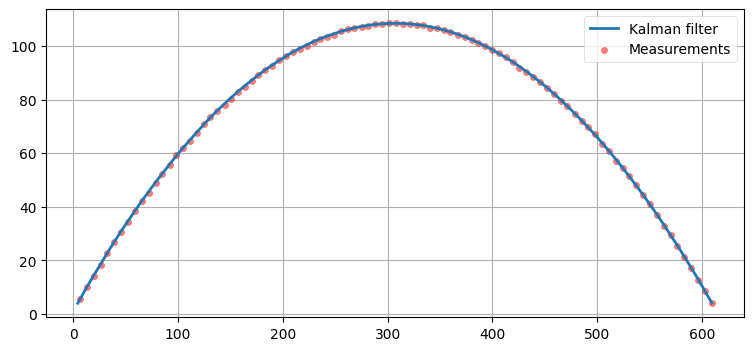

In [65]:
def track_ball_vacuum(dt):
    global kf
    x, y = 0., 1.
    theta = 35.  # launch angle
    v0 = 80.
    g = np.array([[-9.8]])  # gravitational constant
    ball = BallTrajectory2D(x0=x, y0=y, theta_deg=theta, velocity=v0, 
                            noise=[.2, .2])
    kf = ball_kf(x, y, theta, v0, dt)

    t = 0
    xs, ys = [], []
    while kf.x[2] > 0:
        t += dt
        x, y = ball.step(dt)
        z = np.array([[x, y]]).T

        kf.update(z)
        xs.append(kf.x[0])
        ys.append(kf.x[2])    
        kf.predict(u=g)     
        p1 = plt.scatter(x, y, color='r', marker='.', s=75, alpha=0.5)
    p2, = plt.plot(xs, ys, lw=2)
    plt.legend([p2, p1], ['Kalman filter', 'Measurements'],
               scatterpoints=1)
    
track_ball_vacuum(dt=1./10)

We see that the Kalman filter reasonably tracks the ball. However, as already explained, this is a trivial example because we have no process noise. We can predict trajectories in a vacuum with arbitrary precision; using a Kalman filter in this example is a needless complication. A least squares curve fit would give identical results.我们看到卡尔曼滤波器能合理地追踪球的轨迹。然而，正如之前所解释的，这是一个简单的例子，因为我们没有过程噪声。在真空中，我们可以任意精确地预测轨迹；在这个例子中使用卡尔曼滤波器是不必要的复杂化。最小二乘曲线拟合会给出相同的结果。

## Tracking a Ball in Air在空中追踪一个球

For this problem we assume that we are tracking a ball traveling through the Earth's atmosphere. The path of the ball is influenced by wind, drag, and the rotation of the ball. We will assume that our sensor is a camera; code that we will not implement will perform some type of image processing to detect the position of the ball. This is typically called *blob detection* in computer vision. However, image processing code is not perfect; in any given frame it is possible to either detect no blob or to detect spurious blobs that do not correspond to the ball. Finally, we will not assume that we know the starting position, angle, or rotation of the ball; the tracking code will have to initiate tracking based on the measurements that are provided. The main simplification that we are making here is a 2D world; we assume that the ball is always traveling orthogonal to the plane of the camera's sensor. We have to make that simplification at this point because we have not discussed how we might extract 3D information from a camera, which provides only 2D data. 对于这个问题，我们假设正在追踪一个在地球大气层中飞行的球。球的运动轨迹会受到风力、阻力以及球自身旋转的影响。我们将假设传感器是一台摄像机；我们不会实现的代码会执行某种图像处理来检测球的位置。这在计算机视觉中通常被称为“斑点检测”。然而，图像处理代码并非完美无缺；在任何给定的帧中，都有可能检测不到斑点，或者检测到与球无关的虚假斑点。最后，我们不会假设已知球的起始位置、角度或旋转情况；追踪代码必须根据所提供的测量值来启动追踪。这里我们做的主要简化是将其视为二维世界；我们假设球始终与摄像机传感器平面垂直运动。我们此时必须做出这种简化，因为我们尚未讨论如何从仅提供二维数据的摄像机中提取三维信息。

### Implementing Air Drag   实现空气阻力

Our first step is to implement the math for a ball moving through air. There are several treatments available. A robust solution takes into account issues such as ball roughness (which affects drag non-linearly depending on velocity), the Magnus effect (spin causes one side of the ball to have higher velocity relative to the air vs the opposite side, so the coefficient of drag differs on opposite sides), the effect of lift, humidity, air density, and so on. I assume the reader is not interested in the details of ball physics, and so will restrict this treatment to the effect of air drag on a non-spinning baseball. I will use the math developed by Nicholas Giordano and Hisao Nakanishi in *Computational Physics*  [1997]. This treatement does not take all the factors into account. The most detailed treatment is by Alan Nathan on his website at http://baseball.physics.illinois.edu/index.html. I use his math in my own work in computer vision, but I do not want to get distracted by a more complicated model.我们的第一步是实现一个在空气中运动的球的数学模型。有多种处理方法。一个可靠的解决方案需要考虑诸如球的粗糙度（这会根据速度对阻力产生非线性影响）、马格努斯效应（旋转使得球的一侧相对于空气的速度高于另一侧，因此阻力系数在两侧不同）、升力效应、湿度、空气密度等因素。我假定读者对球的物理细节不感兴趣，因此将此处理限制在非旋转棒球所受空气阻力的影响上。我将使用尼古拉斯·乔尔达诺（Nicholas Giordano）和久野久男（Hisao Nakanishi）在《计算物理学》[1997] 中开发的数学模型。这种处理方式并未涵盖所有因素。最详尽的处理方法是艾伦·内森（Alan Nathan）在其网站 http://baseball.physics.illinois.edu/index.html 上提供的。我在自己的计算机视觉工作中使用了他的数学模型，但我不想被更复杂的模型分散注意力。

**Important**: Before I continue, let me point out that you will not have to understand this next piece of physics to proceed with the Kalman filter. My goal is to create a reasonably accurate behavior of a baseball in the real world, so that we can test how our Kalman filter performs with real-world behavior. In real world applications it is usually impossible to completely model the physics of a real world system, and we make do with a process model that incorporates the large scale behaviors. We then tune the measurement noise and process noise until the filter works well with our data. There is a real risk to this; it is easy to finely tune a Kalman filter so it works perfectly with your test data, but performs badly when presented with slightly different data. This is perhaps the hardest part of designing a Kalman filter, and why it gets referred to with terms such as 'black art'. 

I dislike books that implement things without explanation, so I will now develop the physics for a ball moving through air. Move on past the implementation of the simulation if you are not interested. 

A ball moving through air encounters wind resistance. This imparts a force on the wall, called *drag*, which alters the flight of the ball. In Giordano this is denoted as

$$F_{drag} = -B_2v^2$$

where $B_2$ is a coefficient derived experimentally, and $v$ is the velocity of the object. $F_{drag}$ can be factored into $x$ and $y$ components with

$$\begin{aligned}
F_{drag,x} &= -B_2v v_x\\
F_{drag,y} &= -B_2v v_y
\end{aligned}$$

If $m$ is the mass of the ball, we can use $F=ma$ to compute the acceleration as

$$\begin{aligned} 
a_x &= -\frac{B_2}{m}v v_x\\
a_y &= -\frac{B_2}{m}v v_y
\end{aligned}$$

Giordano provides the following function for $\frac{B_2}{m}$, which takes air density, the cross section of a baseball, and its roughness into account. Understand that this is an approximation based on wind tunnel tests and several simplifying assumptions. It is in SI units: velocity is in meters/sec and time is in seconds.

$$\frac{B_2}{m} = 0.0039 + \frac{0.0058}{1+\exp{[(v-35)/5]}}$$

Starting with this Euler discretization of the ball path in a vacuum:
$$\begin{aligned}
x &= v_x \Delta t \\
y &= v_y \Delta t \\
v_x &= v_x \\
v_y &= v_y - 9.8 \Delta t
\end{aligned}
$$

We can incorporate this force (acceleration) into our equations by incorporating $accel * \Delta t$ into the velocity update equations. We should subtract this component because drag will reduce the velocity. The code to do this is quite straightforward, we just need to break out the force into $x$ and $y$ components. 

I will not belabor this issue further because computational physics is beyond the scope of this book. Recognize that a higher fidelity simulation would require incorporating things like altitude, temperature, ball spin, and several other factors. The aforementioned work by Alan Nathan covers this if you are interested. My intent here is to impart some real-world behavior into our simulation to test how  our simpler prediction model used by the Kalman filter reacts to this behavior. Your process model will never exactly model what happens in the world, and a large factor in designing a good Kalman filter is carefully testing how it performs against real world data. 

The code below computes the behavior of a baseball in air, at sea level, in the presence of wind. I plot the same initial hit with no wind, and then with a tail wind at 10 mph. Baseball statistics are universally done in US units, and we will follow suit here (http://en.wikipedia.org/wiki/United_States_customary_units). Note that the velocity of 110 mph is a typical exit speed for a baseball for a home run hit.

我们将通过在速度更新方程中加入$accel * \Delta t$来将该力（加速度）纳入计算。由于阻力会降低速度，我们需要减去该分量。实现代码相当简单，只需将力分解为$x$和$y$两个分量即可。

本书不涉及计算物理学，故不再赘述。需注意更高精度的模拟需纳入高度、温度、球体自旋等多重因素。若感兴趣，可参阅Alan Nathan的著作。本文旨在为模拟注入真实世界行为，以检验卡尔曼滤波器所用简化预测模型的响应能力。过程模型永远无法完全复现现实世界现象，而设计优质卡尔曼滤波器的关键，在于通过真实数据进行严谨的性能测试。

下述代码计算海平面风力条件下棒球在空气中的运动轨迹。我绘制了相同初始击球在无风条件下的轨迹，以及遭遇每小时10英里顺风时的轨迹。棒球统计数据普遍采用美制单位，本文亦遵循此标准（http://en.wikipedia.org/wiki/United_States_customary_units）。需注意110英里/小时的速度是本垒打击球中棒球离板的典型初始速度。

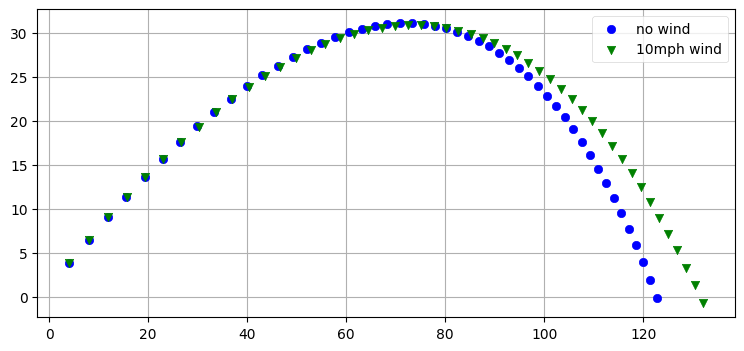

In [66]:
from math import sqrt, exp

def mph_to_mps(x):
    return x * .447

def drag_force(velocity):
    """ Returns the force on a baseball due to air drag at
    the specified velocity. Units are SI"""

    return velocity * (0.0039 + 0.0058 / 
            (1. + exp((velocity-35.)/5.)))

v = mph_to_mps(110.)
x, y = 0., 1.
dt = .1
theta = radians(35)

def solve(x, y, vel, v_wind, launch_angle):
    xs = []
    ys = []
    v_x = vel*cos(launch_angle)
    v_y = vel*sin(launch_angle)
    while y >= 0:
        # Euler equations for x and y
        x += v_x*dt
        y += v_y*dt

        # force due to air drag    
        velocity = sqrt((v_x-v_wind)**2 + v_y**2)    
        F = drag_force(velocity)

        # euler's equations for vx and vy
        v_x = v_x - F*(v_x-v_wind)*dt
        v_y = v_y - 9.8*dt - F*v_y*dt
        
        xs.append(x)
        ys.append(y)
    
    return xs, ys
        
x, y = solve(x=0, y=1, vel=v, v_wind=0, launch_angle=theta)
p1 = plt.scatter(x, y, color='blue', label='no wind')

wind = mph_to_mps(10)
x, y = solve(x=0, y=1, vel=v, v_wind=wind, launch_angle=theta)
p2 = plt.scatter(x, y, color='green', marker="v", 
                 label='10mph wind')
plt.legend(scatterpoints=1);

We can easily see the difference between the trajectory in a vacuum and in the air. I used the same initial velocity and launch angle in the ball in a vacuum section above. We computed that the ball in a vacuum would travel over 240 meters (nearly 800 ft). In the air, the distance is just over 120 meters, or roughly 400 ft. 400ft is a realistic distance for a well hit home run ball, so we can be confident that our simulation is reasonably accurate.我们很容易就能看出真空环境和空气环境中的轨迹差异。在上面的真空环境中的球的部分，我使用了相同的初速度和发射角度。我们计算得出，真空中的球能飞行超过 240 米（将近 800 英尺）。而在空气中，距离仅略超 120 米，约 400 英尺。400 英尺对于一记击得很好的本垒打球来说是较为实际的距离，所以我们有理由相信我们的模拟是相当准确的。

Without further ado we will create a ball simulation that uses the math above to create a more realistic ball trajectory. I will note that the nonlinear behavior of drag means that there is no analytic solution to the ball position at any point in time, so we need to compute the position step-wise. I use Euler's method to propagate the solution; use of a more accurate technique such as Runge-Kutta is left as an exercise for the reader. That modest complication is unnecessary for what we are doing because the accuracy difference between the techniques will be small for the time steps we will be using. 不再啰嗦，我们将创建一个球体模拟，利用上述数学知识来生成更真实的球体轨迹。需要指出的是，阻力的非线性特性意味着在任何时刻都无法得出球体位置的解析解，所以我们需要逐步计算位置。我使用欧拉法来推进解；使用诸如龙格 - 库塔法等更精确的技术作为练习留给读者。对于我们要做的事情来说，这种适度的复杂性是不必要的，因为在我们将要使用的步长下，这些技术之间的精度差异会很小。

In [67]:
class BaseballPath:
    def __init__(self, x0, y0, launch_angle_deg, velocity_ms, 
                 noise=(1.0, 1.0)): 
        """ Create 2D baseball path object  
           (x = distance from start point in ground plane, 
            y=height above ground)
        
        x0,y0            initial position
        launch_angle_deg angle ball is travelling respective to 
                         ground plane
        velocity_ms      speeed of ball in meters/second
        noise            amount of noise to add to each position
                         in (x, y)
        """
        
        omega = radians(launch_angle_deg)
        self.v_x = velocity_ms * cos(omega)
        self.v_y = velocity_ms * sin(omega)

        self.x = x0
        self.y = y0
        self.noise = noise


    def drag_force(self, velocity):
        """ Returns the force on a baseball due to air drag at
        the specified velocity. Units are SI
        """
        B_m = 0.0039 + 0.0058 / (1. + exp((velocity-35.)/5.))
        return B_m * velocity


    def update(self, dt, vel_wind=0.):
        """ compute the ball position based on the specified time 
        step and wind velocity. Returns (x, y) position tuple.
        """

        # Euler equations for x and y
        self.x += self.v_x*dt
        self.y += self.v_y*dt

        # force due to air drag
        v_x_wind = self.v_x - vel_wind
        v = sqrt(v_x_wind**2 + self.v_y**2)
        F = self.drag_force(v)

        # Euler's equations for velocity
        self.v_x = self.v_x - F*v_x_wind*dt
        self.v_y = self.v_y - 9.81*dt - F*self.v_y*dt

        return (self.x + randn()*self.noise[0], 
                self.y + randn()*self.noise[1])

Now we can test the Kalman filter against measurements created by this model.现在我们可以用这个模型生成的测量值来测试卡尔曼滤波器。

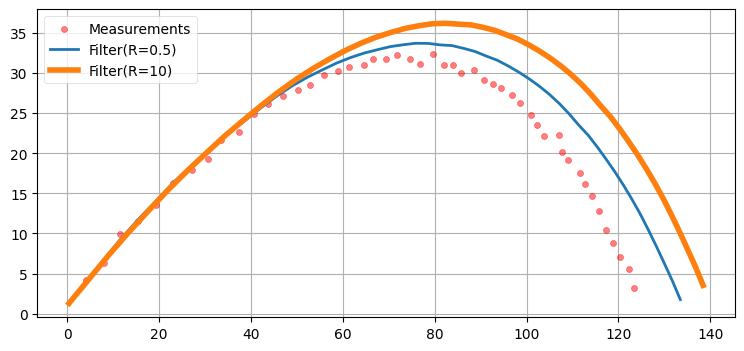

In [68]:
x, y = 0, 1.

theta = 35. # launch angle
v0 = 50.
dt = 1/10.   # time step
g = np.array([[-9.8]])

plt.figure()
ball = BaseballPath(x0=x, y0=y, launch_angle_deg=theta,
                    velocity_ms=v0, noise=[.3,.3])
f1 = ball_kf(x, y, theta, v0, dt, r=1.)
f2 = ball_kf(x, y, theta, v0, dt, r=10.)
t = 0
xs, ys = [], []
xs2, ys2 = [], []

while f1.x[2] > 0:
    t += dt
    x, y = ball.update(dt)
    z = np.array([[x, y]]).T

    f1.update(z)
    f2.update(z)
    xs.append(f1.x[0])
    ys.append(f1.x[2])
    xs2.append(f2.x[0])
    ys2.append(f2.x[2])    
    f1.predict(u=g) 
    f2.predict(u=g)
    
    p1 = plt.scatter(x, y, color='r', marker='.', s=75, alpha=0.5)

p2, = plt.plot(xs, ys, lw=2)
p3, = plt.plot(xs2, ys2, lw=4)
plt.legend([p1, p2, p3], 
           ['Measurements', 'Filter(R=0.5)', 'Filter(R=10)'],
           loc='best', scatterpoints=1);

I have plotted the output of two different Kalman filter settings. The measurements are depicted as green circles, a Kalman filter with R=0.5 as a thin green line, and a Kalman filter with R=10 as a thick blue line. These R values are chosen merely to show the effect of measurement noise on the output, they are not intended to imply a correct design.我绘制了两种不同卡尔曼滤波器设置的输出结果。测量值以绿色圆圈表示，R 值为 0.5 的卡尔曼滤波器以细绿线表示，R 值为 10 的卡尔曼滤波器以粗蓝线表示。选择这些 R 值只是为了展示测量噪声对输出的影响，并非意在表明正确的设计。

We can see that neither filter does very well. At first both track the measurements well, but as time continues they both diverge. This happens because the state model for air drag is nonlinear and the Kalman filter assumes that it is linear. If you recall our discussion about nonlinearity in the g-h filter chapter we showed why a g-h filter will always lag behind the acceleration of the system. We see the same thing here - the acceleration is negative, so the Kalman filter consistently overshoots the ball position. There is no way for the filter to catch up so long as the acceleration continues, so the filter will continue to diverge.我们可以看到，这两种滤波器的表现都不尽如人意。起初，它们都能很好地跟踪测量值，但随着时间的推移，它们都开始偏离。这是因为空气阻力的状态模型是非线性的，而卡尔曼滤波器却假定它是线性的。如果您还记得我们在 g-h 滤波器章节中关于非线性的讨论，我们解释了为什么 g-h 滤波器总是滞后于系统的加速度。在这里我们看到同样的情况——加速度为负，所以卡尔曼滤波器始终高估了球的位置。只要加速度持续存在，滤波器就无法赶上，因此滤波器会继续偏离。

What can we do to improve this? The best approach is to perform the filtering with a nonlinear Kalman filter, and we will do this in subsequent chapters. However, there is also what I will call an 'engineering' solution to this problem as well. Our Kalman filter assumes that the ball is in a vacuum, and thus that there is no process noise. However, since the ball is in air the atmosphere imparts a force on the ball. We can think of this force as process noise. This is not a particularly rigorous thought; for one thing, this force is anything but Gaussian. Secondly, we can compute this force, so throwing our hands up and saying 'it's random' will not lead to an optimal solution. But let's see what happens if we follow this line of thought.我们能做些什么来改进这种情况呢？最好的办法是用非线性卡尔曼滤波器来进行滤波，我们将在后续章节中进行介绍。不过，对于这个问题，还有一种我称之为“工程学”的解决办法。我们的卡尔曼滤波器假定球是在真空中，因此不存在过程噪声。然而，由于球是在空气中，大气会对球施加一个力。我们可以把这个力当作过程噪声。这种想法并不十分严谨；一方面，这个力绝非高斯分布。其次，我们能够计算出这个力，所以直接说“它是随机的”并不能得出最优解。不过，让我们看看沿着这条思路会怎样。

The following code implements the same Kalman filter as before, but with a non-zero process noise. I plot two examples, one with `Q=.1`, and one with `Q=0.01`.

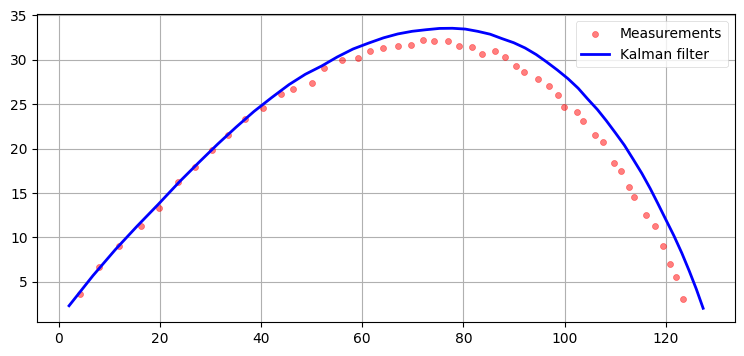

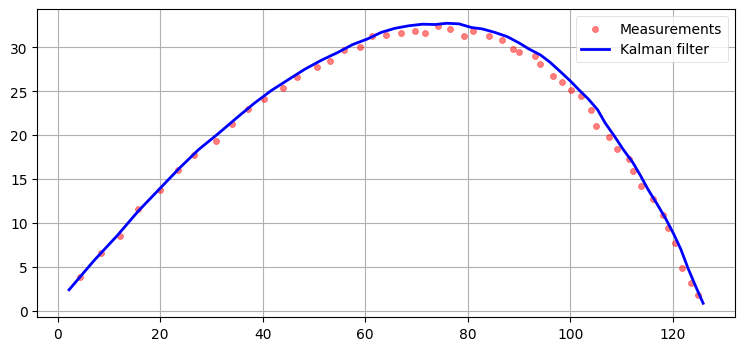

In [69]:
def plot_ball_with_q(q, r=1., noise=0.3):
    x, y = 0., 1.
    theta = 35. # launch angle
    v0 = 50.
    dt = 1/10.   # time step
    g = np.array([[-9.8]])

    ball = BaseballPath(x0=x, 
                        y0=y, 
                        launch_angle_deg=theta, 
                        velocity_ms=v0, 
                        noise=[noise,noise])
    f1 = ball_kf(x, y, theta, v0, dt, r=r, q=q)
    t = 0
    xs, ys = [], []

    while f1.x[2] > 0:
        t += dt
        x, y = ball.update(dt)
        z = np.array([[x, y]]).T

        f1.update(z)
        xs.append(f1.x[0])
        ys.append(f1.x[2]) 
        f1.predict(u=g) 

        p1 = plt.scatter(x, y, c='r', marker='.', s=75, alpha=0.5)

    p2, = plt.plot(xs, ys, lw=2, color='b')
    plt.legend([p1, p2], ['Measurements', 'Kalman filter'])
    plt.show()

plot_ball_with_q(0.01)
plot_ball_with_q(0.1)

The second filter tracks the measurements fairly well. There appears to be a bit of lag, but very little.第二个滤波器对测量值的跟踪效果相当不错。似乎有一点滞后，但非常轻微。

Is this a good technique? Usually not, but it depends. Here the nonlinearity of the force on the ball is fairly constant and regular. Assume we are trying to track an automobile - the accelerations will vary as the car changes speeds and turns. When we make the process noise higher than the actual noise in the system the filter will opt to weigh the measurements higher. If you don't have a lot of noise in your measurements this might work for you. However, consider this next plot where I have increased the noise in the measurements.这是一种好的技术吗？通常来说不是，但得视情况而定。这里球所受力的非线性相当恒定且有规律。假设我们要追踪一辆汽车——汽车在变速和转弯时加速度会变化。当我们将过程噪声设置得高于系统中的实际噪声时，滤波器会选择更重视测量值。如果您测量值中的噪声不多，这或许对您有用。不过，请看下面这个图表，我在这里增加了测量值中的噪声。

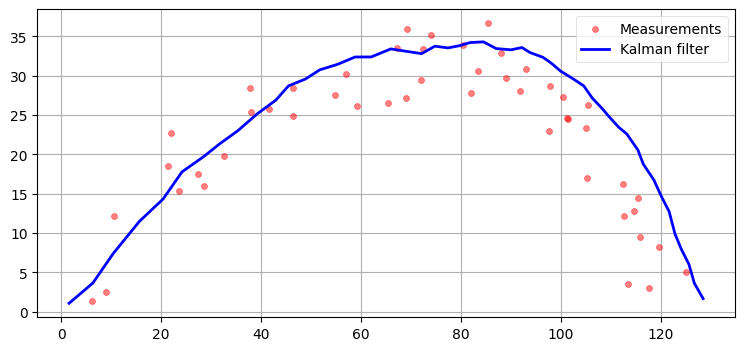

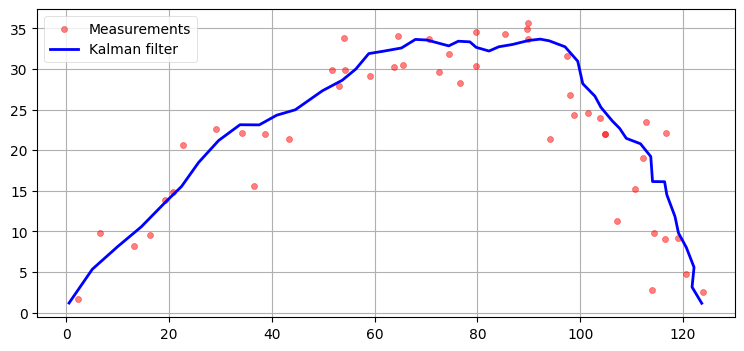

In [70]:
plot_ball_with_q(0.01, r=3, noise=3.)
plot_ball_with_q(0.1, r=3, noise=3.)

This output is terrible. The filter has no choice but to give more weight to the measurements than the process (prediction step), but when the measurements are noisy the filter output will just track the noise. This inherent limitation of the linear Kalman filter is what lead to the development of nonlinear versions of the filter.这种输出结果很糟糕。滤波器别无选择，只能赋予测量值比过程（预测步骤）更大的权重，但当测量值存在噪声时，滤波器的输出就会只是追踪噪声。正是线性卡尔曼滤波器的这种固有局限性，促使了非线性版本滤波器的发展。

With that said, it is certainly possible to use the process noise to deal with small nonlinearities in your system. This is part of the 'black art' of Kalman filters. Our model of the sensors and of the system are never perfect. Sensors are non-Gaussian and our process model is never perfect. You can mask some of this by setting the measurement errors and process errors higher than their theoretically correct values, but the trade off is a non-optimal solution. Certainly it is better to be non-optimal than to have your Kalman filter diverge. However, as we can see in the graphs above, it is easy for the output of the filter to be very bad. It is also very common to run many simulations and tests and to end up with a filter that performs very well under those conditions. Then, when you use the filter on real data the conditions are slightly different and the filter ends up performing terribly. 话虽如此，确实可以利用过程噪声来处理系统中的小非线性问题。这是卡尔曼滤波器的“黑艺术”之一。我们对传感器和系统的模型从来都不是完美的。传感器是非高斯的，我们的过程模型也从来都不是完美的。您可以通过将测量误差和过程误差设置得高于其理论上的正确值来掩盖其中的一些问题，但代价是得到一个非最优的解。当然，非最优总比卡尔曼滤波器发散要好。然而，正如上面的图表所示，滤波器的输出很容易变得非常糟糕。而且，经常会出现这样的情况：经过大量的模拟和测试，最终得到的滤波器在这些条件下表现得非常好。但当您将其用于实际数据时，条件稍有不同，滤波器的表现就会变得非常糟糕。

For now we will set this problem aside, as we are clearly misapplying the Kalman filter in this example. We will revisit this problem in subsequent chapters to see the effect of using various nonlinear techniques. In some domains you will be able to get away with using a linear Kalman filter for a nonlinear problem, but usually you will have to use one or more of the techniques you will learn in the rest of this book.

## References   参考文献

[1] Bar-Shalom, Yaakov, et al. *Estimation with Applications to Tracking and Navigation.* John Wiley & Sons, 2001.[1] 巴尔-沙洛姆，雅科夫等著，《跟踪与导航中的估计技术》，约翰威立国际出版公司，2001 年。